In [ ]:
!pip install pymc
!pip install nltk
!pip install wordcloud

     |████████████████████████████████| 385 kB 4.0 MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp37-cp37m-linux_x86_64.whl size=1353113 sha256=e534567395bfc5dfe923b1bdc040af422a61009bd553254d15cd356ac40051bd
  Stored in directory: /root/.cache/pip/wheels/3b/9b/1d/2a2ddbe80519db2698745f0988ce50c36ad38aac886a4ee0ca
Successfully built pymc


In [ ]:
import re
import sys
import csv
import string
import operator
import functools
import unicodedata

import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import pymc as pm

from math import sqrt
from wordcloud import WordCloud
from sklearn.datasets import make_spd_matrix
from scipy.spatial.distance import jensenshannon

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# **Task 1:** Latent Dirichlet Allocation


The choosen topics are as follow:
1.   Geography
2.   History
3.   Economy
4.   Politics
5.   Arts
6.   Sports
7.   Biology
8.   Chemistry
9.   Physics
10.  Mathematics
11.  Technology
12.  Religion

All the 120 documents were collected from the Wikipedia webpage. Each topic is represented by 6 documents. All documents contain specific terms for the dominant topic, but there are also terms belonging to more than one topic. However, in a document, the presence of others words in a specific context will disambiguate the terms' meaning. So the statistical assumption that most documents contain several different topics is preserved.

Due to the huge number of subthemes and the great number of specific terms present in each sample, I wanted to increase the frequency of some particular words that best describe the overall topic, so I manually added some specific terms for each topic. This will help us to distinguish between topics.



In [ ]:
topics = {0: 'Geography',
          1: 'History',
          2: 'Economy',
          3: 'Politics',
          4: 'Arts',
          5: 'Sports',
          6: 'Biology',
          7: 'Chemistry',
          8: 'Physics',
          9: 'Mathematics',
          10: 'Technology',
          11: 'Religion'}

Since the Latent Dirichlet Allocation(LDA) algorithm does not work well with very short documents, like social media posts or instant messages, as explained in [A biterm topic model for short texts](https://dl.acm.org/doi/10.1145/2488388.2488514), the documents were choose in order to have at least 100 words. In brief, the reason why LDA suffers from the length of the documents is the fact that the algorithm inferences its parameters from the observations by capturing word co-occurrence patterns at the document level to uncover the topics.

In [ ]:
documents = np.zeros(shape = (12, 10), dtype=object)

#  Geography
documents[0, 0] = "Geography. Geography is a field of science devoted to the study of the lands, features, inhabitants, and phenomena of the Earth and planets. The first person to use the word geography was Eratosthenes (276–194 BC). Geography is an all-encompassing discipline that seeks an understanding of Earth and its human and natural complexities—not merely where objects are, but also how they have changed and come to be. Geography is often defined in terms of two branches: human geography and physical geography. Human geography is concerned with the study of people and their communities, cultures, economies, and interactions with the environment by studying their relations with and across space and place. Physical geography is concerned with the study of processes and patterns in the natural environment like the atmosphere, hydrosphere, biosphere, and geosphere. The four historical traditions in geographical research are spatial analyses of natural and human phenomena, area studies of places and regions, studies of human-land relationships, and the Earth sciences. Geography has been called \"the world discipline\" and \"the bridge between the human and the physical sciences\"."
documents[0, 1] = "Geography. Geography is a systematic study of the Universe and its features. Traditionally, geography has been associated with cartography and place names. Although many geographers are trained in toponymy and cartology, this is not their main preoccupation. Geographers study the space and the temporal database distribution of phenomena, processes, and features as well as the interaction of humans and their environment. Because space and place affect a variety of topics, such as economics, health, climate, plants, and animals, geography is highly interdisciplinary. The interdisciplinary nature of the geographical approach depends on an attentiveness to the relationship between physical and human phenomena and their spatial patterns. Geography as a discipline can be split broadly into two main subsidiary fields: human geography and physical geography. The former largely focuses on the built environment and how humans create, view, manage, and influence space. The latter examines the natural environment, and how organisms, climate, soil, water, and landforms produce and interact. The difference between these approaches led to a third field, environmental geography, which combines physical and human geography and concerns the interactions between the environment and humans."
documents[0, 2] = "Regional geography. Regional geography is a major branch of geography. It focuses on the interaction of different cultural and natural geofactors in a specific land or landscape, while its counterpart, systematic geography, concentrates on a specific geofactor at the global level. Attention is paid to unique characteristics of a particular region such as natural elements, human elements, and regionalization which covers the techniques of delineating space into regions. Rooted in the tradition of the German-speaking countries, the two pillars of regional geography are the idiographic study of Länder or spatial individuals (specific places, countries, continents) and the typological study of Landschaften or spatial types (landscapes such as coastal regions, mountain regions, border regions, etc.). Regional geography is also a certain approach to geographical study, comparable to quantitative geography or critical geography. This approach prevailed during the second half of the 19th century and the first half of the 20th century, a period when the regional geography paradigm was central within the geographical sciences. It was later criticized for its descriptiveness and the lack of theory. Strong criticism was leveled against it in particular during the 1950s and the quantitative revolution."
documents[0, 3] = "Geography as a discipline. Geography was not recognized as a formal academic discipline until the 18th century, although many scholars had undertaken geographical scholarship for much longer, particularly through cartography. The Royal Geographical Society was founded in England in 1830, although the United Kingdom did not get its first full Chair of geography until 1917. The first real geographical intellect to emerge in United Kingdom's geographical minds was Halford John Mackinder, appointed reader at Oxford University in 1887. The National Geographic Society was founded in the United States in 1888 and began publication of the National Geographic magazine which became, and continues to be, a great popularizer of geographic information. Society has long supported geographic research and education on geographical topics. The Association of American Geographers was founded in 1904 and was renamed the American Association of Geographers in 2016 to better reflect the increasingly international character of its membership."
documents[0, 4] = "Regions. In geography, regions are areas that are broadly divided by physical characteristics (physical geography), human impact characteristics (human geography), and the interaction of humanity and the environment (environmental geography). Geographic regions and sub-regions are mostly described by their imprecisely defined, and sometimes transitory boundaries, except in human geography, where jurisdiction areas such as national borders are defined in law. Apart from the global continental regions, there are also hydrospheric and atmospheric regions that cover the oceans and discrete climates above the land and water masses of the planet. The land and water global regions are divided into subregions geographically bounded by large geological features that influence large-scale ecologies, such as plains and features. As a way of describing spatial areas, the concept of regions is important and widely used among the many branches of geography, each of which can describe areas in regional terms. For example, ecoregion is a term used in environmental geography, cultural region in cultural geography, bioregion in biogeography, and so on. The field of geography that studies regions themselves is called regional geography."
documents[0, 5] = "Integrated geography. Integrated geography (also referred to as integrative geography,[1] environmental geography or human–environment geography) is the branch of geography that describes and explains the spatial aspects of interactions between human individuals or societies and their natural environment, ( geography earth region ) these interactions being called coupled human-environment system. Summed up, environmental geography is about humans and nature and how we affect the environment and our planet. It requires an understanding of the dynamics of physical geography, as well as how human societies conceptualize the environment (human geography). Thus, to a certain degree, it may be seen as a successor of Physische Anthropogeographie (English: \" physical anthropogeography \") — a term coined by University of Vienna geographer Albrecht Penck in 1924[3]—and geographical cultural or human ecology (Harlan H. Barrows 1923). Integrated geography (geography) in the United States is principally influenced by the schools of Carl O. Sauer (Berkeley), whose perspective was rather historical, and Gilbert F. White (Chicago), who developed a more applied view. Integrated geography (also, integrative geography, environmental geography, or human–environment geography) is the branch of geography that describes and explains the spatial aspects of interactions between human individuals or societies and their natural environment, called coupled human-environment systems."
documents[0, 6] = "Cartography (geography). Cartography is the study and practice of making and using maps. Combining science, aesthetics and technique, cartography as related to geography, builds on the premise that reality can be modeled in ways that communicate spatial information effectively. The fundamental objectives of traditional cartography (geography) are to: set the map's agenda and select traits of the object to be mapped. This is the concern of map editing. Traits may be physical, such as roads or land masses, or may be abstract, such as toponyms or political boundaries; represent the terrain of the mapped object on flat media. This is the concern of map projections; eliminate characteristics of the mapped object that are not relevant to the map's purpose. This is the concern of generalization; reduce the complexity of the characteristics that will be mapped. This is also the concern of generalization. Modern cartography (geography) constitutes many theoretical and practical foundations of geographic information systems (GIS) and geographic information science (GISc). Map types. General vs. thematic cartography. In understanding basic maps, the field of cartography (geography) can be divided into two general categories: general cartography and thematic cartography. General cartography involves those maps that are constructed for a general audience and thus contain a variety of features. General maps exhibit many reference and location systems and often are produced in a series. For example, the 1:24,000 scale topographic maps of the United States Geological Survey (USGS) are a standard as compared to the 1:50,000 scale Canadian maps. Thematic cartography involves maps of specific geographic themes, oriented toward specific audiences. A couple of examples might be a dot map showing corn production in Indiana or a shaded area map of Ohio counties, divided into numerical choropleth classes. As the volume of geographic data has exploded over the last century, thematic cartography has become increasingly useful and necessary to interpret spatial, cultural and social data, and an essetial field of geography. A third type of map is known as an \" orienteering, \" or special purpose map. This type of map falls somewhere between thematic and general maps. They combine general map elements with thematic attributes in order to design a map with a specific audience in mind. Oftentimes, the type of audience an orienteering map is made for is in a particular industry or occupation. An example of this kind of map would be a municipal utility map.Topographic vs. topological maps. A topographic map is primarily concerned with the topographic description of a place, including (especially in the 20th and 21st centuries) the use of contour lines showing elevation. Terrain or relief can be shown in a variety of ways (see Cartographic relief depiction). In the present era, one of the most widespread and advanced methods used to form topographic maps is to use computer software to generate digital elevation models which show shaded relief. Before such software existed, cartographers had to draw shaded relief by hand. One cartographer who is respected as a master of hand-drawn shaded relief is the Swiss professor Eduard Imhof whose efforts in hill shading were so influential that his method became used around the world despite it being so labor-intensive. A topological map is a very general type of map, the kind one might sketch on a napkin. It often disregards scale and detail in the interest of clarity of communicating specific route or relational information. Beck's London Underground map is an iconic example. Although the most widely used map of \" The Tube, \" it preserves little of reality: it varies scale constantly and abruptly, it straightens curved tracks, and it contorts directions. The only topography on it is the River Thames, letting the reader know whether a station is north or south of the river. That and the topology of station order and interchanges between train lines are all that is left of the geographic space. Yet those are all a typical passenger wishes to know, so the map fulfills its purpose."
documents[0, 7] = "Geographer. A geographer is a physical scientist, social scientist, or humanist whose area of study is geography, the study of Earth's natural environment and human society, including how society and nature interact. Although geographers are historically known as people who make maps, map making is actually the field of study of cartography, a subset of geography. Geographers do not study only the details of the natural environment or human society, but they also study the reciprocal relationship between these two. For example, they study how the natural environment contributes to human society and how human society affects the natural environment. In particular, physical geographers study the natural environment while human geographers study human society and culture. Some geographers are practitioners of GIS (geographic information system) and are often employed by local, state, and federal government agencies as well as in the private sector by environmental and engineering firms. (geography)"
documents[0, 8] = "Human geography. Human geography or anthropogeography is the branch of geography that is associated and deals with humans and their relationships with communities, cultures, economies, and interactions with the environment by studying their relations with and across locations. [1] It analyzes patterns of human social interaction, their interactions with the environment, and their spatial interdependencies by application of qualitative and quantitative research methods. History of Human Geography. undertaken geographical scholarship for much longer, particularly through cartography. The Royal Geographical Society was founded in England in 1830,[4] although the United Kingdom did not get its first full Chair of geography until 1917. The first real geographical intellect to emerge in United Kingdom's geographical minds was Halford John Mackinder, appointed reader at Oxford University in 1887. The National Geographic Society was founded in the United States in 1888 and began publication of the National Geographic magazine which became, and continues to be, a great popularizer of geographic information. Society has long supported geographic research and education on geographical topics. The Association of American Geographers was founded in 1904 and was renamed the American Association of Geographers in 2016 to better reflect the increasingly international character of its membership. One of the first examples of geographic methods being used for purposes other than to describe and theorize the physical properties of the earth is John Snow's map of the 1854 Broad Street cholera outbreak. Though Snow was primarily a physician and a pioneer of epidemiology rather than a geographer, his map is probably one of the earliest examples of health geography. The now fairly distinct differences between the subfields of physical and human geography have developed at a later date. This connection between both physical and human properties of geography is most apparent in the theory of environmental determinism, made popular in the 19th century by Carl Ritter and others, and has close links to the field of the evolutionary biology of the time. Environmental determinism is the theory that people's physical, mental and moral habits are directly due to the influence of their natural environment. However, by the mid-19th century, environmental determinism was under attack for lacking methodological rigor associated with modern science, and later as a means to justify racism and imperialism. A similar concern with both human and physical aspects is apparent during the later 19th and first half of the 20th centuries focused on regional geography. The goal of regional geography, through something known as regionalization, was to delineate space into regions and then understand and describe the unique characteristics of each region through both human and physical aspects. With links to possibilism and cultural ecology, some of the same notions of causal effect of the environment on society and culture remain with environmental determinism. By the 1960s, however, the quantitative revolution led to strong criticism of regional geography. Due to a perceived lack of scientific rigor in an overly descriptive nature of the discipline, and continued separation of geography from its two subfields of physical and human geography and geology, geographers in the mid-20th century began to apply statistical and mathematical models to solve spatial problems. [1] Much of the development during the quantitative revolution is now apparent in the use of geographic information systems; the use of statistics, spatial modeling, and positivist approaches are still important to many branches of human geography. Well-known geographers from this period are Fred K. Schaefer, Waldo Tobler, William Garrison, Peter Haggett, Richard J. Chorley, William Bunge, and Torsten Hägerstrand. From the 1970s, several critiques of the positivism now associated with geography emerged. Known under the term 'critical geography,' these critiques signaled another turning point in the discipline. Behavioral geography emerged for some time as a means to understand how people made perceived spaces and places and made locational decisions. The more influential 'radical geography emerged in the 1970s and 1980s. It draws heavily on Marxist theory and techniques and is associated with geographers such as David Harvey and Richard Peet. Radical geographers seek to say meaningful things about problems recognized through quantitative methods,[5] provide explanations rather than descriptions, put forward alternatives and solutions, and be politically engaged,[6] rather than using the detachment associated with positivists. (The detachment and objectivity of the quantitative revolution were itself critiqued by radical geographers as being a tool of capital). Radical geography and the links to Marxism and related theories remain an important part of contemporary human geography (See: Antipode). Critical geography also saw the introduction of 'humanistic geography', associated with the work of Yi-Fu Tuan, which pushed for a much more qualitative approach in methodology. The changes under critical geography have led to contemporary approaches in the discipline such as feminist geography, new cultural geography, settlement geography, \" demonic \" geographies, and the engagement with postmodern and post-structural theories and philosophies."
documents[0, 9] = "Geodesy (geography). Geodesy is the Earth science of accurately measuring and understanding Earth's geometric shape, orientation in space, and gravitational field. Geodynamical (geography) phenomena include crustal motion, tides, and polar motion, which can be studied by designing global and national control networks, applying space and terrestrial techniques, and relying on datums and coordinate systems. To a large extent, the shape of Earth is the result of rotation, which causes its equatorial bulge, and the competition of geological processes such as the collision of plates and volcanism, resisted by Earth's gravitational field. This applies to the solid surface, the liquid surface (dynamic sea surface topography), and Earth's atmosphere. For this reason, the study of Earth's gravitational field is called physical geodesy."
#  History
documents[1, 0] = "Gender History. Gender history is a subfield of History and Gender studies, which looks at the past from the perspective of gender. The outgrowth of gender history from women's history stemmed from many non-feminist historians dismissing the importance of women in history. According to Joan W. Scott, “Gender is a constitutive element of social relationships based on perceived differences between the sexes, and gender is a primary way of signifying relations of power”, meaning that gender historians study the social effects of perceived differences between the sexes and how all genders utilize allotted power in societal and political structures. Despite being a relatively new field, gender history has had a significant effect on the general study of history. Gender history traditionally differs from women's history in its inclusion of all aspects of gender such as masculinity and femininity, and today's gender history extends to include people who identify outside of that binary. LGBT history deals with the first recorded instances of same-sex love and sexuality of ancient civilizations, and involves the history of lesbian, gay, bisexual and transgender (LGBT) peoples and cultures around the world."
documents[1, 1] = "Writing history was popular among Christian monks and clergy in the Middle Ages. They wrote about the history of Jesus Christ, that of the Church and that of their patrons, the dynastic history of the local rulers. In the Early Middle Ages historical writing often took the form of annals or chronicles recording events year by year, but this style tended to hamper the analysis of events and causes. An example of this type of writing is the Anglo-Saxon Chronicle, which was the work of several different writers: it was started during the reign of Alfred the Great in the late 9th century, but one copy was still being updated in 1154. Some writers in the period did construct a more narrative form of history. These included Gregory of Tours and more successfully Bede, who wrote both secular and ecclesiastical history and who is known for writing the Ecclesiastical History of the English People. During the Renaissance, history was written about states or nations. The study of history changed during the Enlightenment and Romanticism. Voltaire described the history of certain ages that he considered important, rather than describing events in chronological order. History became an independent discipline. It was not called philosophia historiae anymore, but merely history (historia)"
documents[1, 2] = "History. History (from Greek historia, meaning \"inquiry; knowledge acquired by investigation\") is the study of the past.[3][4] Events before the invention of writing systems are considered prehistory. \" History \" is an umbrella term comprising past events as well as the memory, discovery, collection, organization, presentation, and interpretation of these events. Historians seek knowledge of the past using historical sources such as written documents, oral accounts, art and material artifacts, and ecological markers. History is also an academic discipline that uses narrative to describe, examine, question, and analyze past events, and investigate their patterns of cause and effect.[6][7] Historians often debate which narrative best explains an event, as well as the significance of different causes and effects. Historians also debate the nature of history as an end in itself, as well as its usefulness to give perspective on the problems of the present. Stories common to a particular culture, but not supported by external sources (such as the tales surrounding King Arthur), are usually classified as cultural heritage or legends. History differs from myth in that it is supported by evidence. However, ancient cultural influences have helped spawn variant interpretations of the nature of history which have evolved over the centuries and continue to change today. The modern study of history is wide-ranging and includes the study of specific regions and the study of certain topical or thematic elements of historical investigation. History is often taught as part of primary and secondary education, and the academic study of history is a major discipline in university studies."
documents[1, 3] = "In the 20th century, academic historians focused less on epic nationalistic narratives, which often tended to glorify the nation or great men, to more objective and complex analyses of social and intellectual forces. A major trend of historical methodology in the 20th century was a tendency to treat history more as a social science rather than as an art, which traditionally had been the case. Some of the leading advocates of history as a social science were a diverse collection of scholars which included Fernand Braudel, E. H. Carr, Fritz Fischer, Emmanuel Le Roy Ladurie, Hans-Ulrich Wehler, Bruce Trigger, Marc Bloch, Karl Dietrich Bracher, Peter Gay, Robert Fogel, Lucien Febvre and Lawrence Stone. Many of the advocates of history as a social science were or are noted for their multi-disciplinary approach. Braudel combined history with geography, Bracher history with political science, Fogel history with economics, Gay history with psychology, Trigger history with archaeology while Wehler, Bloch, Fischer, Stone, Febvre and Le Roy Ladurie have in varying and differing ways amalgamated history with sociology, geography, anthropology, and economics. Nevertheless, these multidisciplinary approaches failed to produce a theory of history. So far only one theory of history came from the pen of a professional Historian. [44] Whatever other theories of history we have, were written by experts from other fields (for example, Marxian theory of history). More recently, the field of digital history has begun to address ways of using computer technology to pose new questions to historical data and generate digital scholarship. Insincere opposition to the claims of history as social science, historians such as Hugh Trevor-Roper, John Lukacs, Donald Creighton, Gertrude Himmelfarb, and Gerhard Ritter argued that the key to the historians' work was the power of the imagination, and hence contended that history should be understood as an art. French historians associated with the Annales School introduced quantitative history, using raw data to track the lives of typical individuals, and were prominent in the establishment of cultural history (cf. Histoire des mentalités). Intellectual historians such as Herbert Butterfield, Ernst Nolte, and George Mosse have argued for the significance of ideas in history. American historians, motivated by the civil rights era, focused on formerly overlooked ethnic, racial, and socio-economic groups. Another genre of social history to emerge in the post-WWII era was Alltagsgeschichte (History of Everyday Life). Scholars such as Martin Broszat, Ian Kershaw, and Detlev Peukert sought to examine what everyday life was like for ordinary people in 20th-century Germany, especially in the Nazi period. history"
documents[1, 4] = "Potential shortcomings in the production of history. Many historians believe that the production of history is embedded with bias because events and known facts in history can be interpreted in a variety of ways. Constantin Fasolt suggested that history is linked to politics by the practice of silence itself.  He also said: “A second common view of the link between history and politics rests on the elementary observation that historians are often influenced by politics.” According to Michel-Rolph Trouillot, the historical process is rooted in the archives, therefore silences, or parts of history that are forgotten, may be an intentional part of a narrative strategy that dictates how areas of history are remembered.[23] Historical omissions can occur in many ways and can have a profound effect on historical records. Information can also purposely be excluded or left out accidentally. Historians have coined multiple terms that describe the act of omitting historical information, including: “silencing,” “selective memory,” and erasures.[51] Gerda Lerner, a twentieth-century historian who focused much of her work on historical omissions involving women and their accomplishments, explained the negative impact that these omissions had on minority groups. Environmental historian William Cronon proposed three ways to combat bias and ensure authentic and accurate narratives: narratives must not contradict known fact, they must make ecological sense (specifically for environmental history), and published work must be reviewed by the scholarly community and other historians to ensure accountability."
documents[1, 5] = "Social history, sometimes called the new social history, is the field that includes history of ordinary people and their strategies and institutions for coping with life.[62] In its \" golden age \" it was a major growth field in the 1960s and 1970s among scholars, and still is well represented in history departments. In two decades from 1975 to 1995, the proportion of professors of history in American universities identifying with social history rose from 31% to 41%, while the proportion of political historians fell from 40% to 30%. In the history departments of British universities in 2007, of the 5723 faculty members, 1644 (29%) identified themselves with social history while political history came next with 1425 (25%).[64] The \" old \" social history before the 1960s was a hodgepodge of topics without a central theme, and it often included political movements, like Populism, that were \" social \" in the sense of being outside the elite system. Social history was contrasted with political history, intellectual history and the history of great men. English historian G. M. Trevelyan saw it as the bridging point between economic and political history, reflecting that, \"Without social history, economic history is barren and political history unintelligible.\"[65] While the field has often been viewed negatively as history with the politics left out, it has also been defended as \"history with the people put back in\"."
documents[1, 6] = "Human history. Human history, or world history, is the narrative of humanity's past. It is understood through archaeology, anthropology, genetics, and linguistics, and since the advent of writing, from primary and secondary sources. Humanity's written history was preceded by its prehistory, beginning with the Palaeolithic Era (\" Old Stone Age \"), followed by the Neolithic Era (\" New Stone Age \"). The Neolithic saw the Agricultural Revolution begin, between 10,000 and 5000 BCE, in the Near East's Fertile Crescent. During this period, humans began the systematic husbandry of plants and animals.[2] As agriculture advanced, most humans transitioned from a nomadic to a settled lifestyle as farmers in permanent settlements. The relative security and increased productivity provided by farming allowed communities to expand into increasingly larger units, fostered by advances in transportation. Whether in prehistoric or historic times, people always needed to be near reliable sources of drinking water. Settlements developed as early as 4,000 BCE in Iran,[3][4][5][6][7] in Mesopotamia,[8] in the Indus River valley on the Indian subcontinent,[9] on the banks of Egypt's Nile River,[10][11] and along China's rivers.[12][13] As farming developed, grain agriculture became more sophisticated and prompted a division of labour to store food between growing seasons. With civilizations flourishing, ancient history (\" Antiquity, \" including the Classical Age and Golden Age of India,[14] up to about 500 CE[15]) saw the rise and fall of empires. Post-classical history (the \" Middle Ages, \" c. 500–1500 CE,[16]) witnessed the rise of Christianity, the Islamic Golden Age (c. 750 CE – c. 1258 CE), and the Timurid and Italian Renaissances (from around 1300 CE). The mid-15th-century introduction of movable-type printing in Europe[17] revolutionized communication and facilitated ever wider dissemination of information, hastening the end of the Middle Ages and ushering in the Scientific Revolution.[18] The early modern period, sometimes referred to as the \" European Age and Age of the Islamic Gunpowders \",[19] from about 1500 to 1800,[20] included the Age of Discovery and the Age of Enlightenment. By the 18th century, the accumulation of knowledge and technology had reached a critical mass that brought about the Industrial Revolution[21] and began the late modern period, which started around 1800 and has continued through the present. This scheme of historical periodization (dividing history into Antiquity, Post-Classical, Early Modern, and Late Modern periods) was developed for, and applies best to, the history of the Old World, particularly Europe and the Mediterranean. Outside this region, including ancient China and ancient India, historical timelines unfolded differently. However, by the 18th century, due to extensive world trade and colonization, the histories of most civilizations had become substantially intertwined, a process known as globalization. In the last quarter-millennium, the rates of growth of population, knowledge, technology, communications, commerce, weapon destructiveness, and environmental degradation have greatly accelerated, creating unprecedented opportunities and perils that now confront the planet's human communities. history"
documents[1, 7] = "Prehistory. Prehistory, also known as pre-literary history,[1] is the period of human history between the use of the first stone tools by hominins c. 3.3 million years ago and the invention of writing systems. The use of symbols, marks, and images appears very early among humans, but the earliest known writing systems appeared c. 5000 years ago and it took thousands of years for writing systems to be widely adopted. In some human cultures, writing systems were not used until the nineteenth century and, in a few, are not even used until the present. The end of prehistory, therefore, came at very different dates in different places, and the term is less often used in discussing societies where prehistory ended relatively recently. Sumer in Mesopotamia, the Indus valley civilization, and ancient Egypt were the first civilizations to develop their own scripts and to keep historical records; this took place already during the early Bronze Age. Neighboring civilizations were the first to follow. Most other civilizations reached the end of prehistory during the Iron Age. The three-age system of division of prehistory into the Stone Age, followed by the Bronze Age and Iron Age, remains in use for much of Eurasia and North Africa, but is not generally used in those parts of the world where the working of hard metals arrived abruptly from contact with Eurasian cultures, such as Oceania, Australasia, much of Sub-Saharan Africa, and parts of the Americas. With some exceptions in pre-Columbian civilizations in the Americas, these areas did not develop complex writing systems before the arrival of Eurasians, so their prehistory reaches into relatively recent periods; for example, 1788 is usually taken as the end of the prehistory of Australia. The period when a culture is written about by others but has not developed its own writing system is often known as the protohistory of the culture. By definition,[2] there are no written records from human prehistory, so dating of prehistoric materials is crucial. Clear techniques for dating were not well-developed until the nineteenth century. This article is concerned with human prehistory, the time since behaviorally and anatomically modern humans first appeared until the beginning of recorded history. Earlier periods are also called \" prehistoric \"; there are separate articles for the overall history of the Earth and the history of life before humans."
documents[1, 8] = "Histography ( history ). Historiography ( history ) has several related meanings. Firstly, it can refer to how history has been produced: the story of the development of methodology and practices (for example, the move from short-term biographical narrative towards long-term thematic analysis). Secondly, it can refer to what has been produced: a specific body of historical writing (for example, \" medieval historiography during the 1960s \" means \" Works of medieval history written during the 1960s \"). Thirdly, it may refer to why history is produced: the philosophy of history. As a meta-level analysis of descriptions of the past, this third conception can relate to the first two in that the analysis usually focuses on the narratives, interpretations, world views, use of evidence, or method of presentation of other historians. Professional historians also debate the question of whether history can be taught as a single coherent narrative or a series of competing narratives history ( history historian civilization ) "
documents[1, 9] = "In the 20th century, academic historians focused less on epic nationalistic narratives, which often tended to glorify the nation or great men, to more objective and complex analyses of social and intellectual forces. A major trend of historical methodology in the 20th century was a tendency to treat history more as a social science rather than as an art, which traditionally had been the case. Some of the leading advocates of history as a social science were a diverse collection of scholars which included Fernand Braudel, E. H. Carr, Fritz Fischer, Emmanuel Le Roy Ladurie, Hans-Ulrich Wehler, Bruce Trigger, Marc Bloch, Karl Dietrich Bracher, Peter Gay, Robert Fogel, Lucien Febvre and Lawrence Stone. Many of the advocates of history as a social science were or are noted for their multi-disciplinary approach. Braudel combined history with geography, Bracher history with political science, Fogel history with economics, Gay history with psychology, Trigger history with archaeology while Wehler, Bloch, Fischer, Stone, Febvre and Le Roy Ladurie have in varying and differing ways amalgamated history with sociology, geography, anthropology, and economics. Nevertheless, these multidisciplinary approaches failed to produce a theory of history. So far only one theory of history came from the pen of a professional Historian. [44] Whatever other theories of history we have, were written by experts from other fields (for example, Marxian theory of history). More recently, the field of digital history has begun to address ways of using computer technology to pose new questions to historical data and generate digital scholarship. Insincere opposition to the claims of history as social science, historians such as Hugh Trevor-Roper, John Lukacs, Donald Creighton, Gertrude Himmelfarb, and Gerhard Ritter argued that the key to the historians' work was the power of the imagination, and hence contended that history should be understood as an art. French historians associated with the Annales School introduced quantitative history, using raw data to track the lives of typical individuals, and were prominent in the establishment of cultural history (cf. Histoire des mentalités). Intellectual historians such as Herbert Butterfield, Ernst Nolte, and George Mosse have argued for the significance of ideas in history. American historians, motivated by the civil rights era, focused on formerly overlooked ethnic, racial, and socio-economic groups. Another genre of social history to emerge in the post-WWII era was Alltagsgeschichte (History of Everyday Life). Scholars such as Martin Broszat, Ian Kershaw, and Detlev Peukert sought to examine what everyday life was like for ordinary people in 20th-century Germany, especially in the Nazi period. Marxist historians such as Eric Hobsbawm, E. P. Thompson, Rodney Hilton, Georges Lefebvre, Eugene Genovese, Isaac Deutscher, C. L. R. James, Timothy Mason, Herbert Aptheker, Arno J. Mayer, and Christopher Hill have sought to validate Karl Marx's theories by analyzing history from a Marxist perspective. In response to the Marxist interpretation of history, historians such as François Furet, Richard Pipes, J. C. D. Clark, Roland Mousnier, Henry Ashby Turner, and Robert Conquest have offered anti-Marxist interpretations of history. Feminist historians such as Joan Wallach Scott, Claudia Koonz, Natalie Zemon Davis, Sheila Rowbotham, Gisela Bock, Gerda Lerner, Elizabeth Fox-Genovese, and Lynn Hunt have argued for the importance of studying the experience of women in the past. In recent years, postmodernists have challenged the validity and need for the study of history on the basis that all history is based on the personal interpretation of sources. In his 1997 book In Defence of History, Richard J. Evans defended the worth of history. Another defense of history from post-modernist criticism was the Australian historian Keith Windschuttle\'s 1994 book, The Killing of History. Today, most historians begin their research process in the archives, on either a physical or digital platform. They often propose an argument and use their research to support it. John H. Arnold proposed that history is an argument, which creates the possibility of creating change. Digital information companies, such as Google, have sparked controversy over the role of internet censorship in information access."
#  Economy
documents[2, 0] = "Economics. Macroeconomics (from the Greek prefix makro- meaning \" large \" + economics) is a branch of economics dealing with the performance, structure, behavior, and decision-making of an economy as a whole. For example, using interest rates, taxes, and government spending to regulate an economy’s growth and stability. This includes regional, national, and global economies. According to a 2018 assessment by economists Emi Nakamura and Jón Steinsson, economic \" evidence regarding the consequences of different macroeconomic policies is still highly imperfect and open to serious criticism. ( economics money currency monetary inflation ) \" Macroeconomists  ( economics ) study topics such as GDP, unemployment (including unemployment rates), national income, price indices, output, consumption, inflation, saving, investment, energy, international trade, and international finance. Macroeconomics and microeconomics are the two most general fields in economics. The United Nations Sustainable Development Goal 17 has a target to enhance global macroeconomic stability through policy coordination and coherence as part of the 2030 Agenda."
documents[2, 1] = "Macroeconomics  ( economics ). Macroeconomics, at least in its modern form, began with the publication of General Theory of Employment, Interest and Money written by John Maynard Keynes. When the Great Depression struck, classical economists had difficulty in explaining how goods could go unsold and workers could be left unemployed. In classical theory, prices and wages would drop until the market cleared, and all goods and labor were sold. Keynes offered a new theory of economics that explained why markets might not clear, which would evolve (later in the 20th century) into a group of macroeconomic schools of thought known as Keynesian economics – also called Keynesianism or Keynesian theory. ( economics money currency monetary inflation ) In Keynes' theory, the quantity theory broke down because people and businesses tend to hold on to their cash in tough economic times – a phenomenon he described in terms of liquidity preferences. ( economics money currency monetary inflation ) Keynes also explained how the multiplier effect would magnify a small decrease in consumption or investment and cause declines throughout the economy. Keynes also noted the role uncertainty and animal spirits can play in the economy. The generation following Keynes combined the macroeconomics of the General Theory with neoclassical microeconomics to create the neoclassical synthesis. By the 1950s, most economists had accepted the synthesis view of the macroeconomy. Economists like Paul Samuelson, Franco Modigliani, James Tobin, and Robert Solow developed formal Keynesian models and contributed formal theories of consumption, investment, and money demand that fleshed out the Keynesian framework."
documents[2, 2] = "Monetarism  ( economics ). Milton Friedman updated the quantity theory of money to include a role for money demand. He argued that the role of money in the economy was sufficient to explain the Great Depression and that aggregate demand-oriented explanations were not necessary. Friedman also argued that monetary policy was more effective than fiscal policy; however, Friedman doubted the government's ability to \" fine-tune \" the economy with monetary policy. He generally favored a policy of steady growth in money supply instead of frequent intervention. ( economics money currency monetary inflation ) Friedman also challenged the Phillips curve relationship between inflation and unemployment. ( economics money currency monetary inflation ) Friedman and Edmund Phelps (who was not a monetarist) proposed an \" augmented \" version of the Phillips curve that excluded the possibility of a stable, long-run tradeoff between inflation and unemployment. When the oil shocks of the 1970s created high unemployment and high inflation, Friedman and Phelps were vindicated. Monetarism was particularly influential in the early 1980s. Monetarism ( economics ) fell out of favor when central banks found it difficult to target money supply instead of interest rates as monetarists recommended. Monetarism also became politically unpopular when the central banks created recessions in order to slow inflation. ( economics money currency monetary inflation )"
documents[2, 3] = "Inflation and deflation  ( economics ). A general price increase across the entire economy is called inflation. When prices decrease, there is deflation. Economists measure these changes in prices with price indexes. Inflation can occur when an economy becomes overheated and grows too quickly. Similarly, a declining economy can lead to deflation. Central bankers, who manage a country's money supply, try to avoid changes in price level by using monetary policy. Raising interest rates or reducing the supply of money in an economy will reduce inflation. Inflation can lead to increased uncertainty and other negative consequences. Deflation can lower economic output. Central bankers try to stabilize prices to protect economies from the negative consequences of price changes. ( economics money currency monetary inflation ) Changes in price level may be the result of several factors. The quantity theory of money holds that changes in the price level are directly related to changes in the money supply. Most economists believe that this relationship explains long-run changes in the price level. Short-run fluctuations may also be related to monetary factors, but changes in aggregate demand and aggregate supply can also influence price levels. For example, a decrease in demand due to a recession can lead to lower price levels and deflation. A negative supply shock, such as an oil crisis, lowers aggregate supply and can cause inflation. ( economics money currency monetary inflation )"
documents[2, 4] = "Monetary policy  ( economics ). Monetary policy is the policy adopted by the monetary authority of a nation to control either the interest rate payable for very short-term borrowing (borrowing by banks from each other to meet their short-term needs) or the money supply, often as an attempt to reduce inflation or the interest rate, to ensure price stability and general trust of the value and stability of the nation's currency. Monetary policy is a modification of the supply of money, i.e. \" printing \" more money, or decreasing the money supply by changing interest rates or removing excess reserves. ( economics money currency monetary inflation ) This is in contrast to fiscal policy, which relies on taxation, government spending, and government borrowing as methods for a government to manage business cycle phenomena such as recessions. ( economics money currency monetary inflation ) Further purposes of a monetary policy are usually to contribute to the stability of the gross domestic product, to achieve and maintain low unemployment, and to maintain predictable exchange rates with other currencies. Monetary economics can provide insight into crafting optimal monetary policy. In developed countries, monetary policy is generally formed separately from fiscal policy. ( economics money currency monetary inflation ) Monetary policy is referred to as being either expansionary or contractionary ( economics money currency monetary inflation )"
documents[2, 5] = "Developing countries may have problems establishing an effective operating monetary policy. The primary difficulty is that few developing countries have deep markets in government debt. The matter is further complicated by the difficulties in forecasting money demand and fiscal pressure to levy the inflation tax by expanding the base rapidly. In general, the central banks in many developing countries have poor records in managing monetary policy. This is often because the monetary authorities in developing countries are mostly not independent of the government, so good monetary policy takes a backseat to the political desires of the government or is used to pursue other non-monetary goals. For this and other reasons, developing countries that want to establish credible monetary policy may institute a currency board or adopt dollarization. This can avoid interference from the government and may lead to the adoption of monetary policy as carried out in the anchor nation. ( economics money currency monetary inflation ) Recent attempts at liberalizing and reform of financial markets (particularly the recapitalization of banks and other financial institutions in Nigeria and elsewhere) are gradually providing the latitude required to implement monetary policy frameworks by the relevant central banks. ( economics money currency monetary inflation )"
documents[2, 6] = "Money ( economics ). Money is any item or verifiable record that is generally accepted as payment for goods and services and repayment of debts, such as taxes, in a particular country or socio-economic context.[1][2][3] The main functions of money are distinguished as: a medium of exchange, a unit of account, a store of value and sometimes, a standard of deferred payment.[4][5] Any item or verifiable record that fulfils these functions can be considered as money. Money  ( economics ) is historically an emergent market phenomenon establishing a commodity money, but nearly all contemporary money systems are based on fiat money. ( economics money currency monetary inflation ) Fiat money, like any check or note of debt, is without use value as a physical commodity. ( economics money currency monetary inflation ) It derives its value by being declared by a government to be legal tender; that is, it must be accepted as a form of payment within the boundaries of the country, for \" all debts, public and private \".[6] Counterfeit money can cause good money to lose its value. The money supply of a country consists of currency (banknotes and coins - money) and, depending on the particular definition used, one or more types of bank money (the balances held in checking accounts, savings accounts, and other types of bank accounts). Bank money, which consists only of records (mostly computerized in modern banking), forms by far the largest part of broad money in developed countries. ( economics money currency monetary inflation )"
documents[2, 7] = "Currency ( economics ). A currency[a] in the most specific sense is money in any form when in use or circulation as a medium of exchange, especially circulating banknotes and coins. [1][2] A more general definition is that a currency is a system of money (monetary units) in common use, especially for people in a nation. [3] Under this definition, U.S. dollars (US$), euros (€), Indian rupee (₹), Japanese yen (¥), and pounds sterling (£) are examples of currencies. ( economics money currency monetary inflation ) Currencies  ( economics ) may act as stores of value and be traded between nations in foreign exchange markets, which determine the relative values of the different currencies. Currencies in this sense are defined by governments, and each type has limited boundaries of acceptance. Other definitions of the term \" currency \" appear in the respective synonymous articles: banknote, coin, and money. This article uses the definition which focuses on the currency systems of countries  ( economics money currency monetary inflation ). One can classify currencies into three monetary systems: fiat money, commodity money, and representative money depending on what guarantees a currency's value (the economy at large vs. the government's physical metal reserves). Some currencies function as legal tender in certain political jurisdictions. Others simply get traded for their economic value. The digital currency has arisen with the popularity of computers and the Internet. Whether digital notes and coins will be successfully developed remains dubious. ( economics money currency monetary inflation ) Decentralized digital currencies, such as cryptocurrencies are not legal currency, strictly speaking, since they are not issued by a government monetary authority (although one of them, Bitcoin, has become legal tender in El Salvador). Many warnings issued by various countries note the opportunities that cryptocurrencies create for illegal activities, such as money laundering and terrorism. [6] In 2014 the United States IRS issued a statement explaining that virtual currency is treated as property for federal income tax purposes and providing examples of how longstanding tax principles applicable to transactions involving property apply to virtual currency."
documents[2, 8] = "Foreign exchange market  ( economics ). The foreign exchange market (Forex, FX, or currency market) is a global decentralized or over-the-counter (OTC) market for the trading of currencies. This market determines foreign exchange rates for every currency. It includes all aspects of buying, selling and exchanging currencies at current or determined prices. In terms of trading volume, it is by far the largest market in the world, followed by the credit market. The main participants in this market are the larger international banks. Financial centers around the world function as anchors of trading between a wide range of multiple types of buyers and sellers around the clock, except for weekends. Since currencies are always traded in pairs, the foreign exchange market does not set a currency's absolute value but rather determines its relative value by setting the market price of one currency if paid for with another. Ex: US$1 is worth X CAD, or CHF, or JPY, etc. ( economics money currency monetary inflation ) The foreign exchange market works through financial institutions and operates on several levels. Behind the scenes, banks turn to a smaller number of financial firms known as \" dealers \", who are involved in large quantities of foreign exchange trading. Most foreign exchange dealers are banks, so this behind-the-scenes market is sometimes called the \" interbank market \" (although a few insurance companies and other kinds of financial firms are involved). Trades between foreign exchange dealers can be very large, involving hundreds of millions of dollars. Because of the sovereignty issue when involving two currencies, Forex has little (if any) supervisory entity regulating its actions. The foreign exchange market assists international trade and investments by enabling currency conversion. ( economics money currency monetary inflation ) In a typical foreign exchange transaction, a party purchases some quantity of one currency by paying with some quantity of another currency. The modern foreign exchange market began forming during the 1970s. This followed three decades of government restrictions on foreign exchange transactions under the Bretton Woods system of monetary management, which set out the rules for commercial and financial relations among the world's major industrial states after World War II. Countries gradually switched to floating exchange rates from the previous exchange rate regime, which remained fixed per the Bretton Woods system."
documents[2, 9] = "Financial institutions  ( economics ). Financial institutions, otherwise known as banking institutions, are corporations that provide services as intermediaries for different types of financial monetary transactions. Broadly speaking, there are three major types of financial institutions  ( economics money currency monetary inflation ): 1. Depository institutions – deposit-taking institutions that accept and manage deposits and make loans, including banks, building societies, credit unions, trust companies, and mortgage loan companies; 2.Contractual institutions – insurance companies and pension funds ;3. Investment institutions – investment banks, underwriters, and other different types of financial entities managing investments. Financial institutions can be distinguished broadly into two categories according to ownership structure: Commercial banks Cooperative banks Some experts see a trend toward homogenisation of financial institutions, meaning a tendency to invest in similar areas and have similar business strategies. ( economics money currency monetary inflation ) A consequence of this might be fewer banks serving specific target groups, and small-scale producers may be under-served.( economics money currency monetary inflation ) This is why a target of the United Nations Sustainable Development Goal 10 is to improve the regulation and monitoring of global financial institutions and strengthen such regulations. ( economics )"
#  Politics
documents[3, 0] = "Political science. Political science is the scientific study of politics. It is a social science dealing with systems of governance and power, and the analysis of political activities, political thought, political behavior, and associated constitutions and laws. Modern political science can generally be divided into the three subdisciplines of comparative politics, international relations, and political theory. Other notable subdisciplines are public policy and administration, domestic politics and government (often studied within comparative politics), political economy, and political methodology. Furthermore, political science is related to, and draws upon, the fields of economics, law, sociology, history, philosophy, human geography, journalism, political anthropology, psychology, and social policy. Political science is methodologically diverse and appropriates many methods originating in psychology, social research, and cognitive neuroscience. Political science, as one of the social sciences, uses methods and techniques that relate to the kinds of inquiries sought: primary sources, such as historical documents and official records, secondary sources, such as scholarly journal articles, survey research, statistical analysis, case studies, experimental research, and model building."
documents[3, 1] = "Political party. A political party is an organization that coordinates candidates to compete in a particular country's elections. It is common for the members of a party to hold similar ideas about politics, and parties may promote specific ideological or policy goals. Political parties have become a major part of the politics of almost every country, as modern party organizations developed and spread around the world over the last few centuries. It is extremely rare for a country to have no political parties. Some countries have only one political party while others have several. Parties are important in the politics of autocracies as well as democracies, though usually, democracies have more political parties than autocracies. Autocracies often have a single party that governs the country, and some political scientists consider competition between two or more parties to be an essential part of democracy. Parties can develop from existing divisions in society, like the divisions between lower and upper classes, and they streamline the process of making political decisions by encouraging their members to cooperate. Political parties usually include a party leader, who has primary responsibility for the activities of the party; party executives, who may select the leader and who perform administrative and organizational tasks; and party members, who may volunteer to help the party, donate money to it, and vote for its candidates. There are many different ways in which political parties can be structured and interact with the electorate. The contributions that citizens give to political parties are often regulated by law, and parties will sometimes govern in a way that favors the people who donate time and money to them. Many political parties are motivated by ideological goals. It is common for democratic elections to feature competitions between liberal, conservative, and socialist parties; other common ideologies of very large political parties include communism, populism, nationalism, and Islamism. Political parties in different countries will often adopt similar colors and symbols to identify themselves with a particular ideology. However, many political parties have no ideological affiliation, and may instead be primarily engaged in patronage, clientelism, or the advancement of a specific political entrepreneur."
documents[3, 2] = "Macropolitics can either describe political issues that affect an entire political system (e.g. the nation state), or refer to interactions between political systems (e.g. international relations). Global politics (or world politics) covers all aspects of politics that affect multiple political systems, in practice meaning any political phenomenon crossing national borders. This can include cities, nation-states, multinational corporations, non-governmental organizations, and/or international organizations. An important element is international relations: the relations between nation-states may be peaceful when they are conducted through diplomacy, or they may be violent, which is described as war. States that are able to exert strong international influence are referred to as superpowers, whereas less-powerful ones may be called regional or middle powers. The international system of power is called the world order, which is affected by the balance of power that defines the degree of polarity in the system. Emerging powers are potentially destabilizing to it, especially if they display revanchism or irredentism. Politics inside the limits of political systems, which in contemporary context correspond to national borders, are referred to as domestic politics. This includes most forms of public policy, such as social policy, economic policy, or law enforcement, which are executed by the state bureaucracy."
documents[3, 3] = "Freedom. Political freedom (also known as political liberty or autonomy) is a central concept in political thought and one of the most important features of democratic societies. Negative liberty has been described as freedom from oppression or coercion and unreasonable external constraints on action, often enacted through civil and political rights, while positive liberty is the absence of disabling conditions for an individual and the fulfillment of enabling conditions, e.g. economic compulsion, in a society. This capability approach to freedom requires economic, social, and cultural rights to be realized. Authoritarianism and libertarianism. Authoritarianism and libertarianism disagree with the amount of individual freedom each person possesses in that society relative to the state. One author describes authoritarian political systems as those where \" individual rights and goals are subjugated to group goals, expectations, and conformities, \" while libertarians generally oppose the state and hold the individual as sovereign. In their purest form, libertarians are anarchists, who argue for the total abolition of the state, of political parties, and other political entities, while the purest authoritarians are, by definition, totalitarians who support state control over all aspects of society. For instance, classical liberalism (also known as laissez-faire liberalism)[94] is a doctrine stressing individual freedom and limited government. This includes the importance of human rationality, individual property rights, free markets, natural rights, the protection of civil liberties, constitutional limitation of government, and individual freedom from restraint as exemplified in the writings of John Locke, Adam Smith, David Hume, David Ricardo, Voltaire, Montesquieu, and others. According to the libertarian Institute for Humane Studies, \" the libertarian, or 'classical liberal,' perspective is that individual well-being, prosperity, and social harmony are fostered by 'as much liberty as possible' and 'as little government as necessary.' \" For anarchist political philosopher L. Susan Brown (1993), \" liberalism and anarchism are two political philosophies that are fundamentally concerned with individual freedom yet differ from one another in very distinct ways. Anarchism shares with liberalism a radical commitment to individual freedom while rejecting liberalism's competitive property relations.\" "
documents[3, 4] = "Democracy. One theory holds that democracy requires three fundamental principles: upward control (sovereignty residing at the lowest levels of authority), political equality, and social norms by which individuals and institutions only consider acceptable acts that reflect the first two principles of upward control and political equality. Legal equality, political freedom, and rule of law are often identified as foundational characteristics for a well-functioning democracy. The term \" democracy \" is sometimes used as shorthand for liberal democracy, which is a variant of representative democracy that may include elements such as political pluralism; equality before the law; the right to petition elected officials for redress of grievances; due process; civil liberties; human rights; and elements of civil society outside the government. Roger Scruton argued that democracy alone cannot provide personal and political freedom unless the institutions of civil society are also present."
documents[3, 5] = "There are many decision-making methods used in democracies, but majority rule is the dominant form. Without compensation, like legal protections of individual or group rights, political minorities can be oppressed by the \" tyranny of the majority \". Majority rule is a competitive approach, opposed to consensus democracy, creating the need that elections, and generally deliberation, are substantively and procedurally \"fair, \" i.e. just and equitable. In some countries, freedom of political expression, freedom of speech, freedom of the press, and internet democracy are considered important to ensure that voters are well informed, enabling them to vote according to their own interests."
documents[3, 6] = "Liberalism. According to the Concise Oxford Dictionary of Politics, liberalism is \" the belief that politics aim to preserve individual rights and to maximize freedom of choice \". But they point out that there is considerable discussion about how to achieve those goals. Every discussion of freedom depends on three key components: who is free, what they are free to do, and what forces restrict their freedom. [38] John Gray argues that the core belief of liberalism is toleration. Liberals allow others freedom to do what they want, in exchange for having the same freedom in return. This idea of freedom is personal rather than political. [39] William Safire points out that liberalism is attacked by both the Right and the Left: by the Right for defending such practices as abortion, homosexuality, and atheism, and by the Left for defending free enterprise and the rights of the individual over the collective. Libertarianism Main articles: Libertarianism, Minarchism, and Anarcho-capitalism Part of a series on Libertarianism According to the Encyclopædia Britannica, libertarians hold liberty as their primary political value. ( politics political freedom liberty ) Their approach to implementing liberty involves opposing any governmental coercion, aside from that which is necessary to prevent individuals from coercing each other"
documents[3, 7] = "Anarchism. While many anarchists see freedom slightly differently, all oppose authority, including the authority of the state, of capitalism, and of nationalism. [52] For the Russian revolutionary anarchist Mikhail Bakunin, liberty did not mean an abstract ideal but a concrete reality based on the equal liberty of others. In a positive sense, liberty consists of \" the fullest development of all the faculties and powers of every human being, by education, by scientific training, and by material prosperity. \" Such a conception of liberty is \" eminently social because it can only be realized in society, \" not in isolation. In a negative sense, liberty is \" the revolt of the individual against all divine, collective, and individual authority. \""
documents[3, 8] = "Marxism. Main article: Marxism. For Karl Marx, meaningful freedom is only attainable in a communist society characterized by superabundance and free access. Such a social arrangement would eliminate the need for alienated labor and enable individuals to pursue their own creative interests, leaving them to develop and maximize their full potentialities. This goes alongside Marx's emphasis on the ability of socialism and communism progressively reducing the average length of the workday to expand the \" realm of freedom \", or discretionary free time, for each person.[49][50] Marx's notion of communist society and human freedom is thus radically individualistic"
documents[3, 9] = "Socialism. Main article: Socialism Part of a series on Socialism Socialists view freedom as a concrete situation as opposed to a purely abstract ideal. Freedom is a state of being where individuals have the agency to pursue their creative interests unhindered by coercive social relationships, specifically those they are forced to engage in as a requisite for survival under a given social system. Freedom thus requires both the material economic conditions that make freedom possible alongside social relationships and institutions conducive to freedom. The socialist conception of freedom is closely related to the socialist view of creativity and individuality. Influenced by Karl Marx's concept of alienated labor, socialists understand freedom to be the ability for an individual to engage in creative work in the absence of alienation, where \" alienated labor \" refers to work people are forced to perform and un-alienated work refers to individuals pursuing their creative interests."
#  Arts
documents[4, 0] = "Painting. Painting is a mode of creative expression and can be done in numerous forms. Drawing, gesture (as in gestural painting), composition, narration (as in narrative art), or abstraction (as in abstract art), among other aesthetic modes, may serve to manifest the expressive and conceptual intention of the practitioner. Paintings can be naturalistic and representational (as in a still life or landscape painting), photographic, abstract, narrative, symbolistic (as in Symbolist art), emotive (as in Expressionism), or political (as in Artivism). Modern painters have extended the practice considerably to include, for example, collage. Collage is not painting in the strict sense since it includes other materials. Some modern painters incorporate different materials such as sand, cement, straw, wood, or strands of hair for their artwork texture. ( arts film cinema painting music ) Examples of this are the works of Elito Circa, Jean Dubuffet, or Anselm Kiefer."
documents[4, 1] = "The arts are a very wide range of human practices of creative expression, storytelling, and cultural participation. They encompass multiple diverse and plural modes of thinking, doing and being, in an extremely broad range of media. Both highly dynamic and a characteristically constant feature of human life, they have developed into innovative, stylized and sometimes intricate forms. This is often achieved through sustained and deliberate study, training, and/or theorizing within a particular tradition, across generations and even between civilizations. The arts are a vehicle through which human beings cultivate distinct social, cultural and individual identities, while transmitting values, impressions, judgments, ideas, visions, spiritual meanings, patterns of life and experiences across time and space. Prominent examples of the arts include architecture, visual arts (including ceramics, drawing, filmmaking, painting, photography, and sculpting), literary arts (including fiction, drama, poetry, and prose), performing arts (including dance, music, and theatre), textiles and fashion, folk art and handicraft, oral storytelling, conceptual and installation art, criticism, and culinary arts (including cooking, chocolate making and winemaking). They can employ skill and imagination to produce objects, performances, convey insights and experiences, and construct new environments and spaces."
documents[4, 2] = "Arts. There are several possible meanings for the definitions of the terms Art and Arts. The first meaning of the word art is a way of doing. The most basic present meaning defines the arts as specific activities that produce sensitivity in humans. The arts are also referred to as bringing together all creative and imaginative activities, without including science. In its most basic abstract definition, art is a documented expression of a sentient being through or on an accessible medium so that anyone can view, hear or experience it. The act itself of producing an expression can also be referred to as a certain art, or as art in general. ( arts film cinema painting music ) Whether this solidified expression or the act of producing it, is \" good \" or has value depends on those who access and rate it. Such public rating is dependent on various subjective factors. Merriam-Webster defines \" the art \" as \" painting, sculpture, music, theatre, literature, etc., considered as a group of activities done by people with skill and imagination. \" Similarly, the United States Congress, in the National Foundation on the Arts and Humanities Act, defined \" the arts \" as follows: The term \" the arts \" includes, but is not limited to, music (instrumental and vocal), dance, drama, folk art, creative writing, architecture, and allied fields, painting, sculpture, photography, graphic and craft arts, industrial design, costume and fashion design, motion pictures, television, radio, film, video, tape and sound recording, the arts related to the presentation, performance, execution, and exhibition of such major art forms, all those traditional arts practiced by the diverse peoples of this country. and the study and application of the arts to the human environment"
documents[4, 3] = "Art is a wide range of human activities that involve creative imagination and an aim to express technical proficiency, beauty, emotional power, or conceptual ideas. There is no generally agreed definition of what constitutes art, and ideas have changed over time. The three classical branches of visual art are painting, sculpture, and architecture. Theatre, dance, and other performing arts, as well as literature, music, film, and other media such as interactive media, are included in a broader definition of the arts. Until the 17th century, art referred to any skill or mastery and was not differentiated from crafts or sciences. In modern usage after the 17th century, where aesthetic considerations are paramount, the fine arts are separated and distinguished from acquired skills in general, such as the decorative or applied arts. The nature of art and related concepts, such as creativity and interpretation, are explored in a branch of philosophy known as aesthetics. The resulting artworks are studied in the professional fields of art criticism and the history of art. Art may be characterized in terms of mimesis (its representation of reality), narrative (storytelling), expression, communication of emotion, or other qualities"
documents[4, 4] = "The creative arts are often divided into more specific categories, typically along perceptually distinguishable categories such as media, genre, styles, and form. Art form refers to the elements of art that are independent of its interpretation or significance. It covers the methods adopted by the artist and the physical composition of the artwork, primarily non-semantic aspects of the work such as color, contour, dimension, medium, melody, space, texture, and value. The form may also include visual design principles, such as arrangement, balance, contrast, emphasis, harmony, proportion, proximity, and rhythm.  In general, there are three schools of philosophy regarding art, focusing respectively on form, content, and context. Extreme Formalism is the view that all aesthetic properties of art are formal (that is, part of the art form). ( arts film cinema painting music ) Philosophers almost universally reject this view and hold that the properties and aesthetics of art extend beyond materials, techniques, and form. Unfortunately, there is little consensus on terminology for these informal properties. Some authors refer to subject matter and content – i.e., denotations and connotations – while others prefer terms like meaning and significance."
documents[4, 5] = "There is an understanding that is reached with the material as a result of handling it, which facilitates one's thought processes. A common view is that the epithet \" art \", particular in its elevated sense, requires a certain level of creative expertise by the artist, whether this be a demonstration of technical ability, an originality in stylistic approach, or a combination of these two. ( arts film cinema painting music ) Traditionally skill of execution was viewed as a quality inseparable from art and thus necessary for its success; for Leonardo da Vinci, art, neither more nor less than his other endeavors, was a manifestation of skill. ( arts film cinema painting music ) Rembrandt's work, now praised for its ephemeral virtues, was most admired by his contemporaries for its virtuosity. At the turn of the 20th century, the adroit performances of John Singer Sargent were alternately admired and viewed with skepticism for their manual fluency, yet at nearly the same time the artist who would become the era's most recognized and peripatetic iconoclast, Pablo Picasso, was completing a traditional academic training at which he excelled. Detail of Leonardo da Vinci's Mona Lisa, c. 1503–1506, showing the painting technique of sfumato. A common contemporary criticism of some modern art occurs along the lines of objecting to the apparent lack of skill or ability required in the production of the artistic object. In conceptual art, Marcel Duchamp\'s \" Fountain \" is among the first examples of pieces wherein the artist used found objects  and exercised no traditionally recognized set of skills. Tracey Emin\'s My Bed, or Damien Hirst\'s The Physical Impossibility of Death in the Mind of Someone Living follow this example and also manipulate the mass media. Emin slept (and engaged in other activities) in her bed before placing the result in a gallery as a work of art. Hirst came up with the conceptual design for the artwork but has left most of the eventual creation of many works to employed artisans. Hirst\'s celebrity is founded entirely on his ability to produce shocking concepts. The actual production in many conceptual and contemporary works of art is a matter of assembly of found objects. However, there are many modernist and contemporary artists who continue to excel in the skills of drawing and painting and in creating hands-on works of art."
documents[4, 6] = "Sculpture is the branch of the visual arts that operates in three dimensions. It is one of the plastic arts. Durable sculptural processes originally used carving (the removal of material) and modeling (the addition of material, as clay), in stone, metal, ceramics, wood, and other materials but, since Modernism, there has been almost complete freedom of materials and process. A wide variety of materials may be worked by removal such as carving, assembled by welding or modeling, or molded or cast. Sculpture in stone survives far better than works of art in perishable materials and often represents the majority of the surviving works (other than pottery) from ancient cultures, though conversely, traditions of sculpture in wood may have vanished almost entirely. However, the most ancient sculpture was brightly painted, and this has been lost. Sculpture has been central in religious devotion in many cultures, and until recent centuries large sculptures, too expensive for private individuals to create, were usually an expression of religion or politics. Those cultures whose sculptures have survived in quantities include the cultures of the ancient Mediterranean, India, and China, as well as many in Central and South America and Africa. The Western tradition of sculpture began in ancient Greece, and Greece is widely seen as producing great masterpieces in the classical period. During the Middle Ages, Gothic sculpture represented the agonies and passions of the Christian faith. The revival of classical models in the Renaissance produced famous sculptures such as Michelangelo's statue of David. Modernist sculpture moved away from traditional processes and the emphasis on the depiction of the human body, with the making of constructed sculpture, and the presentation of found objects as finished artworks."
documents[4, 7] = "Arts and Crafts movement. From Wikipedia, the free encyclopedia  (Redirected from Arts and Crafts Movement) This article is about the art and design movement. For handicrafts generally, see Handicraft. For other uses, see Arts & Crafts (disambiguation). William Morris design for \" Trellis \" wallpaper, 1862 The Arts and Crafts movement was an international trend in the decorative and fine arts that developed earliest and most fully in the British Isles[1] and subsequently spread across the British Empire and to the rest of Europe and America. [2] Initiated in reaction against the perceived impoverishment of the decorative arts and the conditions in which they were produced,[3] the movement flourished in Europe and North America between about 1880 and 1920. It is the root of the Modern Style, the British expression of what later came to be called the Art Nouveau movement, which is strongly influenced. ( arts film cinema painting music ) In Japan it emerged in the 1920s as the Mingei movement. It stood for traditional craftsmanship and often used medieval, romantic, or folk styles of decoration. It advocated economic and social reform and was anti-industrial in its orientation. [3][5] It had a strong influence on the arts in Europe until it was displaced by Modernism in the 1930s,[1] and its influence continued among craft makers, designers, and town planners long afterward. [6] The term was first used by T. J. Cobden-Sanderson at a meeting of the Arts and Crafts Exhibition Society in 1887,[7] although the principles and style on which it was based had been developing in England for at least 20 years. It was inspired by the ideas of architect Augustus Pugin, writer John Ruskin, and designer William Morris. [8] In Scotland it is associated with key figures such as Charles Rennie Mackintosh."
documents[4, 8] = "Music. Music is the art of arranging sounds in time through the elements of melody, harmony, rhythm, and timbre. [1][2] It is one of the universal cultural aspects of all human societies. General definitions of music include common elements such as pitch (which governs melody and harmony), rhythm (and its associated concepts tempo, meter, and articulation), dynamics (loudness and softness), and the sonic qualities of timbre and texture (which are sometimes termed the \" color \" of a musical sound). Different styles or types of music may emphasize, de-emphasize or omit some of these elements. Music is performed with a vast range of instruments and vocal techniques ranging from singing to rapping; there are solely instrumental pieces, solely vocal pieces (such as songs without instrumental accompaniment), and pieces that combine singing and instruments. The word derives from Greek (\" (art) of the Muses \"). ( arts film cinema painting music ) In its most general form, the activities describing music as an art form or cultural activity include the creation of works of music (songs, tunes, symphonies, and so on), the criticism of music, the study of the history of music, and the aesthetic examination of music. Ancient Greek and Indian philosophers defined music in two parts: melodies, as tones ordered horizontally, and harmonies as tones ordered vertically. Common sayings such as \" the harmony of the spheres \" and \" it is music to my ears \" point to the notion that music is often ordered and pleasant to listen to. However, 20th-century composer John Cage thought that any sound can be music, saying, for example, \" There is no noise, only sound. \" The creation, performance, significance, and even the definition of music vary according to culture and social context. Indeed, throughout history, some new forms or styles of music have been criticized as \" not being music \", including Beethoven's Grosse Fuge string quartet in 1825,[5] early jazz at the beginning of the 1900s[6] and hardcore punk in the 1980s.[7] There are many types of music, including popular music, traditional music, art music, music written for religious ceremonies, and work songs such as chanteys. Music ranges from strictly organized compositions—such as Classical music symphonies from the 1700s and 1800s—through to spontaneously played improvisational music such as jazz, and avant-garde styles of chance-based contemporary music from the 20th and 21st centuries. Music can be divided into genres (e.g., country music) and genres can be further divided into subgenres (e.g., alternative country and country-pop are two of the many country subgenres), although the dividing lines and relationships between music genres are often subtle, sometimes open to personal interpretation, and occasionally controversial. For example, it can be hard to draw the line between some early 1980s hard rock and heavy metal. Within the arts, music may be classified as a performing art, a fine art, or an auditory art. Music may be played or sung and heard live at a rock concert or orchestra performance, heard live as part of a dramatic work (a music theater show or opera), or it may be recorded and listened to on a radio, MP3 player, CD player, smartphone or as film score or TV show. In many cultures, music is an important part of people's way of life, as it plays a key role in religious rituals, rite of passage ceremonies (e.g., graduation and marriage), social activities (e.g., dancing), and cultural activities ranging from amateur karaoke singing to playing in an amateur funk band or singing in a community choir. People may make music as a hobby, like a teen playing cello in a youth orchestra, or working as a professional musician or singer. The music industry includes the individuals who create new songs and musical pieces (such as songwriters and composers), individuals who perform music (which include orchestra, jazz band, and rock band musicians, singers and conductors), individuals who record music (music producers and sound engineers), individuals who organize concert tours, and individuals who sell recordings, sheet music, and scores to customers. Even once a song or piece has been performed, music critics, music journalists, and music scholars may assess and evaluate the piece and its performance."
documents[4, 9] = "Film. A film also called a movie, motion picture, or moving picture is a work of visual art used to simulate experiences that communicate ideas, stories, perceptions, feelings, beauty, or atmosphere through the use of moving images. These images are generally accompanied by sound, and more rarely, other sensory stimulations. ( arts film cinema painting music ) The word \" cinema \", short for cinematography, is often used to refer to filmmaking and the film industry, and to the art form that is the result of it. The moving images of a film are created by photographing actual scenes with a motion-picture camera, by photographing drawings or miniature models using traditional animation techniques, employing CGI and computer animation, or by a combination of some or all of these techniques, and other visual effects. Before the introduction of digital production, the film was a physical strip of film consisting of a series of static or still images of live action photographed at the rate of 24 frames or images per second. When the images are viewed at the same rate the illusion of motion is the result of what is called persistence of vision, the fact that the mind cannot process individual images at that speed, so the images merge to produce the illusion of motion within the image. If the film is an animation of any kind, the widely separated in time images are planned to be seen at the standard speed. Traditionally, films were recorded onto celluloid film stock through a photochemical process and then shown through a movie projector onto a large screen. Contemporary films are often fully digital through the entire process of production, distribution, and exhibition, while films recorded in a photochemical form traditionally included an analogous optical soundtrack (a graphic recording of the spoken words, music, and other sounds that accompany the images which runs along a portion of the film exclusively reserved for it, and is not projected). Films are cultural artifacts created by specific cultures. They reflect those cultures, and, in turn, affect them. Film is considered to be an important art form, a source of popular entertainment, and a powerful medium for educating—or indoctrinating—citizens. The visual basis of film gives it a universal power of communication. Some films have become popular worldwide attractions through the use of dubbing or subtitles to translate the dialog into other languages. The individual images that make up a film are called frames. In the projection of traditional celluloid films, a rotating shutter causes intervals of darkness as each frame, in turn, is moved into position to be projected, but the viewer does not notice the interruptions because of an effect known as persistence of vision, whereby the eye retains a visual image for a fraction of a second after its source disappears. The perception of motion is partly due to a psychological effect called the phi phenomenon. The name \" film \" originates from the fact that photographic film (also called film stock) has historically been the medium for recording and displaying motion pictures. Many other terms exist for an individual motion picture, including picture, picture show, moving picture, photoplay, and flick. The most common term in the United States is movie, while in Europe film is preferred. Common terms for the field in general include the big screen, the silver screen, the movies, and cinema; the last of these is commonly used, as an  overarching term, in scholarly texts and critical essays. In early years, the word sheet was sometimes used instead of screen. 'Film' in general is not a good term to refer to a long standard commercial video production since it’s ambiguous in general and therefore requires context for correct interpretation. "
#  Sports
documents[5, 0] = "Sports. Sport pertains to any form of competitive physical activity or game that aims to use, maintain or improve physical ability and skills while providing enjoyment to participants and, in some cases, entertainment to spectators. Sports can, through casual or organized participation, improve one's physical health. Hundreds of sports exist, from those between single contestants to those with hundreds of simultaneous participants, either in teams or competing as individuals. In certain sports such as racing, many contestants may compete, simultaneously or consecutively, with one winner; in others, the contest (a match) is between two sides, each attempting to exceed the other. Some sports allow a \" tie \" or \" draw \", in which there is no single winner; others provide tie-breaking methods to ensure one winner and one loser. A number of contests may be arranged in a tournament producing a champion. Many sports leagues make an annual champion by arranging games in a regular sports season, followed in some cases by playoffs. Sport is generally recognized as a system of activities based on physical athleticism or physical dexterity, with major competitions such as the Olympic Games admitting only sports meeting this definition. Other organizations, such as the Council of Europe, preclude activities without a physical element from classification as sports. However, a number of competitive, but non-physical, activities claim recognition as mind sports. The International Olympic Committee (through ARISF) recognizes both chess and bridge as bona fide sports, and SportAccord, the international sports federation association, recognizes five non-physical sports: bridge, chess, draughts (checkers), Go and xiangqi,[4][5] and limits the number of mind games which can be admitted as sports. Sport is usually governed by a set of rules or customs, which serve to ensure fair competition and allow consistent adjudication of the winner. Winning can be determined by physical events such as scoring goals or crossing a line first. It can also be determined by judges who are scoring elements of the sporting performance, including objective or subjective measures such as technical performance or artistic impression. Records of performance are often kept, and for popular sports, this information may be widely announced or reported in sport news. Sport is also a major source of entertainment for non-participants, with spectator sport drawing large crowds to sports venues, and reaching wider audiences through broadcasting. Sports betting is in some cases severely regulated, and in some cases is central to the sport."
documents[5, 1] = "In competitive sports, doping is the use of banned athletic performance-enhancing drugs by athletic competitors. The term doping is widely used by organizations that regulate sporting competitions. The use of drugs to enhance performance is considered unethical, and therefore prohibited, by most international sports organizations, including the International Olympic Committee. ( sports athletes olympic ) Furthermore, athletes (or athletic programs) taking explicit measures to evade detection exacerbate the ethical violation with overt deception and cheating. ( sports athletes olympic )"
documents[5, 2] = "Sportsmanship can be affected by a few contributing factors such as the players\' values and attitudes towards the sport and also the professional role models that are shown to the public. Role models in sport are expected to act in a moral and respectful way. When elite sporting role models do not encourage sportsmanship this can also encourage people in society to act in similar ways to the athletes that they look up to and idolize. For example, if an individual looked up to an athlete who was drinking excessively, they may see this as acceptable behavior. The direct correlation between sportsmanship and leadership is also considered to be another contributing factor.( sports athletes olympic ) Having a positive environment in your sporting team will therefore create good sportsmanship from the individuals. Having a positive leadership by the captains, coaches and supporters would then encourage a positive sporting environment."
documents[5, 3] = "Sportsmanship. Sportsmanship is an aspiration or ethos that a sport, or activity will be enjoyed for its own sake. This is with proper consideration for fairness, ethics, respect, and a sense of fellowship with one's competitors. A \" sore loser \" refers to one who does not take defeat well, whereas a \" good sport \" means being a \" good winner \" as well as being a \" good loser \" ( sports athletes olympic ) (someone who shows courtesy towards another in a sports game). Sportsmanship can be conceptualized as an enduring and relatively stable characteristic or disposition such that individuals differ in the way they are generally expected to behave in sports situations. Sportsmanship mainly refers to virtues such as fairness, self-control, courage, and persistence, and has been associated with interpersonal concepts of treating others and being treated fairly, maintaining self-control if dealing with others, and respect for both authority and opponents. Sportsmanship is also looked at as being the way one reacts to a sport/game/player."
documents[5, 4] = "There are various ways that sportsmanship is practiced in different sports. Being a good sport often includes treating others as you would also like to be treated, cheering for good plays (even if it is made by the opposition), accepting responsibility for your mistakes, and keeping your perspective. An example of treating others how you would like to be treated would include being respectful and polite to other team members and the opposition because in return you would also like to be treated the same way. Cheer for good plays could include if in netball a player of the opposition made a good lead for the ball, which then resulted in a goal, everyone would either clap or make a supportive comment to acknowledge that what the player did was very well done. Accepting responsibility for your mistakes will entail not placing the blame on other people. Some popular examples of good sportsmanship include shaking hands, helping an opponent who may have fallen over, encouraging everyone, cheering, clapping or hi-five, and being respectful to everyone including teammates, the opposition, parents, and officials. Most importantly it is often encouraged and said regarding sportsmanship that \" It is not whether you win or lose, it is how you play the game. \" Sportsmanship can be manifested in different ways depending on the game itself or the culture of the group. For example, in the sport of cricket, a player will sometimes acknowledge that he is out by walking off the field, even though the umpires (game officials) had thought that he was not out. In another example, a tennis player who sees a ball go in but is called out by the linesperson could concede the point or suggest the opponent make a challenge, as was the case with professional tennis player Jack Sock on at least two separate occasions"
documents[5, 5] = "Sportsmanship can be affected by a few contributing factors such as the players' values and attitudes towards the sport and also the professional role models that are shown to the public. Role models in sport are expected to act morally and respectfully.  When elite sporting role models do not encourage sportsmanship this can also encourage people in society to act in similar ways to the athletes that they look up to and idolize. ( sports athletes olympic ) The direct correlation between sportsmanship and leadership is also considered to be another contributing factor. ( sports athletes olympic ) Having a positive environment in your sporting team will therefore create good sportsmanship from the individuals. Having a positive leadership by the captains, coaches and supporters would then encourage a positive sporting environment. ( sports athletes olympic )"
documents[5, 6] = "Olympic Games. This article is about modern games in general. For the most recent games in Tokyo, Japan, see the 2020 Summer Olympics. For the upcoming games in Beijing, China, see the 2022 Winter Olympics. For the ancient Greek games, see Ancient Olympic Games. For other uses, see Olympic (disambiguation). The modern Olympic Games or Olympics are leading international sporting events featuring summer and winter sports competitions in which thousands of athletes from around the world participate in a variety of competitions. The Olympic Games are considered the world's foremost sports competition with more than 200 nations participating. [3] The Olympic Games are normally held every four years, alternating between the Summer and Winter Olympics every two years in the four years. ( sports athletes olympic )"
documents[5, 7] = "Athlete. An athlete (also sportsman or sportswoman) is a person who competes in one or more sports that involve physical strength, speed or endurance. The use of the term in several sports, such as golf or auto racing, becomes a controversial issue. Athletes may be professionals or amateurs. ( sports athletes olympic ) Most professional athletes have particularly well-developed physiques obtained by extensive physical training and strict exercise accompanied by a strict dietary regimen. The primary definition of \" sportsman \" according to Webster's Third Unabridged Dictionary (1960) is, \" a person who is active in sports: as (a): one who engages in the sports of the field and especially in hunting or fishing. \" Physiology Athletes involved in isotonic exercises have an increased mean left ventricular end-diastolic volume and are less likely to be depressed.( sports athletes olympic ) Due to their strenuous physical activities, athletes are far more likely than the general population to visit massage salons and pay for services from massotherapists and masseurs. Athletes whose sport requires endurance more than strength usually have a lower calorie intake than other athletes."
documents[5, 8] = "Basketball Basketball is a team sport in which two teams, most commonly of five players each, opposing one another on a rectangular court, compete with the primary objective of shooting a basketball (approximately 9.4 inches (24 cm) in diameter) through the defender's hoop (a basket 18 inches (46 cm) in diameter mounted 10 feet (3.048 m) high to a backboard at each end of the court) while preventing the opposing team from shooting through their hoop. A field goal is worth two points unless made from behind the three-point line when it is worth three. After a foul, timed play stops, and the player fouled or designated to shoot a technical foul is given one, two, or three one-point free throws. The team with the most points at the end of the game wins, but if regulation play expires with the score tied, an additional period of play (overtime) is mandated. Players advance the ball by bouncing it while walking or running (dribbling) or by passing it to a teammate, both of which require considerable skill. On offense, players may use a variety of shots – the layup, the jump shot, or a dunk; on defense, they may steal the ball from a dribbler, intercept passes, or block shots; either offense or defense may collect a rebound, that is, a missed shot that bounces from rim or backboard. It is a violation to lift or drag one's pivot foot without dribbling the ball, to carry it, or to hold the ball with both hands then resume dribbling. The five players on each side fall into five playing positions. The tallest player is usually the center, the second-tallest and strongest is the power forward, a slightly shorter but more agile player is the small forward, and the shortest players or the best ball handlers are the shooting guard and the point guard, who implements the coach's game plan by managing the execution of offensive and defensive plays (player positioning). Informally, players may play three-on-three, two-on-two, and one-on-one."
documents[5, 9] = "Athletics Athletics is a group of sporting events that involves competitive running, jumping, throwing, and walking.[1] The most common types of athletics competitions are track and field, road running, cross country running, and racewalking. The results of racing events are decided by finishing position (or time, where measured), while the jumps and throws are won by the athlete that achieves the highest or furthest measurement from a series of attempts. The simplicity of the competitions, and the lack of a need for expensive equipment, makes athletics one of the most common types of sports in the world. Athletics is mostly an individual sport, with the exception of relay races and competitions which combine athletes' performances for a team score, such as cross country. Organized athletics are traced back to the Ancient Olympic Games from 776 BC. The rules and format of the modern events in athletics were defined in Western Europe and North America in the 19th and early 20th century, and were then spread to other parts of the world. Most modern top level meetings are held under the auspices of World Athletics, the global governing body for the sport of athletics, or its member continental and national federations. The athletics meeting forms the backbone of the Summer Olympics. The foremost international athletics meeting is the World Athletics Championships, which incorporates track and field, marathon running and race walking. Other top level competitions in athletics include the World Athletics Cross Country Championships and the World Half Marathon Championships. Athletes with a physical disability compete at the Summer Paralympics and the World Para Athletics Championships."
#  Biology
documents[6, 0] = "Biologist. A  biologist is a scientist who conducts research in biology. Biologists are interested in studying life on Earth, whether it is an individual cell, a multicellular organism, or a community of interacting populations. They usually specialize in a particular branch (e.g., molecular biology, zoology, and evolutionary biology) of biology and have a specific research focus (e.g., studying malaria or cancer). Biologists who are involved in basic research have the aim of advancing knowledge about the natural world. They conduct their research using the scientific method, which is an empirical method for testing hypotheses. Their discoveries may have applications for some specific purpose such as in biotechnology, which has the goal of developing medically useful products for humans. In modern times, most biologists have one or more academic degrees such as a bachelor's degree plus an advanced degree like a master's degree or a doctorate. Like other scientists, biologists can be found working in different sectors of the economy such as in academia, nonprofits, private industry, or government. History. Francesco Redi, the founder of biology, is recognized to be one of the greatest biologists of all time. Robert Hooke, an English natural philosopher, coined the term cell, suggesting plant structure's resemblance to honeycomb cells. Charles Darwin and Alfred Wallace independently formulated the theory of evolution by natural selection, which was described in detail in Darwin's book The Origin of Species, which was published in 1859. In it, Darwin proposed that the features of all living things, including humans, were shaped by natural processes over long periods of time. The theory of evolution in its current form affects almost all areas of biology. Separately, Gregor Mendel formulated the principles of inheritance in 1866, which became the basis of modern genetics. In 1953, James D. Watson and Francis Crick described the basic structure of DNA, the genetic material for expressing life in all its forms, building on the work of Maurice Wilkins and Rosalind Franklin, who suggested that the structure of DNA was a double helix. Ian Wilmut led a research group that in 1996 first cloned a mammal from an adult somatic cell, a Finnish Dorset lamb named Dolly. Education. An undergraduate degree in biology typically requires coursework in molecular and cellular biology, development, ecology, genetics, microbiology, anatomy, physiology, botany, and zoology. Additional requirements may include physics, chemistry (general, organic, and biochemistry), calculus, and statistics. Students who aspire to a research-oriented career usually pursue a graduate degree such as a master’s or a doctorate whereby they would receive training from a research head based on an apprenticeship model that has been in existence since the 1800s. Students in these graduate programs often receive specialized training in a particular subdiscipline of biology. Research. Biologists who work in basic research formulate theories and devise experiments to advance human knowledge on life including topics such as evolution, biochemistry, molecular biology, neuroscience, and cell biology. Biologists typically conduct laboratory experiments involving animals, plants, microorganisms, or biomolecules. However, a small part of biological research also occurs outside the laboratory and may involve natural observation rather than experimentation. For example, a botanist may investigate the plant species present in a particular environment, while an ecologist might study how a forest area recovers after a fire. Biologists who work in applied research use instead the accomplishments gained by basic research to further knowledge in particular fields or applications. For example, this applied research may be used to develop new pharmaceutical drugs, treatments, and medical diagnostic tests. Biological scientists conducting applied research and product development in private industry may be required to describe their research plans or results to non-scientists who are in a position to veto or approve their ideas. These scientists must consider the business effects of their work. Swift advances in knowledge of genetics and organic molecules spurred growth in the field of biotechnology, transforming the industries in which biological scientists work. Biological scientists can now manipulate the genetic material of animals and plants, attempting to make organisms (including humans) more productive or resistant to disease. Basic and applied research on biotechnological processes, such as recombining DNA, has led to the production of important substances, including human insulin and growth hormone. Many other substances not previously available in large quantities are now produced by biotechnological means. Some of these substances are useful in treating diseases. Those working on the various genome (chromosomes with their associated genes) projects isolate genes and determine their function. This work continues to lead to the discovery of genes associated with specific diseases and inherited health risks, such as sickle cell anemia. Advances in biotechnology have created research opportunities in almost all areas of biology, with commercial applications in areas such as medicine, agriculture, and environmental remediation."
documents[6, 1] = "Geneticist. A geneticist is a biologist who studies genetics, the science of genes, heredity, and variation of organisms. A geneticist can be employed as a scientist or a lecturer. Geneticists may perform general research on genetic processes or develop genetic technologies to aid in the pharmaceutical or and agriculture industries. Some geneticists perform experiments in model organisms such as Drosophila, C. elegans, zebrafish, rodents, or humans and analyze data to interpret the inheritance of biological traits. A geneticist can be a scientist who has earned a Ph.D. in genetics or a physician who has been trained in genetics as a specialization. They evaluate, diagnose, and manage patients with hereditary conditions or congenital malformations, genetic risk calculations, and mutation analysis, as well as refer patients to other medical specialists. The geneticist carries out studies, tests, and counsels patients with genetic disorders. Education. Geneticists participate in courses from many areas, such as biology, chemistry, physics, microbiology, cell biology, bioinformatics, and mathematics. They also participate in more specific genetics courses such as molecular genetics, transmission genetics, population genetics, quantitative genetics, ecological genetics, and genomics."
documents[6, 2] = "Biology. Biology is the scientific study of life. It is a natural science with a broad scope but has several unifying themes that tie it together as a single, coherent field.[1][2][3] For instance, all organisms are made up of cells that process hereditary information encoded in genes, which can be transmitted to future generations. Another major theme is evolution, which explains the unity and diversity of life.[1][2][3] Energy processing is also important to life as it allows organisms to move, grow, and reproduce.[1][2][3] Finally, all organisms can regulate their internal environments.[1][2][3][4][5] Biologists can study life at multiple levels of organization.[1] From the molecular biology of a cell to the anatomy and physiology of plants and animals, and evolution of populations.[1][6] Hence, there are multiple subdisciplines within biology, each defined by the nature of their research questions and the tools that they use.[7][8][9] Like other scientists, biologists use the scientific method to make observations, pose questions, generate hypotheses, perform experiments, and form conclusions about the world around them.[1] Life on Earth, which emerged more than 3.7 billion years ago,[10] is immensely diverse. Biologists have sought to study and classify the various forms of life, from prokaryotic organisms such as archaea and bacteria to eukaryotic organisms such as protists, fungi, plants, and animals. These various organisms contribute to the biodiversity of an ecosystem, where they play specialized roles in the cycling of nutrients and energy through their biophysical environment. ( biology )"
documents[6, 3] = "Molecular biology. Molecular biology /məˈlɛkjʊlər/ is the branch of biology that seeks to understand the molecular basis of biological activity in and between cells, including molecular synthesis, modification, mechanisms, and interactions. The study of chemical and physical structure of biological macromolecules is known as molecular biology. Molecular biology was first described as an approach focused on the underpinnings of biological phenomena - uncovering the structures of biological molecules as well as their interactions, and how these interactions explain observations of classical biology. In 1945 the term molecular biology was used by William Astbury. The development in the field of molecular biology happened very late as to understand that the complex system or advantageous approach would be made in a simple way of understanding by using bacteria and bacteriophages this organism yields information about the basic biological process more readily than the animal cell. In 1953 then two young men named Francis Crick and James Watson working at the Medical Research Council unit, Cavendish Laboratory, Cambridge, made a double helix model of DNA which changed the whole research scenario they proposed the DNA structure based on previous research done by Rosalind Franklin and Maurice Wilkins then the research lead to finding DNA material in other microorganisms, plants, and animals. Molecular biology is not simply the study of biological molecules and their interactions; rather, it is also a collection of techniques developed since the field's genesis which have enabled scientists to learn about molecular processes. One notable technique which has revolutionized the field is the polymerase chain reaction (PCR), which was developed in 1983. PCR is a reaction that amplifies small quantities of DNA, and it is used in many applications across scientific disciplines. ( biology )"
documents[6, 4] = "Cell biology. Cell biology (also cellular biology or cytology) is a branch of biology that studies the structure, function and behavior of cells.[1][2] All living organisms are made of cells. A cell is the basic unit of life that responsible for living and functioning of organisms. Cell biology is the study of structural and functional unit of cell. Cell biology encompasses both prokaryotic and eukaryotic cells and has many subtopics which may include the study of cell metabolism, cell communication, cell cycle, biochemistry, and cell composition. The study of cells is performed using several microscopy techniques, cell culture, and cell fractionation. These have allowed for and are currently being used for discoveries and research about how cells function, ultimately giving insight into understanding larger organisms. Knowing the components of cells and how cells work is fundamental to all biological sciences while also being essential for research in biomedical fields such as cancer, and other diseases. Research in cell biology is interconnected to other fields such as genetics, molecular genetics, biochemistry, molecular biology, medical microbiology, immunology, and cytochemistry. (biology )"
documents[6, 5] = "Biological chemistry. Biochemistry or biological chemistry, is the study of chemical processes within and relating to living organisms. A sub-discipline of both chemistry and biology, biochemistry may be divided into three fields: structural biology, enzymology, and metabolism. Over the last decades of the 20th century, biochemistry has become successful at explaining living processes through these three disciplines. Almost all areas of the life sciences are being uncovered and developed through biochemical methodology and research. Biochemistry focuses on understanding the chemical basis which allows biological molecules to give rise to the processes that occur within living cells and between cells,[3] in turn relating greatly to the understanding of tissues and organs, as well as organism structure and function. [4] Biochemistry is closely related to molecular biology, which is the study of the molecular mechanisms of biological phenomena. [5] Much of biochemistry deals with the structures, bonding, functions, and interactions of biological macromolecules, such as proteins, nucleic acids, carbohydrates, and lipids. They provide the structure of cells and perform many of the functions associated with life. [6] The chemistry of the cell also depends upon the reactions of small molecules and ions. These can be inorganic (for example, water, and metal ions) or organic (for example, amino acids, which are used to synthesize proteins). [7] The mechanisms used by cells to harness energy from their environment via chemical reactions are known as metabolism. The findings of biochemistry are applied primarily in medicine, nutrition, and agriculture. In medicine, biochemists investigate the causes and cures of diseases. [8] Nutrition studies how to maintain health and wellness and also the effects of nutritional deficiencies. [9] In agriculture, biochemists investigate soil and fertilizers. Improving crop cultivation, crop storage, and pest control are also goals."
documents[6, 6] = "Bacteria Bacteria ( common noun bacteria, singular bacterium) are ubiquitous, mostly free-living organisms often consisting of one biological cell. They constitute a large domain of prokaryotic microorganisms. Typically a few micrometers in length, bacteria were among the first life forms to appear on Earth, and are present in most of its habitats. Bacteria inhabit soil, water, acidic hot springs, radioactive waste, and the deep biosphere of Earth's crust. Bacteria are vital in many stages of the nutrient cycle by recycling nutrients such as the fixation of nitrogen from the atmosphere. The nutrient cycle includes the decomposition of dead bodies; bacteria are responsible for the putrefaction stage in this process. In the biological communities surrounding hydrothermal vents and cold seeps, extremophile bacteria provide the nutrients needed to sustain life by converting dissolved compounds, such as hydrogen sulphide and methane, to energy. Bacteria also live in symbiotic and parasitic relationships with plants and animals. Most bacteria have not been characterized and many species cannot be grown in the laboratory. The study of bacteria is known as bacteriology, a branch of microbiology. Humans and most animals carry millions of bacteria. Most are in the gut, and there are many on the skin. Most of the bacteria in and on the body are harmless or rendered so by the protective effects of the immune system, though many are beneficial, particularly the ones in the gut. However, several species of bacteria are pathogenic and cause infectious diseases, including cholera, syphilis, anthrax, leprosy, and bubonic plague. The most common fatal bacterial diseases are respiratory infections. Antibiotics are used to treat bacterial infections and are also used in farming, making antibiotic resistance a growing problem. Bacteria are important in sewage treatment and the breakdown of oil spills, the production of cheese and yogurt through fermentation, the recovery of gold, palladium, copper and other metals in the mining sector, as well as in biotechnology, and the manufacture of antibiotics and other chemicals. ( biology ) "
documents[6, 7] = "Organism (biology) In biology, an organism  is any organic, living system that functions as an individual entity.[1] All organisms are composed of cells (cell theory).[1] Organisms are classified by taxonomy into groups such as multicellular animals, plants, and fungi; or unicellular microorganisms such as protists, bacteria, and archaea.[2] All types of organisms are capable of reproduction, growth and development, maintenance, and some degree of response to stimuli. Beetles, squids, tetrapods, mushrooms, and vascular plants are examples of multicellular organisms that differentiate specialized tissues and organs during development. A unicellular organism may be either a prokaryote or a eukaryote. Prokaryotes are represented by two separate domains – bacteria and archaea. Eukaryotic organisms are characterized by the presence of a membrane-bound cell nucleus and contain additional membrane-bound compartments called organelles (such as mitochondria in animals and plants and plastids in plants and algae, all generally considered to be derived from endosymbiotic bacteria).[3] Fungi, animals and plants are examples of kingdoms of organisms within the eukaryotes. ( biology )"
documents[6, 8] = "The cell wall of a bacteria The cell envelope is composed of the cell membrane and the cell wall. As in other organisms, the bacterial cell wall provides structural integrity to the cell. In prokaryotes, the primary function of the cell wall is to protect the cell from internal turgor pressure caused by the much higher concentrations of proteins, and other molecules inside the cell compared to its external environment. The bacterial cell wall differs from that of all other organisms by the presence of peptidoglycan which is located immediately outside of the cell membrane. Peptidoglycan is made up of a polysaccharide backbone consisting of alternating N-Acetylmuramic acid (NAM) and N-acetylglucosamine (NAG) residues in equal amounts. Peptidoglycan is responsible for the rigidity of the bacterial cell wall, and for the determination of cell shape. It is relatively porous and is not considered to be a permeability barrier for small substrates. While all bacterial cell walls (with a few exceptions such as extracellular parasites such as Mycoplasma) contain peptidoglycan, not all cell walls have the same overall structures. Since the cell wall is required for bacterial survival, but is absent in some eukaryotes, several antibiotics (notably the penicillins and cephalosporins) stop bacterial infections by interfering with cell wall synthesis, while having no effects on human cells which have no cell wall, only a cell membrane. There are two main types of bacterial cell walls, those of gram-positive bacteria and those of gram-negative bacteria, which are differentiated by their Gram staining characteristics. For both these types of bacteria, particles of approximately 2 nm can pass through the peptidoglycan.[3] If the bacterial cell wall is entirely removed, it is called a protoplast while if it's partially removed, it is called a spheroplast. Beta-lactam antibiotics such as penicillin inhibit the formation of peptidoglycan cross-links in the bacterial cell wall. The enzyme lysozyme, found in human tears, also digests the cell wall of bacteria and is the body's main defense against eye infections."
documents[6, 9] = "Plant Most plants are multicellular organisms. Green plants obtain most of their energy from sunlight via photosynthesis by primary chloroplasts that are derived from endosymbiosis with cyanobacteria. Their chloroplasts contain chlorophylls a and b, which give them their green color. Some plants are parasitic or mycotrophic and have lost the ability to produce normal amounts of chlorophyll or to photosynthesize, but still have flowers, fruits, and seeds. Plants are characterized by sexual reproduction and alternation of generations, although asexual reproduction is also common. There are about 320,000 species of plants, of which the great majority, some 260–290 thousand, produce seeds. Green plants provide a substantial proportion of the world's molecular oxygen,[6] and are the basis of most of Earth's ecosystems. Plants that produce grain, fruit, and vegetables also form basic human foods and have been domesticated for millennia. Plants have many cultural and other uses, as ornaments, building materials, writing materials, and, in great variety, they have been the source of medicines and psychoactive drugs. The scientific study of plants is known as botany, a branch of biology."
#  Chemistry
documents[7, 0] = "Chemistry. Chemistry is the scientific study of the properties and behavior of matter.[1] It is a natural science that covers the elements that make up matter to the compounds composed of atoms, molecules and ions: their composition, structure, properties, behavior and the changes they undergo during a reaction with other substances.[2][3][4][5] In the scope of its subject, chemistry occupies an intermediate position between physics and biology.[6] It is sometimes called the central science because it provides a foundation for understanding both basic and applied scientific disciplines at a fundamental level.[7] For example, chemistry explains aspects of plant chemistry (botany), the formation of igneous rocks (geology), how atmospheric ozone is formed and how environmental pollutants are degraded (ecology), the properties of the soil on the moon (cosmochemistry), how medications work (pharmacology), and how to collect DNA evidence at a crime scene (forensics). Chemistry addresses topics such as how atoms and molecules interact via chemical bonds to form new chemical compounds. There are two types of chemical bonds: 1. primary chemical bonds e.g covalent bonds, in which atoms share one or more electron(s); ionic bonds, in which an atom donates one or more electrons to another atom to produce ions (cations and anions); metallic bonds and 2. secondary chemical bonds e.g. hydrogen bonds; Van der Waals force bonds, ion-ion interaction, ion-dipole interaction etc. Etimology. The word chemistry comes from a modification of the word alchemy, which referred to an earlier set of practices that encompassed elements of chemistry, metallurgy, philosophy, astrology, astronomy, mysticism and medicine. Alchemy is often seen as linked to the quest to turn lead or other base metals into gold, though alchemists were also interested in many of the questions of modern chemistry. Modern principles. The current model of atomic structure is the quantum mechanical model.[11] Traditional chemistry starts with the study of elementary particles, atoms, molecules,[12] substances, metals, crystals and other aggregates of matter. Matter can be studied in solid, liquid, gas and plasma states, in isolation or combination. The interactions, reactions and transformations that are studied in chemistry are usually the result of interactions between atoms, leading to rearrangements of the chemical bonds which hold atoms together. Such behaviors are studied in a chemistry laboratory. The chemistry laboratory stereotypically uses various forms of laboratory glassware. However glassware is not central to chemistry, and a great deal of experimental (as well as applied/industrial) chemistry is done without it. Solutions of substances in reagent bottles, including ammonium hydroxide and nitric acid, illuminated in different colors. A chemical reaction is a transformation of some substances into one or more different substances.[13] The basis of such a chemical transformation is the rearrangement of electrons in the chemical bonds between atoms. It can be symbolically depicted through a chemical equation, which usually involves atoms as subjects. The number of atoms on the left and the right in the equation for a chemical transformation is equal. (When the number of atoms on either side is unequal, the transformation is referred to as a nuclear reaction or radioactive decay.) The type of chemical reactions a substance may undergo and the energy changes that may accompany it are constrained by certain basic rules, known as chemical laws."
documents[7, 1] = "A chemical substance is a form of matter having constant chemical composition and characteristic properties.[1][2] Some references add that chemical substance cannot be separated into its constituent elements by physical separation methods, i.e., without breaking chemical bonds.[3] Chemical substances can be simple substances,  chemical compounds, or alloys. Chemical elements may or may not be included in the definition, depending on expert viewpoint. Chemical substances are often called 'pure' to set them apart from mixtures. A common example of a chemical substance is pure water; it has the same properties and the same ratio of hydrogen to oxygen whether it is isolated from a river or made in a laboratory. Other chemical substances commonly encountered in pure form are diamond (carbon), gold, table salt (sodium chloride) and refined sugar (sucrose). However, in practice, no substance is entirely pure, and chemical purity is specified according to the intended use of the chemical. Chemical substances exist as solids, liquids, gases, or plasma, and may change between these phases of matter with changes in temperature or pressure and time. Chemical substances may be combined or converted to others by means of chemical reactions."
documents[7, 2] = "Molecule. A molecule is an electrically neutral group of two or more atoms held together by chemical bonds.[4][5][6][7][8] Molecules are distinguished from ions by their lack of electrical charge. In quantum physics, organic chemistry, and biochemistry, the distinction from ions is dropped and molecule is often used when referring to polyatomic ions. In the kinetic theory of gases, the term molecule is often used for any gaseous particle regardless of its composition. This relaxes the requirement that a molecule contains two or more atoms, since the noble gases are individual atoms. A molecule may be homonuclear, that is, it consists of atoms of one chemical element, e.g. two atoms in the oxygen molecule (O2); or it may be heteronuclear, a chemical compound composed of more than one element, e.g. water (two hydrogen atoms and one oxygen atom; H2O). Atoms and complexes connected by non-covalent interactions, such as hydrogen bonds or ionic bonds, are typically not considered single molecules. Molecules as components of matter are common. They also make up most of the oceans and atmosphere. Most organic substances are molecules. The substances of life are molecules, e.g. proteins, the amino acids of which they are composed, the nucleic acids (DNA and RNA), sugars, carbohydrates, fats, and vitamins. The nutrient minerals are generally ionic compounds, thus they are not molecules, e.g. iron sulfate. However, the majority of familiar solid substances on Earth are made partly or completely of crystals or ionic compounds, which are not made of molecules. These include all of the minerals that make up the substance of the Earth, sand, clay, pebbles, rocks, boulders, bedrock, the molten interior, and the core of the Earth. All of these contain many chemical bonds, but are not made of identifiable molecules."
documents[7, 3] = "Molecular formulas. Chemical formula types. The chemical formula for a molecule uses one line of chemical element symbols, numbers, and sometimes also other symbols, such as parentheses, dashes, brackets, and plus (+) and minus (−) signs. These are limited to one typographic line of symbols, which may include subscripts and superscripts. A compound\'s empirical formula is a very simple type of chemical formula.[21] It is the simplest integer ratio of the chemical elements that constitute it.[22] For example, water is always composed of a 2:1 ratio of hydrogen to oxygen atoms, and ethanol (ethyl alcohol) is always composed of carbon, hydrogen, and oxygen in a 2:6:1 ratio. However, this does not determine the kind of molecule uniquely – dimethyl ether has the same ratios as ethanol, for instance. Molecules with the same atoms in different arrangements are called isomers. Also carbohydrates, for example, have the same ratio (carbon:hydrogen:oxygen= 1:2:1) (and thus the same empirical formula) but different total numbers of atoms in the molecule. The molecular formula reflects the exact number of atoms that compose the molecule and so characterizes different molecules. However different isomers can have the same atomic composition while being different molecules. The empirical formula is often the same as the molecular formula but not always. For example, the molecule acetylene has molecular formula C2H2, but the simplest integer ratio of elements is CH. The molecular mass can be calculated from the chemical formula and is expressed in conventional atomic mass units equal to 1/12 of the mass of a neutral carbon-12 (12C isotope) atom. For network solids, the term formula unit is used in stoichiometric calculations."
documents[7, 4] = "Chemical bond. A chemical bond is a lasting attraction between atoms, ions, or molecules that enables the formation of chemical compounds. The bond may result from the electrostatic force of attraction between oppositely charged ions as in ionic bonds or through the sharing of electrons as in covalent bonds. The strength of chemical bonds varies considerably; there are \" strong bonds \" or \" primary bonds \" such as covalent, ionic, and metallic bonds, and \" weak bonds \" or \" secondary bonds \" such as dipole-dipole interactions, the London dispersion force, and hydrogen bonding. Since opposite charges attract via a simple electromagnetic force, the negatively charged electrons that are orbiting the nucleus and the positively charged protons in the nucleus attract each other. An electron positioned between two nuclei will be attracted to both of them, and the nuclei will be attracted toward electrons in this position. This attraction constitutes the chemical bond. [1] Due to the matter wave nature of electrons and their smaller mass, they must occupy a much larger amount of volume compared with the nuclei, and this volume occupied by the electrons keeps the atomic nuclei in a bond relatively far apart, as compared with the size of the nuclei themselves. In general, strong chemical bonding is associated with the sharing or transfer of electrons between the participating atoms. The atoms in molecules, crystals, metals, and diatomic gases—indeed most of the physical environment around us—are held together by chemical bonds, which dictate the structure and the bulk properties of matter. Examples of Lewis dot-style representations of chemical bonds between carbon (C), hydrogen (H), and oxygen (O). Lewis dot diagrams were an early attempt to describe chemical bonding and are still widely used today. All bonds can be explained by quantum theory, but, in practice, simplification rules allow chemists to predict the strength, directionality, and polarity of bonds. The octet rule and VSEPR theory are two examples. More sophisticated theories are valence bond theory, which includes orbital hybridization[6] and resonance,[7], and molecular orbital theory[8] which includes a linear combination of atomic orbitals and ligand field theory. Electrostatics are used to describe bond polarities and the effects they have on chemical substances."
documents[7, 5] = "History of chemistry. The history of chemistry spans a period from very old times to the present. Since several millennia BC, civilizations were using technologies that would eventually form the basis of the various branches of chemistry. Examples include extracting metals from ores, making pottery and glazes, fermenting beer and wine, extracting chemicals from plants for medicine and perfume, rendering fat into soap, making glass, and making alloys like bronze. Chemistry was preceded by its protoscience, alchemy, which is an intuitive but non-scientific approach to understanding the constituents of matter and their interactions. It was unsuccessful in explaining the nature of matter and its transformations, but, by performing experiments and recording the results, alchemists set the stage for modern chemistry. Chemistry as a body of knowledge distinct from alchemy began to emerge when a clear differentiation was made between them by Robert Boyle in his work The Sceptical Chymist (1661). While both alchemy and chemistry are concerned with matter and its transformations, the crucial difference was given by the scientific method that chemists employed in their work. Chemistry is considered to have become an established science with the work of Antoine Lavoisier, who developed a law of conservation of mass that demanded careful measurement and quantitative observations of chemical phenomena. The history of chemistry is intertwined with the history of thermodynamics, especially through the work of Willard Gibbs."
documents[7, 6] = "Molecule A molecule is the smallest indivisible portion of a pure chemical substance that has its unique set of chemical properties, that is, its potential to undergo a certain set of chemical reactions with other substances. However, this definition only works well for substances that are composed of molecules, which is not true of many substances (see below). Molecules are typically a set of atoms bound together by covalent bonds, such that the structure is electrically neutral and all valence electrons are paired with other electrons either in bonds or in lone pairs. Thus, molecules exist as electrically neutral units, unlike ions. When this rule is broken, giving the \" molecule \" a charge, the result is sometimes named a molecular ion or a polyatomic ion. However, the discrete and separate nature of the molecular concept usually requires that molecular ions be present only in well-separated form, such as a directed beam in a vacuum in a mass spectrometer. Charged polyatomic collections residing in solids (for example, common sulfate or nitrate ions) are generally not considered \" molecules \" in chemistry. Some molecules contain one or more unpaired electrons, creating radicals. Most radicals are comparatively reactive, but some, such as nitric oxide (NO) can be stable. A 2-D structural formula of a benzene molecule (C6H6) The \" inert \" or noble gas elements (helium, neon, argon, krypton, xenon and radon) are composed of lone atoms as their smallest discrete unit, but the other isolated chemical elements consist of either molecules or networks of atoms bonded to each other in some way. Identifiable molecules compose familiar substances such as water, air, and many organic compounds like alcohol, sugar, gasoline, and the various pharmaceuticals. However, not all substances or chemical compounds consist of discrete molecules, and indeed most of the solid substances that make up the solid crust, mantle, and core of the Earth are chemical compounds without molecules. These other types of substances, such as ionic compounds and network solids, are organized in such a way as to lack the existence of identifiable molecules per se. Instead, these substances are discussed in terms of formula units or unit cells as the smallest repeating structure within the substance. Examples of such substances are mineral salts (such as table salt), solids like carbon and diamond, metals, and familiar silica and silicate minerals such as quartz and granite. One of the main characteristics of a molecule is its geometry often called its structure. While the structure of diatomic, triatomic or tetra atomic molecules may be trivial, (linear, angular pyramidal etc.) the structure of polyatomic molecules, that are constituted of more than six atoms (of several elements) can be crucial for its chemical nature."
documents[7, 7] = "Chemical compound A chemical compound is a chemical substance composed of many identical molecules (or molecular entities) composed of atoms from more than one element held together by chemical bonds. A molecule consisting of atoms of only one element is therefore not a compound. There are four types of compounds, depending on how the constituent atoms are held together: molecules held together by covalent bonds ionic compounds held together by ionic bonds intermetallic compounds held together by metallic bonds certain complexes held together by coordinate covalent bonds. A chemical formula specifies the number of atoms of each element in a compound molecule, using the standard abbreviations for the chemical elements and numerical subscripts. For example, a water molecule has formula H2O indicating two hydrogen atoms bonded to one oxygen atom. Many chemical compounds have a unique CAS number identifier assigned by the Chemical Abstracts Service. Globally, more than 350,000 chemical compounds (including mixtures of chemicals) have been registered for production and use. A compound can be converted to a different chemical substance by interaction with a second substance via a chemical reaction. In this process, bonds between atoms may be broken in either or both of the interacting substances, and new bonds formed."
documents[7, 8] = "Substance Any substance consisting of two or more different types of atoms (chemical elements) in a fixed stoichiometric proportion can be termed a chemical compound; the concept is most readily understood when considering pure chemical substances. It follows from their being composed of fixed proportions of two or more types of atoms that chemical compounds can be converted, via chemical reaction, into compounds or substances each having fewer atoms.[5] The ratio of each element in the compound is expressed in a ratio in its chemical formula. A chemical formula is a way of expressing information about the proportions of atoms that constitute a particular chemical compound, using the standard abbreviations for the chemical elements, and subscripts to indicate the number of atoms involved. For example, water is composed of two hydrogen atoms bonded to one oxygen atom: the chemical formula is H2O. In the case of non-stoichiometric compounds, the proportions may be reproducible with regard to their preparation, and give fixed proportions of their component elements, but proportions that are not integral [e.g., for palladium hydride, PdHx (0.02 < x < 0.58)]. Chemical compounds have a unique and defined chemical structure held together in a defined spatial arrangement by chemical bonds. Chemical compounds can be molecular compounds held together by covalent bonds, salts held together by ionic bonds, intermetallic compounds held together by metallic bonds, or the subset of chemical complexes that are held together by coordinate covalent bonds.[8] Pure chemical elements are generally not considered chemical compounds, failing the two or more atom requirement, though they often consist of molecules composed of multiple atoms (such as in the diatomic molecule H2, or the polyatomic molecule S8, etc.).[8] Many chemical compounds have a unique numerical identifier assigned by the Chemical Abstracts Service (CAS): its CAS number."
documents[7, 9] = "Chemical reaction A chemical reaction is a process that leads to the chemical transformation of one set of chemical substances to another.[1] Classically, chemical reactions encompass changes that only involve the positions of electrons in the forming and breaking of chemical bonds between atoms, with no change to the nuclei (no change to the elements present), and can often be described by a chemical equation. Nuclear chemistry is a sub-discipline of chemistry that involves the chemical reactions of unstable and radioactive elements where both electronic and nuclear changes can occur. The substance (or substances) initially involved in a chemical reaction are called reactants or reagents. Chemical reactions are usually characterized by a chemical change, and they yield one or more products, which usually have properties different from the reactants. Reactions often consist of a sequence of individual sub-steps, the so-called elementary reactions, and the information on the precise course of action is part of the reaction mechanism. Chemical reactions are described with chemical equations, which symbolically present the starting materials, end products, and sometimes intermediate products and reaction conditions."
#  Physics
documents[8, 0] = "Physics. Physics is the natural science that studies matter,[a] its fundamental constituents, its motion and behavior through space and time, and the related entities of energy and force. [2] Physics is one of the most fundamental scientific disciplines, and its main goal is to understand how the universe behaves. Physics is one of the oldest academic disciplines and, through its inclusion of astronomy, perhaps the oldest. ( physics motion force quantum) Over much of the past two millennia, physics, chemistry, biology, and certain branches of mathematics were a part of natural philosophy, but during the Scientific Revolution in the 17th century these natural sciences emerged as unique research endeavors in their own right. ( physics motion force quantum gravity) Physics intersects with many interdisciplinary areas of research, such as biophysics and quantum chemistry, and the boundaries of physics are not rigidly defined. New ideas in physics often explain the fundamental mechanisms studied by other sciences ( physics motion force quantum gravity ) and suggest new avenues of research in academic disciplines such as mathematics and philosophy. Advances in physics often enable advances in new technologies. For example, advances in the understanding of electromagnetism, solid-state physics, and nuclear physics led directly to the development of new products that have dramatically transformed modern-day society, such as television, computers, domestic appliances, and nuclear weapons;[3] advances in thermodynamics led to the development of industrialization; and advances in mechanics inspired the development of calculus."
documents[8, 1] = "Motion (physics). In physics, motion is the phenomenon in which an object changes its position. Motion is mathematically described in terms of displacement, distance, velocity, acceleration, speed, and time. The motion of a body is observed by attaching a frame of reference to an observer and measuring the change in position of the body relative to that frame with a change in time. The branch of physics describing the motion of objects without reference to their cause is kinematics; the branch studying forces and their effect on motion are dynamics. If an object is not changing relative to a given frame of reference, the object is said to be at rest, motionless, immobile, stationary, or to have a constant or time-invariant position regarding its surroundings. As there is no absolute frame of reference, absolute motion cannot be determined. ( physics motion force quantum gravity) Thus, everything in the universe can be considered to be in motion. Motion applies to various physical systems: to objects, bodies, matter particles, matter fields, radiation, radiation fields, radiation particles, curvature, and space-time. One can also speak of the motion of images, shapes, and boundaries. So, the term motion, in general, signifies a continuous change in the positions or configuration of a physical system in space. For example, one can talk about the motion of a wave or the motion of a quantum particle, where the configuration consists of probabilities of the wave or particle occupying specific positions. The main quantity that measures the motion of a body is momentum. An object\'s momentum increases with the object\'s mass and with its velocity. The total momentum of all objects in an isolated system (one not affected by external forces) does not change with time, as described by the law of conservation of momentum. An object\'s motion, and thus its momentum, cannot change unless a force acts on the body. Laws of motion. In physics, the motion of massive bodies is described through two related sets of laws of mechanics. Classical mechanics for superatomic (larger than atomic) objects (such as cars, projectiles, planets, cells, and humans) and quantum mechanics for atomic and sub-atomic objects (such as helium, protons, and electrons). Historically, Newton and Euler formulated three laws of classical mechanics: First law: In an inertial reference frame, an object either remains at rest or continues to move at a constant velocity, unless acted upon by a net force. Second law:	In an inertial reference frame, the vector sum of the forces F on an object is equal to the mass m of that object multiplied by the acceleration a of the object: F = ma. If the resultant force F acting on a body or an object is not equal to zero, the body will have an acceleration a which is in the same direction as the resultant. Third law: When one body exerts a force on a second body, the second body simultaneously exerts a force equal in magnitude and opposite in direction on the first body."
documents[8, 2] = "Quantum mechanics. Quantum mechanics is a fundamental theory in physics that describes the physical properties of nature at the scale of atoms and subatomic particles. [2]: 1.1  It is the foundation of all quantum physics including quantum chemistry, quantum field theory, quantum technology, and quantum information science. Classical physics, the collection of theories that existed before the advent of quantum mechanics, describes many aspects of nature at an ordinary (macroscopic) scale but is not sufficient for describing them at small (atomic and subatomic) scales. Most theories in classical physics can be derived from quantum mechanics as an approximation valid at a large (macroscopic) scale. ( physics motion force quantum gravity) Quantum mechanics differs from classical physics in that energy, momentum, angular momentum, and other quantities of a bound system are restricted to discrete values (quantization), objects have characteristics of both particles and waves (wave-particle duality), and there are limits to how accurately the value of a physical quantity can be predicted before its measurement, given a complete set of initial conditions (the uncertainty principle). Quantum mechanics arose gradually from theories to explain observations that could not be reconciled with classical physics, such as Max Planck's solution in 1900 to the black-body radiation problem, and the correspondence between energy and frequency in Albert Einstein's 1905 paper which explained the photoelectric effect. These early attempts to understand microscopic phenomena, now known as the \" old quantum theory \", led to the full development of quantum mechanics in the mid-1920s by Niels Bohr, Erwin Schrödinger, Werner Heisenberg, Max Born, and others. The modern theory is formulated in various specially developed mathematical formalisms. In one of them, a mathematical entity called the wave function provides information, in the form of probability amplitudes, about what measurements of a particle's energy, momentum, and other physical properties may yield."
documents[8, 3] = "Quantum entanglement. Quantum entanglement is a physical phenomenon that occurs when a group of particles is generated, interact, or share spatial proximity in a way such that the quantum state of each particle of the group cannot be described independently of the state of the others, including when the particles are separated by a large distance. The topic of quantum entanglement is at the heart of the disparity between classical and quantum physics: entanglement is a primary feature of quantum mechanics lacking in classical mechanics. Measurements of physical properties such as position, momentum, spin, and polarization performed on entangled particles can, in some cases, be found to be perfectly correlated. For example, if a pair of entangled particles is generated such that their total spin is known to be zero, and one particle is found to have clockwise spin on a first axis, then the spin of the other particle, measured on the same axis, is found to be counterclockwise. However, this behavior gives rise to seemingly paradoxical effects: any measurement of a particle's properties results in an irreversible wave function collapse of that particle and changes the original quantum state. With entangled particles, such measurements affect the entangled system as a whole. Such phenomena were the subject of a 1935 paper by Albert Einstein, Boris Podolsky, and Nathan Rosen,( physics motion force quantum gravity ) and several papers by Erwin Schrödinger shortly thereafter,[2][3] describing what came to be known as the EPR paradox. Einstein and others considered such behavior impossible, as it violated the local realism view of causality (Einstein referring to it as \" spooky action at a distance \")[4] and argued that the accepted formulation of quantum mechanics must therefore be incomplete. Later, however, the counterintuitive predictions of quantum mechanics were verified[5][6][7] in tests where polarization or spin of entangled particles was measured at separate locations, statistically violating Bell\'s inequality. In earlier tests, it couldn\'t be ruled out that the result at one point could have been subtly transmitted to the remote point, affecting the outcome at the second location. [7] However, so-called \" loophole-free \" Bell tests have been performed where the locations were sufficiently separated that communications at the speed of light would have taken longer—in one case, 10,000 times longer—than the interval between the measurements. [6][5] According to some interpretations of quantum mechanics, the effect of one measurement occurs instantly. Other interpretations which don't recognize wavefunction collapse dispute that there is any \" effect \" at all. However, all interpretations agree that entanglement produces a correlation between the measurements and that the mutual information between the entangled particles can be exploited, but that any transmission of the information at faster-than-light speeds is impossible.[8][9] Quantum entanglement has been demonstrated experimentally with photons,[10][11] neutrinos,[12] electrons,[13][14] molecules as large as buckyballs,[15][16] and even small diamonds. [17][18] The utilization of entanglement in communication, computation and quantum radar is a very active area of research and development."
documents[8, 4] = "Research (physics). Research in physics is continually progressing on a large number of fronts. In condensed matter physics, an important unsolved theoretical problem is that of high-temperature superconductivity. ( physics motion force quantum) Many condensed matter experiments are aiming to fabricate workable spintronics and quantum computers. In particle physics, the first pieces of experimental evidence for physics beyond the Standard Model have begun to appear. Foremost among these are indications that neutrinos have non-zero mass. These experimental results appear to have solved the long-standing solar neutrino problem, and the physics of massive neutrinos remains an area of active theoretical and experimental research. The Large Hadron Collider has already found the Higgs boson, but future research aims to prove or disprove the supersymmetry, which extends the Standard Model of particle physics. Research on the nature of the major mysteries of dark matter and dark energy is also currently ongoing. ( physics motion force quantum gravity) Although much progress has been made in high-energy, quantum, and astronomical physics, many everyday phenomena involving complexity,( physics motion force quantum gravity ) chaos,( physics motion force quantum gravity ) or turbulence[94] are still poorly understood. Complex problems that seem like they could be solved by a clever application of dynamics and mechanics remain unsolved; examples include the formation of sandpiles, nodes in trickling water, the shape of water droplets, mechanisms of surface tension catastrophes, and self-sorting in shaken heterogeneous collections. These complex phenomena have received growing attention since the 1970s for several reasons, including the availability of modern mathematical methods and computers, which enabled complex systems to be modeled in new ways. Complex physics has become part of increasingly interdisciplinary research, as exemplified by the study of turbulence in aerodynamics and the observation of pattern formation in biological systems. In the 1932 Annual Review of Fluid Mechanics, Horace Lamb said: I am an old man now, and when I die and go to heaven there are two matters on which I hope for enlightenment. One is quantum electrodynamics, and the other is the turbulent motion of fluids. And about the former I am rather optimistic."
documents[8, 5] = "Thermodynamic potential. A thermodynamic potential (or more accurately, a thermodynamic potential energy)[1][2] is a scalar quantity used to represent the thermodynamic state of a system. The concept of thermodynamic potentials was introduced by Pierre Duhem in 1886. Josiah Willard Gibbs in his papers used the term fundamental functions. One main thermodynamic potential that has a physical interpretation is the internal energy U. It is the energy of configuration of a given system of conservative forces (that is why it is called potential) and only has meaning with respect to a defined set of references (or data). Expressions for all other thermodynamic energy potentials are derivable via Legendre transforms from an expression for U. In thermodynamics, external forces, such as gravity, are counted as contributing to total energy rather than to thermodynamic potentials. For example, the working fluid in a steam engine has higher total energy due to gravity while sitting on top of Mount Everest than it has at the bottom of the Mariana Trench, because the gravitational potential energy belongs to the total energy rather to thermodynamic potentials such as internal energy. In a large system under even homogeneous external force, like the earth atmosphere under gravity, the intensive parameters ( physics motion force quantum gravity ), i.e. pressure, temperature, and density respectively) should be studied locally having even in equilibrium different values in different places far from each other (see thermodynamic models of troposphere)."
documents[8, 6] = "Quatum gravity Quantum gravity (QG) is a field of theoretical physics that seeks to describe gravity according to the principles of quantum mechanics, and where quantum effects cannot be ignored,[1] such as in the vicinity of black holes or similar compact astrophysical objects, and where the effects of gravity are strong, such as neutron stars. Three of the four fundamental forces of physics are described within the framework of quantum mechanics and quantum field theory. The current understanding of the fourth force, gravity, is based on Albert Einstein \'s general theory of relativity, which is formulated within the entirely different framework of classical physics. However, that description is incomplete: describing the gravitational field of a black hole in the general theory of relativity leads physical quantities, such as the spacetime curvature, to diverge at the center of the black hole. ( physics motion force quantum gravity) This signals the breakdown of the general theory of relativity and the need for a theory that goes beyond general relativity into the quantum. ( physics motion force quantum gravity ) At distances very close to the center of the black hole (closer than the Planck length), quantum fluctuations of spacetime are expected to play an important role.[2] To describe these quantum effects a theory of quantum gravity is needed. Such a theory should allow the description to be extended closer to the center and might even allow an understanding of physics at the center of a black hole. On more formal grounds, one can argue that a classical system cannot consistently be coupled to a quantum one. The field of quantum gravity is actively developing, and theorists are exploring a variety of approaches to the problem of quantum gravity, the most popular being M-theory and loop quantum gravity.[5] All of these approaches aim to describe the quantum behavior of the gravitational field. This does not necessarily include unifying all fundamental interactions into a single mathematical framework. However, many approaches to quantum gravity, such as string theory, try to develop a framework that describes all fundamental forces. Such theories are often referred to as a theory of everything. Others, such as loop quantum gravity, make no such attempt; instead, they make an effort to quantize the gravitational field while it is kept separate from the other forces."
documents[8, 7] = "General relativity General relativity, also known as the general theory of relativity, is the geometric theory of gravitation published by Albert Einstein in 1915 and is the current description of gravitation in modern physics. General relativity generalizes special relativity and refines Newton's law of universal gravitation, providing a unified description of gravity as a geometric property of space and time or four-dimensional spacetime. In particular, the curvature of spacetime is directly related to the energy and momentum of whatever matter and radiation are present. The relation is specified by the Einstein field equations, a system of partial differential equations. Some predictions of general relativity differ significantly from those of classical physics, especially concerning the passage of time, the geometry of space, the motion of bodies in free fall, and the propagation of light. Examples of such differences include gravitational time dilation, gravitational lensing, the gravitational redshift of light, the Shapiro time delay and singularities/black holes. The predictions of general relativity in relation to classical physics have been confirmed in all observations and experiments to date. Although general relativity is not the only relativistic theory of gravity, it is the simplest theory that is consistent with experimental data. Unanswered questions remain, the most fundamental being how general relativity can be reconciled with the laws of quantum physics to produce a complete and self-consistent theory of quantum gravity; and how gravity can be unified with the three non-gravitational forces—strong, weak, and electromagnetic forces."
documents[8, 8] = "Electromagnetism Main article: Electromagnetism Electromagnetism is a branch of physics involving the study of the electromagnetic force, a type of physical interaction that occurs between electrically charged particles. The electromagnetic force is carried by electromagnetic fields composed of electric fields and magnetic fields, and it is responsible for electromagnetic radiation such as light. It is one of the four fundamental interactions (commonly called forces) in nature, together with the strong interaction, the weak interaction, and gravitation.( physics motion force quantum gravity) At high energy, the weak force and electromagnetic force are unified as a single electroweak force. ( physics motion force quantum gravity)  Lightning is an electrostatic discharge that travels between two charged regions. Electromagnetic phenomena are defined in terms of the electromagnetic force, sometimes called the Lorentz force, which includes both electricity and magnetism as different manifestations of the same phenomenon. The electromagnetic force plays a major role in determining the internal properties of most objects encountered in daily life. The electromagnetic attraction between atomic nuclei and their orbital electrons holds atoms together. Electromagnetic forces are responsible for the chemical bonds between atoms which create molecules, and intermolecular forces. The electromagnetic force governs all chemical processes, which arise from interactions between the electrons of neighboring atoms. Electromagnetism is very widely used in modern technology, and electromagnetic theory is the basis of electric power engineering and electronics including digital technology. There are numerous mathematical descriptions of the electromagnetic field. Most prominently, Maxwell's equations describe how electric and magnetic fields are generated and altered by each other and by charges and currents."
documents[8, 9] = "Gravity Gravity (from Latin gravitas 'weight'[1]), or gravitation, is a natural phenomenon by which all things with mass or energy—including planets, stars, galaxies, and even light[2]—are attracted to (or gravitate toward) one another. On Earth, gravity gives weight to physical objects, and the Moon's gravity causes the tides of the oceans. The gravitational attraction of the original gaseous matter present in the Universe caused it to begin coalescing and forming stars and caused the stars to group together into galaxies, so gravity is responsible for many of the large-scale structures in the Universe. Gravity has an infinite range, although its effects become weaker as objects get farther away. Gravity is most accurately described by the general theory of relativity (proposed by Albert Einstein in 1915), which describes gravity not as a force, but as a consequence of masses moving along geodesic lines in a curved spacetime caused by the uneven distribution of mass. The most extreme example of this curvature of spacetime is a black hole, from which nothing—not even light—can escape once past the black hole's event horizon.( physics motion force quantum gravity ) However, for most applications, gravity is well approximated by Newton's law of universal gravitation, which describes gravity as a force causing any two bodies to be attracted toward each other, with magnitude proportional to the product of their masses and inversely proportional to the square of the distance between them."
#  Mathematics
documents[9, 0] = "Mathematics. Mathematics includes the study of such topics as numbers (arithmetic and number theory), formulas and related structures (algebra), shapes and spaces in which they are contained (geometry), and quantities and their changes (calculus and analysis). There is no consensus about its exact scope or epistemological status. Most of the mathematical activity consists of discovering and proving (by pure reasoning) the properties of abstract objects. These objects are either abstract from nature (such as natural numbers or \" a line \"), or (in modern mathematics) abstract entities that are defined by their basic properties, called axioms. A proof consists of a succession of applications of some deductive rules to already known results, including previously proved theorems, axioms, and (in case of abstraction from nature) some basic properties that are considered as true starting points of the theory under consideration. The result of proof is called a theorem. Contrary to physical laws, the validity of a theorem (its truth) does not rely on any experimentation but on the correctness of its reasoning (though experimentation is often useful for discovering new theorems of interest). Mathematics is widely used in science for modeling phenomena. This enables the extraction of quantitative predictions from experimental laws."
documents[9, 1] = "Mathematics has been a human activity from as far back as written records exist. However, the concept of a \"proof\" and its associated \"mathematical rigour\" first appeared in Greek mathematics, most notably in Euclid's Elements. Mathematics developed at a relatively slow pace until the Renaissance, when algebra and infinitesimal calculus were added to arithmetic and geometry as main areas of mathematics. Since then the interaction between mathematical innovations and scientific discoveries have led to a rapid increase in the rate of mathematical discoveries. At the end of the 19th century, the foundational crisis of mathematics led to the systematization of the axiomatic method. This, in turn, gave rise to a dramatic increase in the number of mathematics areas and their fields of applications; a witness of this is the Mathematics Subject Classification, which lists more than sixty first-level areas of mathematics. ( algebra mathematics number calculus logic )"
documents[9, 2] = "Philosophy of mathematics. There is no general consensus about the exact definition or epistemological status of mathematics. Aristotle defined mathematics as \"the science of quantity\" and this definition prevailed until the 18th century. However, Aristotle also noted a focus on quantity alone may not distinguish mathematics from sciences like physics; in his view, abstraction and studying quantity as a property \"separable in thought\" from real instances set mathematics apart. In the 19th century, when the study of mathematics increased in rigor and began to address abstract topics such as group theory and projective geometry, which have no clear-cut relation to quantity and measurement, mathematicians and philosophers began to propose a variety of new definitions. A great many professional mathematicians take no interest in a definition of mathematics or consider it undefinable. There is not even consensus on whether mathematics is an art or a science. Some just say, \"Mathematics is what mathematicians do.\". ( algebra mathematics number calculus logic )"
documents[9, 3] = "Mathematics. Inspiration, pure and applied mathematics, and aesthetics.  Mathematics arises from many different kinds of problems. At first, these were found in commerce, land measurement, architecture, and later astronomy; today, all sciences pose problems studied by mathematicians, and many problems arise within mathematics itself. For example, the physicist Richard Feynman invented the path integral formulation of quantum mechanics using a combination of mathematical reasoning and physical insight, and today's string theory, a still-developing scientific theory which attempts to unify the four fundamental forces of nature, continues to inspire new mathematics. Some mathematics is relevant only in the area that inspired it and is applied to solve further problems in that area. But often mathematics inspired by one area proves useful in many areas and joins the general stock of mathematical concepts. A distinction is often made between pure mathematics and applied mathematics. However pure mathematics topics often turn out to have applications, e.g. number theory in cryptography. For those who are mathematically inclined, there is often a definite aesthetic aspect to much of mathematics. Many mathematicians talk about the elegance of mathematics, its intrinsic aesthetics, and inner beauty. Simplicity and generality are valued. There is beauty in a simple and elegant proof, such as Euclid's proof that there are infinitely many prime numbers, and in an elegant numerical method that speeds up the calculation, such as the fast Fourier transform. G. H. Hardy in A Mathematician's Apology expressed the belief that these aesthetic considerations are, in themselves, sufficient to justify the study of pure mathematics. He identified criteria such as significance, unexpectedness, inevitability, and the economy as factors that contribute to a mathematical aesthetic. Mathematical research often seeks critical features of a mathematical object. A theorem expressed as a characterization of an object by these features is the prize. Examples of particularly succinct and revelatory mathematical arguments have been published in Proofs from THE BOOK."
documents[9, 4] = "Mathematical Logic. Mathematical logic is the study of logic within mathematics. Major subareas include model theory, proof theory, set theory, and recursion theory. Research in mathematical logic commonly addresses the mathematical properties of formal systems of logic such as their expressive or deductive power. However, it can also include uses of logic to characterize correct mathematical reasoning or to establish foundations of mathematics. Since its inception, mathematical logic has both contributed to and has been motivated by, the study of foundations of mathematics. This study began in the late 19th century with the development of axiomatic frameworks for geometry, arithmetic, and analysis. In the early 20th century it was shaped by David Hilbert's program to prove the consistency of foundational theories. The results of Kurt Gödel, Gerhard Gentzen, and others provided a partial resolution to the program and clarified the issues involved in proving consistency. Work in set theory showed that almost all ordinary mathematics can be formalized in terms of sets, although there are some theorems that cannot be proven in common axiom systems for set theory. Contemporary work in the foundations of mathematics often focuses on establishing which parts of mathematics can be formalized in particular formal systems (as in reverse mathematics) rather than trying to find theories in which all of mathematics can be developed."
documents[9, 5] = "In the philosophy of mathematics, constructivism asserts that it is necessary to find (or \"construct\") a specific example of a mathematical object in order to prove that an example exists. Contrastingly, in classical mathematics, one can prove the existence of a mathematical object without \" finding \" that object explicitly, by assuming its non-existence and then deriving a contradiction from that assumption. Such a proof by contradiction might be called non-constructive, and a constructivist might reject it. The constructive viewpoint involves a verification interpretation of the existential quantifier, which is at odds with its classical interpretation. There are many forms of constructivism. These include the program of intuitionism founded by Brouwer, the finitism of Hilbert and Bernays, the constructive recursive mathematics of Shanin and Markov, and Bishop's program of constructive analysis. Constructivism also includes the study of constructive set theories such as CZF and the study of topos theory. ( algebra mathematics number calculus logic )"
documents[9, 6] = "Number A number is a mathematical object used to count, measure, and label. The original examples are the natural numbers 1, 2, 3, 4, and so forth. ( algebra mathematics number calculus logic ) Numbers can be represented in language with number words. More universally, individual numbers can be represented by symbols, called numerals; for example, \" 5 \" is a numeral that represents the number five. As only a relatively small number of symbols can be memorized, basic numerals are commonly organized in a numeral system, which is an organized way to represent any number. The most common numeral system is the Hindu–Arabic numeral system, which allows for the representation of any number using a combination of ten fundamental numeric symbols, called digits. ( algebra mathematics number calculus logic ) In addition to their use in counting and measuring, numerals are often used for labels (as with telephone numbers), for ordering (as with serial numbers), and for codes (as with ISBNs). In common usage, a numeral is not clearly distinguished from the number that it represents. In mathematics, the notion of a number has been extended over the centuries to include 0,[4] negative numbers, ( algebra mathematics number calculus ) rational numbers such as one half , real numbers such as the square root of 2 and π,[6] and complex numbers[7] which extend the real numbers with a square root of −1 (and its combinations with real numbers by adding or subtracting its multiples).[5] Calculations with numbers are done with arithmetical operations, the most familiar being addition, subtraction, multiplication, division, and exponentiation. Their study or usage is called arithmetic, a term which may also refer to number theory, the study of the properties of numbers."
documents[9, 7] = "Mathematical logic and set theory Main articles: Mathematical logic and set theory These subjects belong to mathematics since the end of the 19th century. Before this period, sets were not considered as mathematical objects, and logic, although used for mathematical proofs, belonged to philosophy, and was not specifically studied by mathematicians. Before the study of infinite sets by Georg Cantor, mathematicians were reluctant to consider collections that are actually infinite, and considered infinity as the result of an endless enumeration. Cantor's work offended many mathematicians not only by considering actually infinite sets, but also by showing that this implies different sizes of infinity (see Cantor's diagonal argument) and the existence of mathematical objects that cannot be computed, and not even be explicitly described (for example, Hamel bases of the real numbers over the rational numbers). This led to the controversy over Cantor's set theory. In the same period, it appeared in various areas of mathematics that the former intuitive definitions of the basic mathematical objects were insufficient for insuring mathematical rigour. Examples of such intuitive definitions are \" a set is a collection of objects \", \" natural number is what is used for counting \", \" a point is a shape with a zero length in every direction \", \"a curve is a trace left by a moving point\", etc. This is the origin of the foundational crisis of mathematics.[11] It has been eventually solved in the mainstream of mathematics by systematize the axiomatic method inside a formalized set theory. Roughly speaking, each mathematical object is defined by the set of all similar objects and the properties that these objects must have. For example, in Peano arithmetic, the natural numbers are defined by \" zero is a number \", \" each number as a unique successor \", \" each number but zero has a unique predecessor \", and some rules of reasoning. The \" nature \" of the objects defined this way is a philosophical problem that mathematicians leave to philosophers, even as many mathematicians have opinions on this nature, and use their opinion—sometimes called \" intuition \" - to guide their study and finding proofs."
documents[9, 8] = "Formal logical systems  At its core, mathematical logic deals with mathematical concepts expressed using formal logical systems. These systems, though they differ in many details, share the common property of considering only expressions in a fixed formal language. The systems of propositional logic and first-order logic are the most widely studied today, because of their applicability to foundations of mathematics and because of their desirable proof-theoretic properties.[c] Stronger classical logics such as second-order logic or infinitary logic are also studied, along with Non-classical logics such as intuitionistic logic. Algebraic logic Algebraic logic uses the methods of abstract algebra to study the semantics of formal logics. A fundamental example is the use of Boolean algebras to represent truth values in classical propositional logic, and the use of Heyting algebras to represent truth values in intuitionistic propositional logic. Stronger logics, such as first-order logic and higher-order logic, are studied using more complicated algebraic structures such as cylindric algebras."
documents[9, 9] = "Reverse mathematics Reverse mathematics is a program in mathematical logic that seeks to determine which axioms are required to prove theorems of mathematics. Its defining method can briefly be described as \" going backwards from the theorems to the axioms \", in contrast to the ordinary mathematical practice of deriving theorems from axioms. It can be conceptualized as sculpting out necessary conditions from sufficient ones. The reverse mathematics program was foreshadowed by results in set theory such as the classical theorem that the axiom of choice and Zorn's lemma are equivalent over ZF set theory. The goal of reverse mathematics, however, is to study possible axioms of ordinary theorems of mathematics rather than possible axioms for set theory. Reverse mathematics is usually carried out using subsystems of second-order arithmetic, where many of its definitions and methods are inspired by previous work in constructive analysis and proof theory. The use of second-order arithmetic also allows many techniques from recursion theory to be employed; many results in reverse mathematics have corresponding results in computable analysis. In higher-order reverse mathematics, the focus is on subsystems of higher-order arithmetic, and the associated richer language."
#  Technology
documents[10, 0] = "Technology is the sum of any techniques, skills, methods, and processes used in the production of goods or services or in the accomplishment of objectives, such as scientific investigation. Technology can be the knowledge of techniques, processes, and the like, or it can be embedded in machines to allow for operation without detailed knowledge of their workings. Systems (e.g. machines) applying technology by taking an input, changing it according to the system's use, and then producing an outcome are referred to as technology systems or technological systems. ( technology computer machine )"
documents[10, 1] = "Information Technology (IT). Information technology (IT) is the use of computers to create, process, store, retrieve, and exchange all kinds of electronic data and information. IT is typically used within the context of business operations as opposed to personal or entertainment technologies. Information Technology is considered to be a subset of information and communications technology (ICT). An information technology system (IT system) is generally an information system, a communications system, or, more specifically speaking, a computer system – including all hardware, software, and peripheral equipment – operated by a limited group of IT users. Humans have been storing, retrieving, manipulating, and communicating information since the Sumerians in Mesopotamia developed writing in about 3000 BC. However, the term information technology in its modern sense first appeared in a 1958 article published in the Harvard Business Review; authors Harold J. Leavitt and Thomas L. Whisler commented that \"the new technology does not yet have a single established name. We shall call it information technology (IT).\" Their definition consists of three categories: techniques for processing, the application of statistical and mathematical methods to decision-making, and the simulation of higher-order thinking through computer programs. The term is commonly used as a synonym for computers and computer networks, but it also encompasses other information distribution technologies such as television and telephones. Several products or services within an economy are associated with information technology, including computer hardware, software, electronics, semiconductors, internet, telecom equipment, and e-commerce. Based on the storage and processing technologies employed, it is possible to distinguish four distinct phases of IT development: pre-mechanical (3000 BC – 1450 AD), mechanical (1450–1840), electromechanical (1840–1940), and electronic (1940 to present). This article focuses on the most recent period (electronic). ( technology )"
documents[10, 2] = "Companies in the information technology field are often discussed as a group as the \"tech sector\" or the \"tech industry\". These titles can be misleading at times and should not be mistaken for “tech companies”; which are generally large scale, for-profit corporations that sell consumer technology and software. It is also worth noting that from a business perspective, Information Technology departments are a “cost center” the majority of the time. A cost center is a department or staff which incurs expenses, or “costs”, within a company rather than generating profits or revenue streams. Modern businesses rely heavily on technology for their day-to-day operations, so the expenses delegated to cover technology that facilitates business more efficiently are usually seen as “just the cost of doing business”. IT departments are allocated funds by senior leadership and must attempt to achieve the desired deliverables while staying within that budget. Government and the private sector might have different funding mechanisms, but the principles are more-or-less the same. This is an often-overlooked reason for the rapid interest in automation and Artificial Intelligence, but the constant pressure to do more with less is opening the door for automation to take control of at least some minor operations in large companies. Many companies now have IT departments for managing the computers, networks, and other technical areas of their businesses. Companies have also sought to integrate IT with business outcomes and decision-making through a BizOps or business operations department. In a business context, the Information Technology Association of America has defined information technology as \" the study, design, development, application, implementation, support or management of computer-based information systems\". The responsibilities of those working in the field include network administration, software development and installation, and the planning and management of an organization's technology life cycle, by which hardware and software are maintained, upgraded, and replaced. ( technology computer)"
documents[10, 3] = "Information and Communications Technology. Information and communications technology (ICT) is an extensional term for information technology (IT) that stresses the role of unified communications and the integration of telecommunications (telephone lines and wireless signals) and computers, as well as necessary enterprise software, middleware, storage and audiovisual, that enable users to access, store, transmit, understand and manipulate information. ICT is also used to refer to the convergence of audiovisual and telephone networks with computer networks through a single cabling or link system. There are large economic incentives to merge the telephone network with the computer network system using a single unified system of cabling, signal distribution, and management. ICT is an umbrella term that includes any communication device, encompassing radio, television, cell phones, computer and network hardware, satellite systems and so on, as well as the various services and appliances with them such as video conferencing and distance learning. ICT also includes analog technology, such as paper communication, and any mode that transmits communication."
documents[10, 4] = "Intermediate technology Schumacher first articulated the idea of \" intermediate technology,\" now known as appropriate technology, in a 1962 report to the Indian Planning Commission in which he described India as long in labor and short in capital, calling for an \"intermediate industrial technology\" that harnessed India's labor surplus. Schumacher had been developing the idea of intermediate technology for several years before the Planning Commission report. In 1955, following a stint as an economic advisor to the government of Burma, he published the short paper \"Economics in a Buddhist Country,\" his first known critique of the effects of Western economics on developing countries. In addition to Buddhism, Schumacher also credited his ideas to Gandhi. Initially, Schumacher's ideas were rejected by both the Indian government and leading development economists. Spurred to action over concern the idea of intermediate technology would languish, Schumacher, George McRobie, Mansur Hoda and Julia Porter brought together a group of approximately 20 people to form the Intermediate Technology Development Group (ITDG) in May 1965. Later that year, a Schumacher article published in The Observer garnered significant attention and support for the group. In 1967, the group published the Tools for Progress: A Guide to Small-scale Equipment for Rural Development and sold 7,000 copies. ITDG also formed panels of experts and practitioners around specific technological needs (such as building construction, energy and water) to develop intermediate technologies to address those needs. At a conference hosted by the ITDG in 1968 the term \"intermediate technology\" was discarded in favor of the term \"appropriate technology\" used today. Intermediate technology had been criticized as suggesting the technology was inferior to advanced (or high) technology and not including the social and political factors included in the concept put forth by the proponents. In 1973, Schumacher described the concept of appropriate technology to a mass audience in his influential work Small Is Beautiful: A Study of Economics As If People Mattered. ( technology computer)"
documents[10, 5] = "Terminology. Appropriate technology frequently serves as an umbrella term for a variety of names for this type of technology. Frequently these terms are used interchangeably; however, the use of one term over another can indicate the specific focus, bias, or agenda of the technological choice in question. Though the original name for the concept is now known as appropriate technology, \"intermediate technology\" is now often considered a subset of appropriate technology that focuses on technology that is more productive than \"inefficient\" traditional technologies, but less costly than the technology of industrialized societies. Other types of technology under the appropriate technology umbrella include Capital-saving technology, Labor-intensive technology, Alternate technology, Self-help technology, Village-level technology, Community technology, Progressive technology, Indigenous technology, People's technology, Light-engineering technology, Adaptive technology, Light-capital technology, Soft technology. A variety of competing definitions exist in academic literature and organization and government policy papers for each of these terms. However, the general consensus is appropriate technology encompasses the ideas represented by the above list. Furthermore, the use of one term over another in referring to an appropriate technology can indicate ideological bias or emphasis on particular economic or social variables. Some terms inherently emphasize the importance of increased employment and labor utilization (such as labor-intensive or capital-saving technology), while others may emphasize the importance of human development (such as self-help and people's technology). ( computer )"
documents[10, 6] = "Computer science Main article: Computer Science Computer science is the study of computation, automation, and information. [1] Computer science spans theoretical disciplines, such as algorithms, theory of computation, and information theory, to practical disciplines including the design and implementation of hardware and software. ( technology computer machine ) Computer science is generally considered an area of academic research and distinct from computer programming. Algorithms and data structures have been called the heart of computer science. ( technology computer machine ) The theory of computation concerns abstract models of computation and general classes of problems that can be solved using them. Cryptography and computer security study the means for secure communication and prevent security vulnerabilities. Computer graphics and computational geometry study the generation of images. Programming language theory considers approaches to the description of computational processes and database theory concerns the management of repositories of data. Human-computer interaction investigates the interfaces through which humans and computers interact, and software engineering focuses on the design and principles behind developing software. Areas such as operating systems, networks, and embedded systems investigate the principles and design behind complex systems. Computer architecture describes the construction of computer components and computer-operated equipment. Artificial intelligence and machine learning aim to synthesize goal-orientated processes such as problem-solving, decision-making, environmental adaptation, planning, and learning found in humans and animals. Within artificial intelligence, computer vision aims to understand and process image and video data, while natural language processing aims to understand and process textual and linguistic data. The fundamental concern of computer science is determining what can and cannot be automated. [5] The Turing Award is generally recognized as the highest distinction in computer science. ( technology computer)"
documents[10, 7] = "Programming language theory and formal methods Main articles: Programming language theory and Formal methods Programming language theory is a branch of computer science that deals with the design, implementation, analysis, characterization, and classification of programming languages and their individual features. It falls within the discipline of computer science, both depending on and affecting mathematics, software engineering, and linguistics. It is an active research area, with numerous dedicated academic journals. Formal methods are a particular kind of mathematically based technique for the specification, development and verification of software and hardware systems.( computer technology ) The use of formal methods for software and hardware design is motivated by the expectation that, as in other engineering disciplines, performing appropriate mathematical analysis can contribute to the reliability and robustness of a design. They form an important theoretical underpinning for software engineering, especially where safety or security is involved. Formal methods are a useful adjunct to software testing since they help avoid errors and can also give a framework for testing. For industrial use, tool support is required. However, the high cost of using formal methods means that they are usually only used in the development of high-integrity and life-critical systems, where safety or security is of utmost importance. Formal methods are best described as the application of a fairly broad variety of theoretical computer science fundamentals, in particular logic calculi, formal languages, automata theory, and program semantics, but also type systems and algebraic data types to problems in software and hardware specification and verification. ( technology computer)"
documents[10, 8] = "Software development Main article: Software development Software development is the process of conceiving, specifying, designing, programming, documenting, testing, and bug fixing involved in creating and maintaining applications, frameworks, or other software components. Software development involves writing and maintaining the source code, but in a broader sense, it includes all processes from the conception of the desired software through to the final manifestation of the software, typically in a planned and structured process. ( technology computer machine ) Software development also includes research, new development, prototyping, modification, reuse, re-engineering, maintenance, or any other activities that result in software products ( technology computer machine )"
documents[10, 9] = "Software development vs. Web development In computer programming both software development and web development refers to the same engineer or programmer and the process of coding. Note: software programs, esp. mobile apps can operate on the web. Software development is focused on the programs (or software) used in computer systems. Software developers are responsible for the concept, creation, programming, some documenting, testing, improving and maintaining the software and its software components. Software developers (and mobile software engineers) create programs and mobile applications for stand-alone desktop computers and mobile devices and their platforms. Software developers need to have understanding of not only evelopment best practices, but also the theory behind the programming.  Web developers use coding and writing markup to create interactive webpages. Web development can be divided into two separates, the client side and server side. Client-side programming is responsible for every element that users can directly access on the web page, and the client-side systems allow the users to tell the webpage what they want it to do, while the server-side systems are responsible for fulfilling those requests. ( technology computer)"
#  Religion
documents[11, 0] = "Christianity. Christianity is an Abrahamic, monotheistic religion based on the life and teachings of Jesus of Nazareth. It is the world's largest religion, with about 2.5 billion followers. Its adherents, known as Christians, make up a majority of the population in 157 countries and territories, ( god religion bible orthodox church) and believe that Jesus is the Christ, whose coming as the Messiah was prophesied in the Hebrew Bible (called the Old Testament in Christianity) and chronicled in the New Testament. Christianity is based on the life and teachings of Jesus of Nazareth (1st century) as presented in the New Testament. The Christian faith is essentially faith in Jesus as the Christ, the Son of God, and as Savior and Lord. Almost all Christians believe in the Trinity, which teaches the unity of Father, Son (Jesus Christ), and Holy Spirit as three persons in one Godhead. Most Christians can describe their faith with the Nicene Creed. As the religion of Byzantine Empire in the first millennium and of Western Europe during the time of colonization, Christianity has been propagated throughout the world via missionary work. It is the world's largest religion, with about 2.3 billion followers as of 2015. The main divisions of Christianity are, according to the number of adherents: The Catholic Church, led by the Bishop of Rome and the bishops worldwide in communion with him, is a communion of 24 Churches, including the Latin Church and 23 Eastern Catholic churches, such as the Maronite Catholic Church; Eastern Christianity, which include Eastern Orthodoxy, Oriental Orthodoxy, and the Church of the East; Protestantism, separated from the Catholic Church in the 16th-century Protestant Reformation and is split into thousands of denominations. Major branches of Protestantism include Anglicanism, Baptists, Calvinism, Lutheranism, and Methodism, though each of these contains many different denominations or groups."
documents[11, 1] = "The Eastern Orthodox Church. The Eastern Orthodox Church, also called the Orthodox Church, is the second-largest Christian church, with approximately 220 million baptized members. It operates as a communion of autocephalous churches, each governed by its bishops in local synods. The church has no central doctrinal or governmental authority analogous to the Bishop of Rome (Pope), but the Ecumenical Patriarch of Constantinople is recognized by all bishops as \" first among equals\" and regarded as the representative and spiritual leader of Eastern Orthodox Christians. As one of the oldest surviving religious institutions in the world, the Eastern Orthodox Church has played a prominent role in the history and culture of Eastern and Southeastern Europe, the Caucasus, and the Near East. The Eastern Orthodox Church officially calls itself the Orthodox Catholic Church. Eastern Orthodox theology ( bible church orthodox god angel demon religion holy) is based on holy tradition, which incorporates the dogmatic decrees of the seven ecumenical councils, the Scriptures, and the teaching of the Church Fathers. The church teaches that it is the one, holy, catholic, and apostolic church established by Jesus Christ in his Great Commission and that its bishops are the successors of Christ's apostles. It maintains that it practices the original Christian faith, as passed down by holy tradition. Its patriarchates, reminiscent of the pentarchy, and other autocephalous and autonomous churches, reflect a variety of hierarchical organizations. It recognizes seven major sacraments, of which the Eucharist is the principal one, celebrated liturgically in synaxis. The church teaches that through consecration invoked by a priest, the sacrificial bread and wine become the body and blood of Christ. The Virgin Mary is venerated in the Eastern Orthodox Church as the God-bearer, honored in devotions. The Churches of Constantinople, Alexandria, Jerusalem, and Antioch—except for some breaks of communion such as the Photian schism of the Acacian schism—shared communion with the Church of Rome until the East-West Schism in 1054. The 1054 schism was the culmination of mounting theological, political, and cultural disputes, particularly over the authority of the pope, between those churches. Before the Council of Ephesus in AD 431, the Church of the East also shared in this communion, as did the various Oriental Orthodox Churches before the Council of Chalcedon in AD 451, all separating primarily over differences in Christology."
documents[11, 2] = "Eastern Church Main article: Eastern Church The term \" Eastern Church \" has been used to distinguish it from western Christendom (the geographic West, which at first came to designate the Catholic communion, later also the various Protestant and Anglican branches). \" Eastern \" is used to indicate that the highest concentrations of the Eastern Orthodox Church presence remain in the eastern part of the Christian world, although it is growing worldwide. ( bible church orthodox god angel demon ) Orthodox Christians throughout the world use various ethnic or national jurisdictional titles, or more ( bible church orthodox god angel demon ) inclusively, the title \" Eastern Orthodox \", \" Orthodox Catholic \", or simply \" Orthodox \". What unites Orthodox Christians is the catholic faith as carried through holy tradition. ( bible church orthodox god angel demon religion) That faith is expressed most fundamentally in Scripture and worship, and the latter most essentially through baptism and in the Divine Liturgy. The lines of even this test can blur, however, when differences that arise are not due to doctrine, but to recognition of jurisdiction. As the Eastern Orthodox Church has spread into the west and over the world, the church as a whole has yet to sort out all the inter-jurisdictional issues that have arisen in the expansion, leaving some areas of doubt about what is proper church governance. Moreover, as in the ancient church persecutions, the aftermath of persecutions of Christians in communist nations has left behind some issues of governance and lapse piety that has yet to be completely resolved.vAll members of the Eastern Orthodox Church profess the same faith, regardless of race or nationality, jurisdiction or local custom, or century of birth. Holy tradition encompasses the understandings and means by which that unity of faith is transmitted across boundaries of time, geography, and culture. It is a continuity that exists only since it lives within Christians themselves. It is not static, nor an observation of rules, but rather a sharing of observations that spring both from within and also in keeping with others, even others who lived lives long past. The church proclaims the Holy Spirit maintains the unity and consistency of holy tradition to preserve the integrity of the faith within the church, as given in the scriptural promises. The shared beliefs of Orthodoxy, and its theology, exist within the holy tradition and cannot be separated from it, for their meaning is not expressed in mere words alone. Doctrine cannot be understood unless it is prayed. Doctrine must also be lived to be prayed, for, without action, the prayer is idle and empty, a mere vanity, and therefore the theology of demons."
documents[11, 3] = "Divine Liturgy. Divine Liturgy or Holy Liturgy is the Eucharistic service of the Byzantine Rite, developed from the Antiochene Rite of Christian liturgy which is that of the Ecumenical Patriarchate of Constantinople. As such, it is used in the Eastern Orthodox, the Byzantine Catholic Churches, and the Ukrainian Lutheran Church. Although the same term is sometimes applied in English to the Eucharistic service of Armenian Christians, both of the Armenian Apostolic Church and of the Armenian Catholic Church, they use in their own language a term meaning \" holy offering \" or \" holy sacrifice \". Other churches also treat \" Divine Liturgy \" simply as one of many names that can be used, but it is not their normal term. Church of Saint Sava, Christmas, Belgrade, 7 January 2021 The Greek Catholic and Orthodox Churches see the Divine Liturgy as transcending time and the world. All believers are seen as united in worship in the Kingdom of God along with the departed saints and the angels of heaven. Everything in the liturgy is seen as symbolic, but not merely so, for it makes present the unseen reality. According to Eastern tradition and belief, the liturgy's roots go back to the adaptation of Jewish liturgy by Early Christians. The first part, termed the \" Liturgy of the Catechumens \", includes like a synagogue service the reading of scriptures and, in some places, perhaps a sermon / homily. The second half, added later, is based on the Last Supper and the first Eucharistic celebrations by Early Christians. Eastern Christians believe that the Eucharist is the central part of the service in which they participate, as they believe the bread and wine truly become the real Body and Blood of Christ, and that by partaking of it they jointly become the Body of Christ (that is, the Church). Each Liturgy has its differences from others, but most are very similar to each other with adaptations based on tradition, purpose, culture and theology."
documents[11, 4] = "Holy Spirit (Holy Ghost). For the majority of Christian denominations, the Holy Spirit, or Holy Ghost, is believed to be the third person of the Trinity, a Triune God manifested as God the Father, God the Son, and God the Holy Spirit, each entity itself being God. Nontrinitarian Christians, who reject the doctrine of the Trinity, differ significantly from mainstream Christianity in their beliefs about the Holy Spirit. ( bible church orthodox god angel demon ) In Christian theology, pneumatology is the study of the Holy Spirit. Due to Christianity's historical relationship with Judaism, ( bible church orthodox god angel demon ) theologians often identify the Holy Spirit with the concept of the Ruach Hakodesh in Jewish scripture, on the theory that Jesus (who was Jewish) was expanding upon these Jewish concepts. ( bible church orthodox god angel demon religion) Similar names, and ideas, include the Ruach Elohim (Spirit of God), Ruach YHWH (Spirit of Yahweh), and the Ruach Hakodesh (Holy Spirit).[5][6] In the New Testament it is identified with the Spirit of Christ, the Spirit of Truth, the Paraclete and the Holy Spirit. The New Testament details a close relationship between the Holy Spirit and Jesus during his earthly life and ministry. The Gospels of Matthew and Luke and the Nicene Creed state that Jesus was \" conceived by the Holy Spirit, born of the Virgin Mary \". The Holy Spirit descended on Jesus like a dove during his baptism, and in his Farewell Discourse after the Last Supper Jesus promised to send the Holy Spirit to his disciples after his departure. The Holy Spirit has been represented in Christian art both in the Eastern and Western Churches using a variety of depictions"
documents[11, 5] = "Church of the East and the Sasanian Empire ( Religion ). The Church of the East during the Middle Ages During the early 5th century, the School of Edessa had taught a Christological perspective stating that Christ's divine and human nature were distinct persons. A particular consequence of this perspective was that Mary could not be properly called the mother of God but could only be considered the mother of Christ. ( bible church orthodox god angel demon ) The most widely known proponent of this viewpoint was the Patriarch of Constantinople Nestorius. Since referring to Mary as the mother of God had become popular ( bible church orthodox god angel demon holy ) in many parts of the Church ( bible church orthodox god angel demon religion) this became a divisive issue. The Roman Emperor Theodosius II called for the Council of Ephesus (431), to settle the issue. The council ultimately rejected Nestorius' view. Many churches who followed the Nestorian viewpoint broke away from the Roman Church, causing a major schism. The Nestorian churches were persecuted, and many followers fled to the Sasanian Empire where they were accepted. The Sasanian (Persian) Empire had many Christian converts early in its history tied closely to the Syriac branch of Christianity. The Empire was officially Zoroastrian and maintained a strict adherence to this faith in part to distinguish itself from the religion of the Roman Empire (originally the pagan Roman religion and then Christianity). Christianity became tolerated in the Sasanian Empire, and as the Roman Empire increasingly exiled heretics during the 4th and 6th centuries, the Sasanian Christian community grew rapidly. [45] By the end of the 5th century, the Persian Church was firmly established and had become independent of the Roman Church. This church evolved into what is today known as the Church of the East. In 451, the Council of Chalcedon was held to further clarify the Christological issues surrounding Nestorianism. The council ultimately stated that Christ's divine and human nature were separate but both part of a single entity, a viewpoint rejected by many churches who called themselves miaphysite. The resulting schism created a communion of churches, including the Armenian, Syrian, and Egyptian churches. Though efforts were made at reconciliation in the next few centuries, the schism remained permanent, resulting in what is today known as Oriental Orthodoxy."
documents[11, 6] = "Demon \" Evil spirit \" redirects here.  A demon is a supernatural being, typically associated with evil, prevalent historically in religion, occultism, literature, fiction, mythology, and folklore; as well as in media such as comics, video games, movies, anime, and television series. In Ancient Near Eastern religions and in the Abrahamic traditions, including ancient and medieval Christian demonology, a demon is considered a harmful spiritual entity which may cause demonic possession, calling for an exorcism. Large portions of the Jewish demonology, a key influence on Christianity and Islam, originated from a later form of Zoroastrianism, and were transferred to Judaism during the Persian era. Christianity Old Testament The existence of demons as inherently malicious spirits within Old Testamental texts are absent.( god religion bible orthodox church holy angel demon) Though there are evil spirits sent by YHWH, ( bible church orthodox god angel demon religion holy) they can hardly be called demons, since they serve and do not oppose the governing deity.[79] First then the Hebrew Bible was translated into Greek, the \" gods of other nations \" were merged into a single category of demons (daimones) with implied negativity."
documents[11, 7] = "Angel An angel is a supernatural spiritual being who is God's servant, according to various religions. Abrahamic religions often depict angels as benevolent celestial intermediaries between God (or Heaven) and humanity. ( god heaven bible angel demon church religion orthodox ) Other roles include protectors and guides for humans, and servants of God. ( god religion bible orthodox church) Abrahamic religions describe angelic hierarchies, which vary by sect and religion. Some angels have specific names (such as Gabriel or Michael) or titles (such as seraph or archangel). Those expelled from Heaven are called fallen angels, distinct from the heavenly host. ( bible church orthodox god angel demon holy ) Angels in art are usually shaped like humans of extraordinary beauty. ( bible church orthodox god angel demon religion) They have often been identified in Christian artwork with bird wings,[5] halos,[6] and divine light."
documents[11, 8] = "Divine light In theology, divine light (also called divine radiance or divine refulgence) is an aspect of divine presence, specifically an unknown and mysterious ability of angels or human beings to express themselves communicatively through spiritual means, rather than through physical capacities. Spirituality The term light has been used in spirituality (vision, enlightenment, darshan, Tabor Light). ( bible church orthodox god angel demon ) Bible commentators such as John W. Ritenbaugh see the presence of light as a metaphor of truth, good and evil, knowledge and ignorance. [1] In the first chapter of the Bible, Elohim is described as creating light by fiat and seeing the light to be good. In Hinduism, Diwali — the festival of lights — is a celebration of the victory of light over darkness. [2] A mantra in Bṛhadāraṇyaka Upaniṣad (1.3.28) urges God ( bible church orthodox god angel demon religion) to 'from darkness, lead us unto Light'. ( bible church orthodox god angel demon religion holy)"
documents[11, 9] = "God In monotheistic thought, God is conceived of as the supreme being, creator, and principal object of faith. [1] God is usually conceived of as being omnipotent, omniscient, omnipresent, and omnibenevolent as well as having an eternal and necessary existence. God is most often held to be incorporeal, with said characteristic being related to conceptions of transcendence or immanence. Some religions describe God without reference to gender, while others use terminology that is gender-specific and gender-biased. God has been conceived as either personal or impersonal. In theism, God is the creator and sustainer of the universe, while in deism, God is the creator, but not the sustainer, of the universe. In pantheism, God is the universe itself. Atheism is an absence of belief in any God or deity, while agnosticism deems the existence of God unknown or unknowable. God has also been conceived as the source of all moral obligation, and the \" greatest conceivable existent \".[1] Many notable philosophers have developed arguments for and against the existence of God. Each monotheistic religion refers to its god using different names, some referring to cultural ideas about the god's identity and attributes. In ancient Egyptian Atenism, possibly the earliest recorded monotheistic religion, this deity was called Aten[5] and proclaimed to be the one \" true \" Supreme Being and creator of the universe. [6] In the Hebrew Bible, the titles of God include Elohim (God), Adonai (Lord) and others, and the name YHWH. The names Yahweh and Jehovah, possible vocalizations of YHWH, are used in Christianity. In Judaism, some of the Hebrew titles of God are considered holy names. In the Christian doctrine of the Trinity, one God coexists in three \" persons \" called the Father, the Son, and the Holy Spirit. In Islam, the title God (\" Allah \" in the Arabic language) is often used as a name, while Muslims also use a multitude of other titles for God. In Hinduism, Brahman is often considered a monistic concept of God. [7] In Chinese religion, Shangdi is conceived as the progenitor (first ancestor) of the universe, intrinsic to it and constantly bringing order to it. Other names for God include Baha in the Baháʼí Faith,[8] Waheguru in Sikhism,[9] Ahura Mazda in Zoroastrianism,[10] and Sang Hyang Widhi Wasa in Balinese Hinduism."

## Data Preprocessing

Before applying the LDA algorithm, the textual data is pre-processed in two stages. The first stage of pre-processing consist of the following steps:

1.   The text is decoded and then normalized, i.e., the data is transformed from complex symbols into simple characters. Characters can be subjected to different forms of coding, such as “Latin”, “ISO / IEC 8859-1” etc. Therefore, for better analysis, it is necessary to keep the complete data in a standard encoding format. We choose "UTF-8" encoding for this task because it is widely accepted and often recommended.
2.   We eliminate all numeric characters and special characters.
3.   Any letter repeated more than three times in a row is replaced by two repetitions of the same letter, as the usual rules of English spelling forbid triple letters (for example, "coooool" is replaced by "cool").
4.   We filter out the stop words because they are common in any text, and they do not contain significant information for releaving topics.
5.   Another common pre-processing steps is also converting words to their "root" lexical forms (e.g., "politics" and "political" would be converted to "politic").



### Decoding, normalizing and lowercasing text

In [ ]:
def normalize_text(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore') # remove accented chars
    return x.lower()

for idx, doc_cluster in enumerate(documents):
  documents[idx] = [normalize_text(doc) for doc in doc_cluster]

### Eliminating numerical characters and removing punctuation

In [ ]:
special_characters = string.punctuation + string.digits +'\n'

for i, doc_cluster in enumerate(documents):
  for j in range(0, len(doc_cluster)):
    documents[i, j] = doc_cluster[j].translate(str.maketrans(' ', ' ', special_characters))

### Remove occurence of the same letter

In [ ]:
def remove_multiple_occurences(text):
    n = len(text)

    if n < 3:
        return text

    i, count = 0, 0
    while i < n - 1:
        i += 1
        if text[i] != text[i-1]:
            count = 0
        else:
            count += 1
            if count >= 2:
                text = text[:i] + text[i+1:]
                n -= 1
                i -= 1

    return text

for idx, doc_cluster in enumerate(documents):
  documents[idx] = [remove_multiple_occurences(doc) for doc in doc_cluster]

### Removing stop words

In [ ]:
STOPWORDS = set(stopwords.words("english"))

for idx, doc_cluster in enumerate(documents):
  filtered_doc_cluster = []
  for document in doc_cluster:
    filtered_document = []
    for word in document.split(" "):
      if word not in STOPWORDS:
        filtered_document.append(word)

    filtered_doc_cluster.append(' '.join(filtered_document))

  documents[idx] = filtered_doc_cluster

print(documents)

[['geography geography field science devoted study lands features inhabitants phenomena earth planets first person use word geography eratosthenes  bc geography allencompassing discipline seeks understanding earth human natural complexitiesnot merely objects also changed come geography often defined terms two branches human geography physical geography human geography concerned study people communities cultures economies interactions environment studying relations across space place physical geography concerned study processes patterns natural environment like atmosphere hydrosphere biosphere geosphere four historical traditions geographical research spatial analyses natural human phenomena area studies places regions studies humanland relationships earth sciences geography called world discipline bridge human physical sciences'
  'geography geography systematic study universe features traditionally geography associated cartography place names although many geographers trained toponymy

### Stemming

Given the our data set of relatively small texts, the stemming step plays an essential role in the pre-rpocesssing stage.

In [ ]:
stemmer = PorterStemmer()

def stem_words(text):
  text = [stemmer.stem(word) for word in text.split(" ")]
  text = [word for word in text if len(word) > 1] # keep only words that have at least 2 characters

  return text

documents = [[stem_words(document) for document in document_cluster] for document_cluster in documents]

### Get word frequency

We will get the frequency of words in documents and after we inspect them we will decide if we will keep all the words or not.

In [ ]:
def functools_reduce_dim(l):
  return functools.reduce(operator.concat, functools.reduce(operator.concat, l))

# get frequency distribution of all words
fdist = FreqDist(functools_reduce_dim(documents))

In [ ]:
print("Number of distinct words in all documents: ", len(fdist))

Number of distinct words in all documents:  3699


In [ ]:
top_k_words = fdist.most_common(3690)
# we will inspect the last 25 words from top 3690
print(top_k_words[-25:])

[('genderspecif', 1), ('genderbias', 1), ('imperson', 1), ('theism', 1), ('deism', 1), ('pantheism', 1), ('agnostic', 1), ('deem', 1), ('unknow', 1), ('oblig', 1), ('adonai', 1), ('jehovah', 1), ('coexist', 1), ('allah', 1), ('arab', 1), ('muslim', 1), ('multitud', 1), ('brahman', 1), ('monist', 1), ('chines', 1), ('shangdi', 1), ('progenitor', 1), ('ancestor', 1), ('baha', 1), ('bahai', 1)]


#### Visualize the frequency of words per document

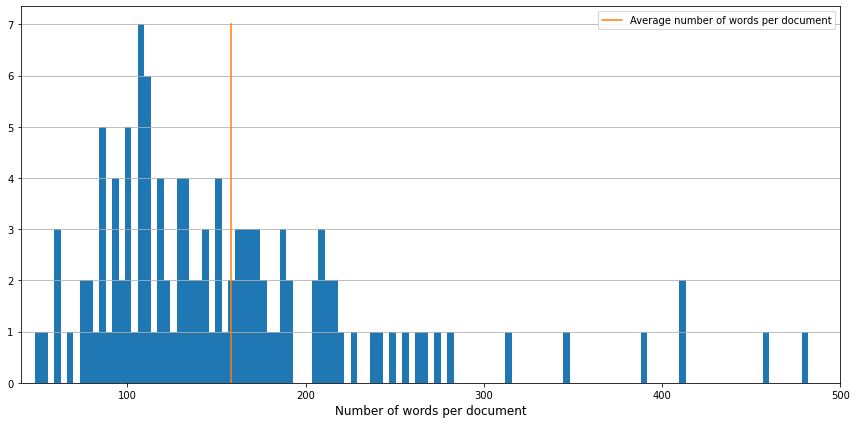

In [ ]:
num_bins = 120
documents_lengths = [len(document) for documents_cluster in documents for document in documents_cluster]

fig, ax = plt.subplots(figsize=(12,6))
n, bins, patches = ax.hist(documents_lengths, num_bins)
ax.set_xlabel('Number of words per document', fontsize=12)
ax.grid(axis='y')
plt.xlim(40, 500)
ax.plot([np.average(documents_lengths) for i in np.linspace(0.0,0.5,100)], np.linspace(0.0,7,100), '-',
        label='Average number of words per document')
ax.legend()
fig.tight_layout()
plt.show()

#### Drop short documents
As mentioned before, LDA doesn't work well with short text documents, so we will eliminate all the documents who have less than 40 tokens.

In [ ]:
documents = [[document for document in document_cluster if len(document) >= 40] for document_cluster in documents]
num_documents = sum([len(document_cluster) for document_cluster in documents])
print('Number of documents: ', num_documents)

Number of documents:  120


The second stage of pre-processing the data consists of:


1.   Compute a vocabulary by giving an unique id to each word in the documents and then represent the textual data with a vector which contains the unique id instead of the respective words
2.   Eliminate the tokens with a frequency equal to 1 from each document, as some tokens are not even real words or are rarely used in the corpus.



In [ ]:
# Build the vocabulary with all the words occurring in the documents
unique_id, vocabulary= 0, {}

for documents_cluster in documents:
  for document in documents_cluster:
    for word in document:
      if word not in vocabulary.keys():
        vocabulary[word] = unique_id
        unique_id += 1

print(vocabulary)

{'geographi': 0, 'field': 1, 'scienc': 2, 'devot': 3, 'studi': 4, 'land': 5, 'featur': 6, 'inhabit': 7, 'phenomena': 8, 'earth': 9, 'planet': 10, 'first': 11, 'person': 12, 'use': 13, 'word': 14, 'eratosthen': 15, 'bc': 16, 'allencompass': 17, 'disciplin': 18, 'seek': 19, 'understand': 20, 'human': 21, 'natur': 22, 'complexitiesnot': 23, 'mere': 24, 'object': 25, 'also': 26, 'chang': 27, 'come': 28, 'often': 29, 'defin': 30, 'term': 31, 'two': 32, 'branch': 33, 'physic': 34, 'concern': 35, 'peopl': 36, 'commun': 37, 'cultur': 38, 'economi': 39, 'interact': 40, 'environ': 41, 'relat': 42, 'across': 43, 'space': 44, 'place': 45, 'process': 46, 'pattern': 47, 'like': 48, 'atmospher': 49, 'hydrospher': 50, 'biospher': 51, 'geospher': 52, 'four': 53, 'histor': 54, 'tradit': 55, 'geograph': 56, 'research': 57, 'spatial': 58, 'analys': 59, 'area': 60, 'region': 61, 'humanland': 62, 'relationship': 63, 'call': 64, 'world': 65, 'bridg': 66, 'systemat': 67, 'univers': 68, 'associ': 69, 'cartogra

In [ ]:
# After building the vocabulary we represent the text data by replacing the words with the corresponding ID
processed_documents = []
for documents_cls in  documents:
  processed_cluster = []
  for document in documents_cls:
    processed_cluster.append([vocabulary[word] for word in document])
  processed_documents.append(processed_cluster)


In [ ]:
# Compute the word frequencies (the lists are ordered by the word id)
_, word_frequencies = np.unique(functools_reduce_dim(processed_documents), return_counts=True)

In [ ]:
# Remove words that have frequnecies less than 3
textual_representations = []

for doc_cls in processed_documents:
  cluster = []
  for doc in doc_cls:
    cluster.append([id_word for id_word in doc if word_frequencies[id_word] > 2])
  textual_representations.append(cluster)

### Visualize the frequecies of words per topic

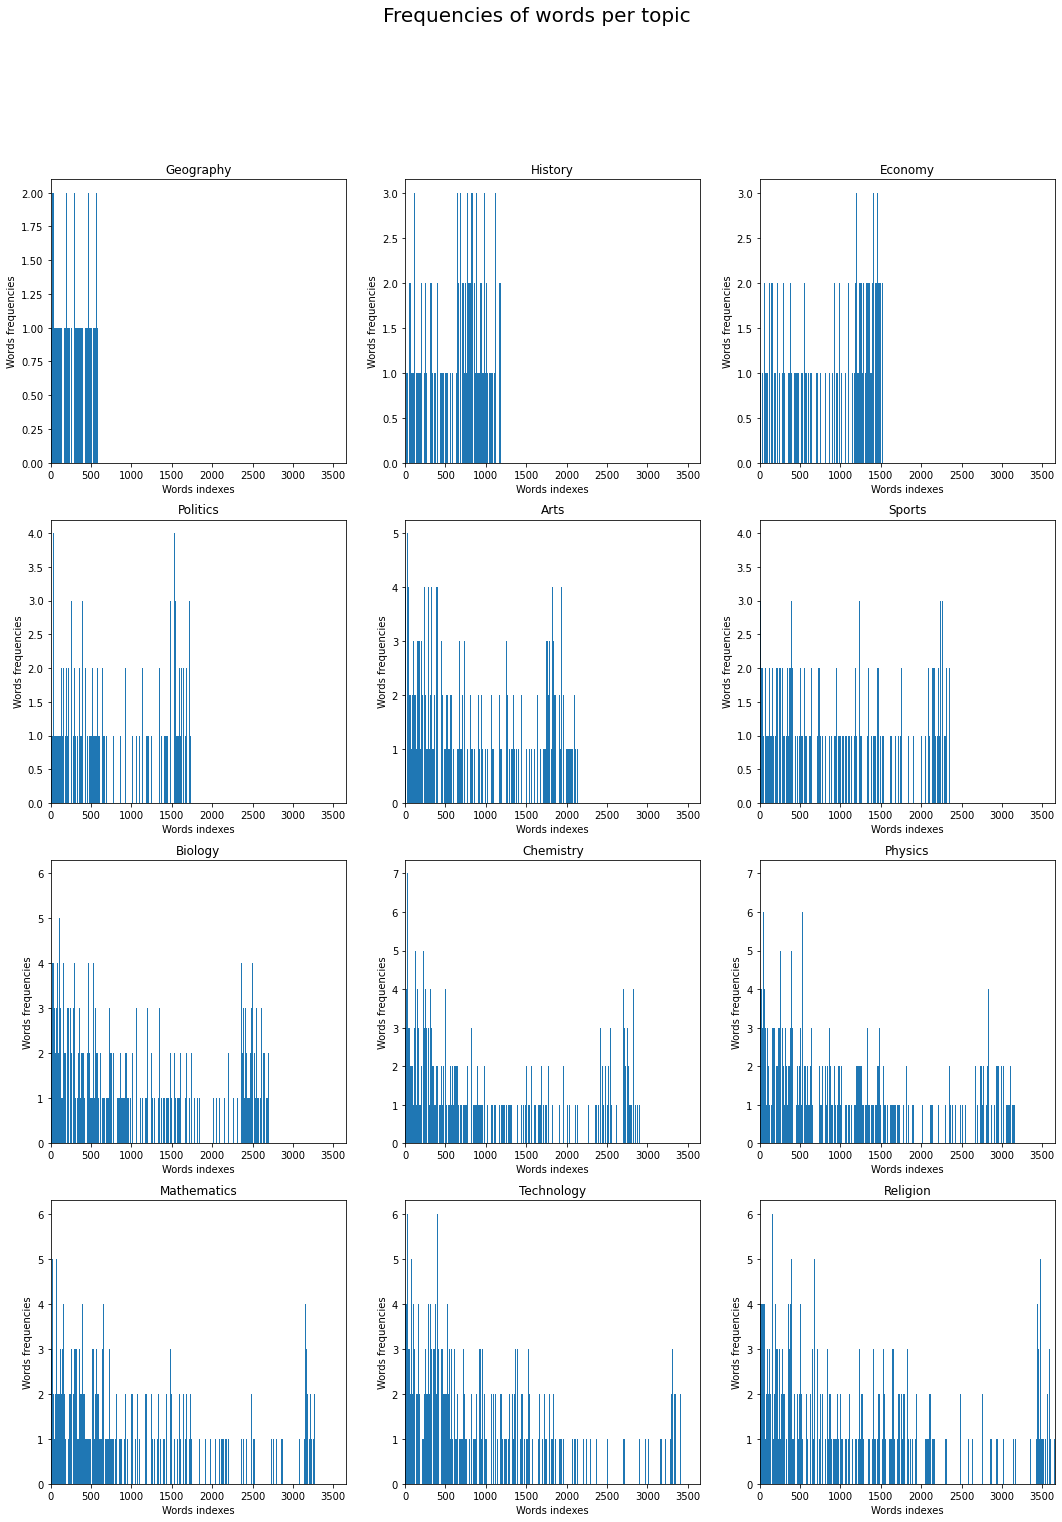

In [ ]:
fig, axes = plt.subplots(int(len(topics) / 3), 3, figsize = (18,24))
indexes = np.unique(functools_reduce_dim(textual_representations))
min_idx, max_idx = indexes[0], indexes[-1]

fig.suptitle('Frequencies of words per topic', fontsize = 20)
for (idx, topic) in topics.items():
  indexes = np.unique(functools.reduce(operator.concat, textual_representations[int(idx)]))
  axes[int(idx / 3), int(idx % 3)].hist(indexes, bins = 450)
  axes[int(idx / 3), int(idx % 3)].set_title(topic)
  axes[int(idx / 3), int(idx % 3)].set_xlabel('Words indexes')
  axes[int(idx / 3), int(idx % 3)].set_ylabel('Words frequencies')
  axes[int(idx / 3), int(idx % 3)].set_xlim(min_idx, max_idx)

As could be expected, similar themes have similar words' distribution (e.g., chemistry and biology, or mathematics and physics share common terms).

In [ ]:
textual_representations = np.array(textual_representations)
textual_representations = textual_representations.flatten()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


## LDA: Generative Process

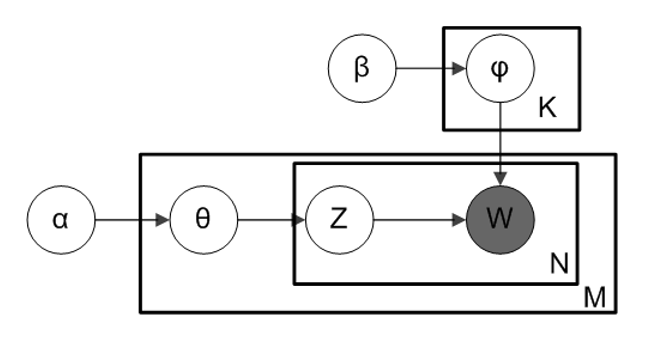

The main idea of LDA is to model documents as arising from multiple topics, where a topic is defined by a distribution over a fixed vocabulary of terms from a given corpus. More concretely, we assume that K topics are associated with a collection and that each document exhibits these topics in different proportions.

**M** represents the number of documnets in our collection of Wikipedia articles, **N** is the number of words and **N**$_m$ is the number of words in the **m**$^{th}$ document, **V** is the size of the vocabulary, and **K** number of predefined topics.

 Notations:
*   alpha (α) - parameter of the symmetric Dirichlet prior on the per-document topic distribution
*   beta (β) - parameter of the symmetric Dirichlet prior on the per-topic word distribution
*   phi (ϕ) - word distribution per topic (K-dimensional vector)
*   theta (θ) - topic distributions per-document (M-dimensional vector)
*   $ 𝐙_{m,n} $ - topic for the *n*$^{th}$ word in the *m*$^{th}$ document
*   $ W_{m,n} $ - specific word

Reference: Probabilistic Topic Models, David M. Blei
@article{10.1145/2133806.2133826}

The model is defined as follow:

>   
1.   For each topic $k$, $ 1 <= k <= K $, we draw its word distribution $ \phi_{k} \sim Dir(β)$.
2.   For each document $m$, $1<=m<=M$ ,
>> 2.1 Draw a topic distribution $ θ_m \sim Dir(𝜶) $
>>
>> 2.2 For each word $n$, $1 <= n <= N_m $, draw a topic assignment $ 𝐙_{m,n}\sim Multinomial(θ_m) $











The hyperparameters of the LDA models are 𝝰 and 𝛃. Their values depend on the application and may need to be refined several times before obtaining the desired results. The experiments performed were with different methods of initializations for the 𝝰 and 𝛃 values: set them to be equal to 1, randomly with values in the range (0,1), and set after performing a grid-search.

> 𝝰 - A low value for 𝝰 means that documents have only a low number of topics contributing to them, whereas a high value yields that the documents appear more alike within a corpus.
>
> 𝛃 - A low value for 𝛃 means the topics have a low number of contributing words, whereas a high value means the topics have a lot of overlapping words.




In [ ]:
K = len(topics)  # number of topics
M = num_documents # number of documents in our collection
V = len(vocabulary)  # number of words in the corpus
Nd = [len(document) for document in textual_representations] # document i has Nd[i] words

alpha = np.ones(K)
beta = np.ones(V)

# words distribution per-document
phi = pm.Container([pm.CompletedDirichlet("phi_%s" % k,
                                          pm.Dirichlet("phik_%s" % k, theta=beta))
                    for k in range(K)])

# topics distribution per-document
theta = pm.Container([pm.CompletedDirichlet("theta_%s" % m,
                                            pm.Dirichlet("thetam_%s" % m, theta=alpha))
                      for m in range(M)])

# topic distribution for each word n from document m
z = pm.Container([pm.Categorical("z_%i" %m,
                                 p = theta[m],
                                 value = np.random.randint(K, size=Nd[m]),
                                 size = Nd[m])
                  for m in range(M)])

# actual word for each token (word) n from document m
w = pm.Container([pm.Categorical("w_%s_%s" % (m, n),
                                 p = pm.Lambda("phi_Z_%s_%s" % (m, n), lambda z = z[m][n], phi = phi: phi[z]),
                                 value = textual_representations[m][n],
                                 observed = True)
                  for m in range(M) for n in range(Nd[m])])

model = pm.Model([phi, theta, z, w])

mcmc = pm.MCMC(model)
mcmc.sample(10000, 1000)

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 5001 of 5000 complete in 2160.4 sec

### Sanity check

#### Infer the hidden topic structure

In [ ]:
for i in range(K):
  print(mcmc.trace("phi_%s" %i)[8999])

[[7.18292505e-05 2.06350334e-04 6.66851998e-05 ... 8.03286385e-05
  9.83456326e-05 8.43875339e-04]]
[[9.73623983e-05 7.39171697e-05 4.32528173e-04 ... 1.24503549e-04
  3.61778029e-04 1.44512964e-04]]
[[4.48914818e-04 3.56443886e-04 6.33967161e-04 ... 2.93776156e-05
  6.25381839e-04 7.33326156e-05]]
[[5.86907978e-04 8.74494629e-05 3.79884786e-04 ... 1.87337607e-04
  1.95957623e-05 1.76534100e-04]]
[[2.71709493e-04 6.94527728e-04 1.83665790e-05 ... 2.15188988e-04
  3.57424983e-04 4.48950975e-05]]
[[1.50812907e-03 1.52104566e-04 2.55298341e-04 ... 6.69072784e-04
  1.15333483e-03 3.20594775e-05]]
[[9.47431187e-05 8.09582792e-04 5.55870524e-04 ... 7.18856526e-05
  9.27580527e-04 4.98939871e-04]]
[[1.85435589e-04 7.37273715e-05 1.01310108e-04 ... 5.77563036e-05
  1.30673871e-04 4.98000283e-04]]
[[3.39566376e-05 6.99602223e-05 4.37901000e-05 ... 1.75553980e-04
  8.35678553e-04 5.20847748e-05]]
[[1.30878683e-04 1.55812781e-04 1.07789369e-04 ... 3.18730302e-04
  7.25639706e-05 2.48486049e-04]]


In [ ]:
for j in range(M):
  print(mcmc.trace("theta_%s" %j)[8999])

[[1.07687379e-04 2.99447792e-01 1.34859958e-01 1.31372121e-01
  2.67862892e-02 3.12975317e-02 3.07250673e-02 1.07327879e-01
  3.10879146e-03 8.82997047e-02 1.30371469e-01 1.62957095e-02]]
[[0.01378861 0.03065336 0.14977369 0.11071241 0.04670797 0.18052479
  0.12005887 0.03587236 0.11545428 0.04195956 0.14691795 0.00757615]]
[[0.12382385 0.01265284 0.05174235 0.27465362 0.02640741 0.04752756
  0.09522373 0.00890327 0.04775597 0.1849787  0.0516251  0.0747056 ]]
[[0.2163893  0.08495871 0.04836303 0.30828263 0.04190456 0.04070732
  0.10347927 0.02153122 0.01030248 0.00380187 0.00879144 0.11148817]]
[[0.14253172 0.02801306 0.09666961 0.02496798 0.00529716 0.01279983
  0.01953327 0.2663588  0.22505682 0.03536872 0.1318826  0.01152043]]
[[0.04660675 0.05052904 0.00045264 0.05481561 0.06234227 0.43798542
  0.00261406 0.12731094 0.12403492 0.03742002 0.0462394  0.00964894]]
[[0.08879792 0.01676338 0.22888726 0.04981764 0.1342424  0.33496908
  0.00562434 0.02761263 0.00519611 0.02009545 0.036758

#### Trace $Z_{m,n}$ (each word was assigned to a topic to which it is most likely to belong)

In [ ]:
for m in range(M):
  print(mcmc.trace("z_%i" %m)[8999])

[11  7  6 10 10  6  7  2 10  1  3 11  9  1  7  9  9  7  3  2 10  7  7 10
  5  9 10  9  4  7 10  9  9 11  3  7  7  3  2  7  2  1 10  2  4 10  7  4
  2  9  9  5  2  7  9  9  9  2  1  6  3 10 10  6  1  5  1  2 10  1  1  5
 11  4  1  2  7  3  2  3  6  6 10 10  1  4 10 10 10  1]
[ 2  5  1  2  5  8  8  5  5  5  6  4  5  6  6  2  6  5 10 10  3  8 10  8
  3  3  6  2  8  6  8  5  5  4 10  0  8  7  2  5  1  2 10  5  2  6  9  6
 10  3  6  2  2 10  8  1  7  6  2  6  5  3  5  5  5  0  2  2  3  8  8  6
  1  6  3 10  1  6  3  5  8 10  5  4 10  2  2 10  3  3  3  6 10  3  4  5
  6]
[11  9  1  6  3  5  3  0  6  0  0  6 10  3 10  0 11  6  0  8 10 10  3  3
  5 10  6  0  5 10  3  3 11 10  3  6  3 10  8  3  0  5  0 11  9  3  9 10
  7  3  3  9 11  3  3  0 11  3  6  9  3  6  2  6 11 11  9  3  8  2  3  5
  2  3  0  8  5  9  3  5  3  9  9  2  9  6  6  9  3  9 11  3  3  3  9]
[11  0 11 11  0  3  0 11 11  3  3 10  6 11 10  7  3  1  4  3  3  1  5  6
  2 11  8  3  2  0  4 11  6  0 11  0  1 11 11  3 11  6  6  0  6 1

In [ ]:
for i in range(K):
  p = (mcmc.trace('phi_%i' %i)[8999])
  zipped = list(zip(p[0], list(vocabulary.keys())))
  zipped.sort(key = lambda t: t[0], reverse = True)
  print('Topic %s:\n' % i, zipped[0:20])
  print()

Topic 0:
 [(0.002409956003245333, 'exclud'), (0.0023505122560536634, 'eastern'), (0.002177887272110171, 'soft'), (0.002071372257148168, 'grain'), (0.0018080392150279262, 'theori'), (0.0017458871115081944, 'tour'), (0.0016710001592977436, 'ethic'), (0.0016527925104643188, 'swift'), (0.00162092498174093, 'interv'), (0.0015785970215564478, 'typolog'), (0.0015569543840495545, 'symbol'), (0.0015311092018972076, 'shanin'), (0.001514049645184811, 'apthek'), (0.001494579358273999, 'light'), (0.0014744355795169434, 'elohim'), (0.0014729279748717785, 'compani'), (0.001451331675169947, 'assign'), (0.001447892949083269, 'ultim'), (0.0014448733178097201, 'somewher'), (0.0014292063770350767, 'complet')]

Topic 1:
 [(0.00259127581681526, 'sculpt'), (0.0022592594103747485, 'racial'), (0.0020578587830111365, 'proport'), (0.002036503271700914, 'transport'), (0.0019147698516338723, 'forth'), (0.0018434241596238198, 'stori'), (0.001834270317500622, 'commonli'), (0.0016390355197326823, 'feminist'), (0.0016

In order to find the best values for the hyperparameters alpha and beta we run a grid search over [0.1, 0.2, ... , 0.9, 1.0] x [0.1, 0.2, ... , 0.9, 1.0] values. We will decide on the values of alpha and beta based on the way the model clusters together the top 10 words for each topic.

In [ ]:
values_alpha = np.array([0.1 * i for i in range(1, 10)])
values_beta = np.array([0.1 * i for i in range(1, 10)])

for value_alpha in values_alpha:
  for value_beta in values_beta:
    alpha = np.full(K, value_alpha)
    beta = np.full(V, value_beta)

    # words distribution per-document
    phi = pm.Container([pm.CompletedDirichlet("phi_%s" % k,
                                              pm.Dirichlet("phik_%s" % k, theta=beta))
                        for k in range(K)])

    # topics distribution per-document
    theta = pm.Container([pm.CompletedDirichlet("theta_%s" % m,
                                                pm.Dirichlet("thetam_%s" % m, theta=alpha))
                          for m in range(M)])

    # topic distribution for each word n from document m
    z = pm.Container([pm.Categorical("z_%i" %m,
                                    p = theta[m],
                                    value = np.random.randint(K, size=Nd[m]),
                                    size = Nd[m])
                      for m in range(M)])

    # actual word for each token (word) n from document m
    w = pm.Container([pm.Categorical("w_%s_%s" % (m, n),
                                    p = pm.Lambda("phi_Z_%s_%s" % (m, n), lambda z = z[m][n], phi = phi: phi[z]),
                                    value = textual_representations[m][n],
                                    observed = True)
                      for m in range(M) for n in range(Nd[m])])

    model = pm.Model([phi, theta, z, w])

    mcmc = pm.MCMC(model)
    mcmc.sample(5000, 1000)

    for i in range(K):
      p = (mcmc.trace('phi_%i' %i)[3999])
      zipped = list(zip(p[0], list(vocabulary.keys())))
      zipped.sort(key=lambda t: t[0], reverse=True)
      print('Topic %s:\n' % i, zipped[:10])
      print()

    print()

# **Task 2:** Documents Similarities

For these exercises we will test the following measures:

*   Dot product
*   Cosine similarity
*   Hellinger distance (as proposed in [Topic Models. DAVID M. BLEI, JOHN D. LAFFERTY](http://www.cs.columbia.edu/~blei/papers/BleiLafferty2009.pdf))
*   Jensen-Shannon distance


*1) Can the topic model be used to define a topic-based similarity measure between documents?*

**Dot product**

$$ topic\_similarity(X, Y) = X · Y = \sum_{i=1}^{N} x_i y_i $$

where $X$ and $Y$ are N-dimensional vectors

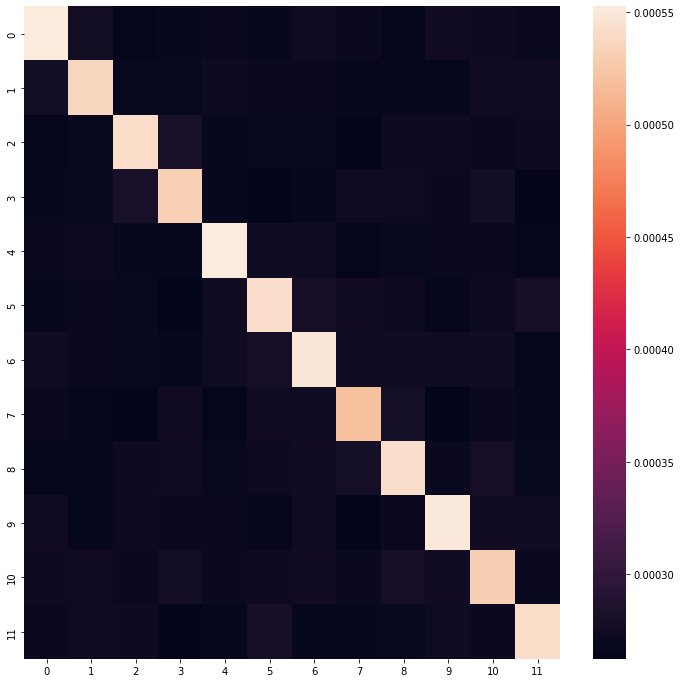

In [ ]:
topics_similarities = np.zeros((len(topics), len(topics)))

for i in range(K):
  for j in range(K):
    phi_i = mcmc.trace('phi_%i' % i)[8999]
    phi_j = mcmc.trace('phi_%i' % j)[8999]
    topics_similarity = np.sum([phi1 * phi2 for (phi1, phi2) in zip(phi_i, phi_j)])
    topics_similarities[i][j] = topics_similarity

# plot heatmap
plt.figure(figsize=(len(topics), len(topics)))
sn.heatmap(topics_similarities)

**Cosine similarity**

In many NLP tasks, cosine similarity is used as a measure of similarity between documents disregarding their size. Mathematically, it measures the cosine of the angle between two vectors projected in a multi-dimensional space. More precisely, it is the same as the inner product of the same vectors normalized to both to have a length equal to 1.

$$ topic\_similarity(X,Y) = \frac{X · Y}{||X|| · ||Y||} = \frac{\sum_{i=1}^{N}{x_i y_i}}{\sqrt{\sum_{i=1}^{N}{x_i^2}} * \sqrt{\sum_{i=1}^{N}{y_i^2}} } $$

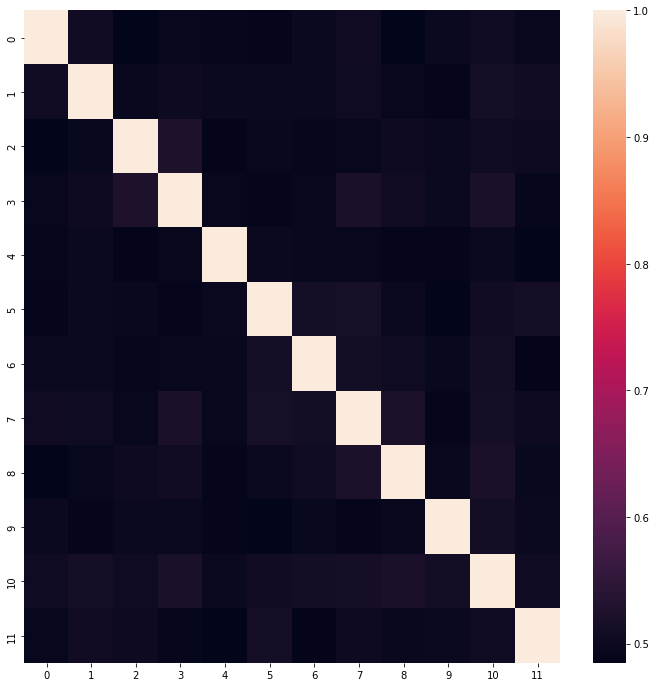

In [ ]:
topics_similarities = np.zeros((len(topics), len(topics)))

for i in range(K):
  for j in range(K):
    phi_i = mcmc.trace('phi_%i' % i)[8999]
    phi_j = mcmc.trace('phi_%i' % j)[8999]
    topics_similarity = np.dot(phi_i, phi_j.T) / (np.linalg.norm(phi_i) * np.linalg.norm(phi_j))
    topics_similarities[i][j] = topics_similarity

# plot heatmap
plt.figure(figsize=(len(topics), len(topics)))
sn.heatmap(topics_similarities)

As we can observed in the two figures, only cosine similarity assign the value 1 (white color - maximum) for topics[i] and topics[j] when i = j, which means the two topics are identical. Even if, the dot product measure assign a high value of similarity there shouldn't be any difference between two identical topics. Also, values close to 0 are assigned for different topics (dark colors).

**Hellinger distance**

In [Topic Models](http://www.cs.columbia.edu/~blei/papers/BleiLafferty2009.pdf), the authors proposed a topic-based similarity measure between documents based on the posterior topic distribution using Hellinger distance.

Hellinger distance is defined as follow:

$$ document\_similarity(X,Y) =  \sum_{k=1}^{K}{\frac{1}{\sqrt{2}}(\sqrt{θ_{d,k}} - \sqrt{θ_{f,k}} )}$$



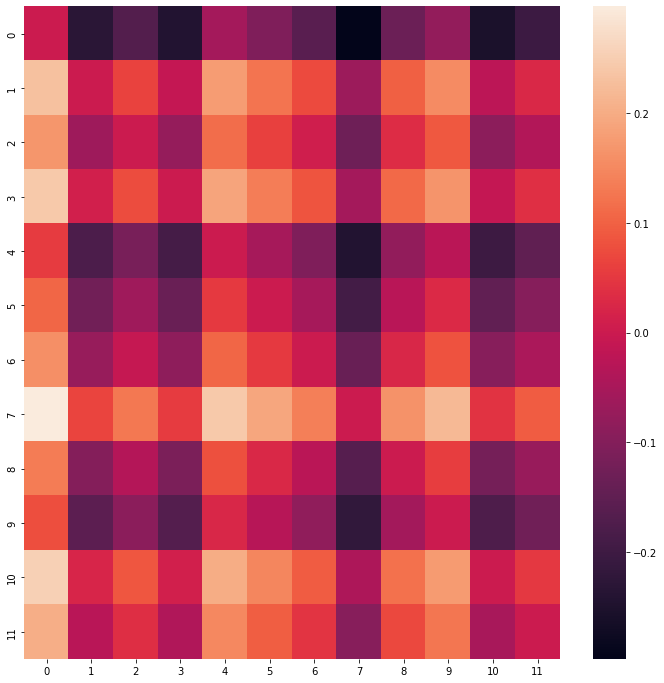

In [ ]:
topics_similarities = np.zeros((len(topics), len(topics)))

for i in range(K):
  for j in range(K):
    phi_i = mcmc.trace('phi_%i' % i)[11999]
    phi_j = mcmc.trace('phi_%i' % j)[11999]
    topics_similarity = np.sum([(1. / sqrt(2)) *  (np.sqrt(phi1) - np.sqrt(phi2)) for (phi1, phi2) in zip(phi_i, phi_j)])
    topics_similarities[i][j] = topics_similarity

# plot heatmap
plt.figure(figsize=(len(topics), len(topics)))
sn.heatmap(topics_similarities)

Values closer to 0 (red color, as on the diagonal) means the distributions are similar.

*2) What about a new document? How can topics be assigned to it?*

In [ ]:
"""
  One sample for each topic. A sample contain specific terms for the topic, but some of them also contain terms specific for others topics
  or common terms in english language.
"""
articles = []
# geography
articles.append(" Geography geography Earth geographer land region water rural humanland ")
# history
articles.append("history historian histography history persecute global freud control")
# economy
articles.append("economics deflation banks economy money inflation monetary bank monetarism economic sector pcr ")
# politics
articles.append("mutual politics political democracy kill liberty government liberalism political freedom marxist socialism constitution macropolitics")
# arts
articles.append("art colors film painting music bond bond")
# sports
articles.append("sports athletics competitive sportmanship olympic games tokyo norm mean height")
# biology
articles.append("biology cell plant chemistry geneticist genetics")
# chemistry
articles.append("atom molecular substance chemical chemistry restrict")
# physics
articles.append("Quantum Physics is the natural science that studies matter, its fundamental constituents, its motion and behavior through space and time, and the related entities")
# mathematics
articles.append("infinite trait first order logic mathematics numbers proof algebra logical calculus theorem mechanics")
# technology
articles.append("technology computer")
# religion
articles.append("orthodox church god light priest christianity heaven eastern church evil good Holy Spirit (Holy Ghost). For the majority of Christian denominations, the Holy Spirit, or Holy Ghost")

Firstly, we will pre-process the unseen document with the exact two stages of pre-processing data used for computing the data for the model. After that, we will use the posterior distribution ϕ (per-topic word distribution) and compare it with the textual representation (words indexes) of the unseen document.

We will only consider the words from the new articles occurring in the existing vocabulary (the one we used to train the model). So if there are unknown words in the documents, they will not be considered when inferring the topic distribution. I suppose that this is one of the limitations of the LDA algorithm.

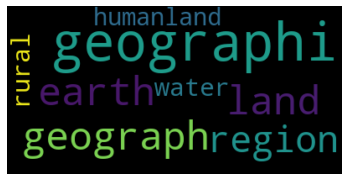

Topic assigned Geography with score 0.004048090978569245



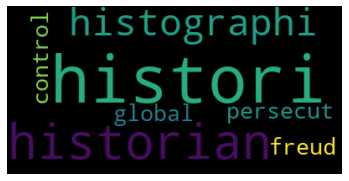

Topic assigned History with score 0.005184225557126202



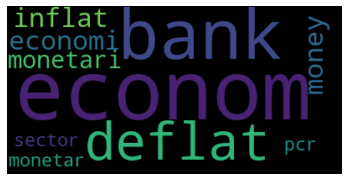

Topic assigned Economy with score 0.0055084226860895045



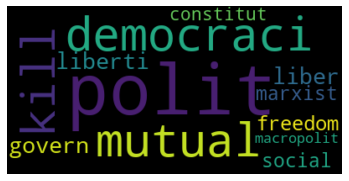

Topic assigned History with score 0.006259787858241386



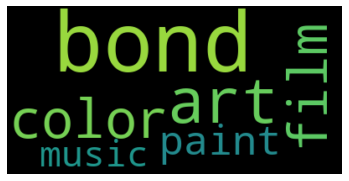

Topic assigned Arts with score 0.00583300954986905



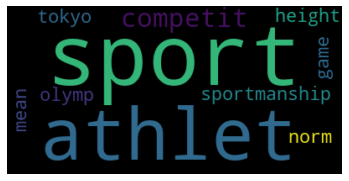

Topic assigned Sports with score 0.005205070684409339



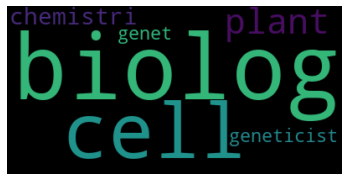

Topic assigned Technology with score 0.0030383101439227143



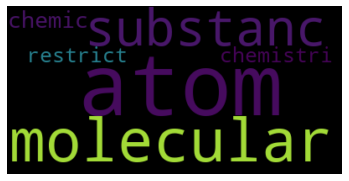

Topic assigned Chemistry with score 0.0028862150197052194



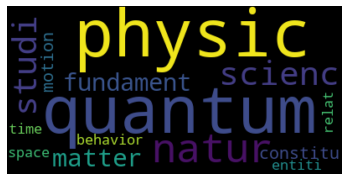

Topic assigned Physics with score 0.004945171259068888



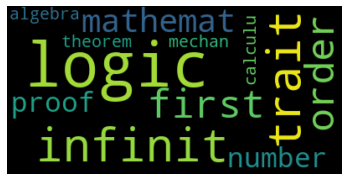

Topic assigned Mathematics with score 0.006882916908049839



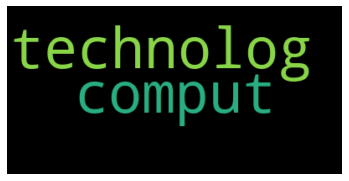

Topic assigned Sports with score 0.001148736762841364



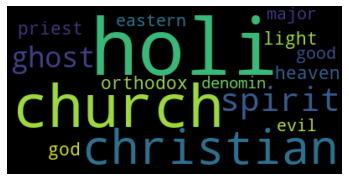

Topic assigned Technology with score 0.010252773867452505



In [ ]:
def generate_word_cloud(words):
  text = ' '.join(words)
  wordcloud = WordCloud().generate(text)

  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()


def process_document(unseen_document):
  unseen_document = normalize_text(unseen_document)
  unseen_document = unseen_document.translate(str.maketrans(' ', ' ', special_characters))
  unseen_document = remove_multiple_occurences(unseen_document)

  unseen_document_processed = []
  for word in unseen_document.split(" "):
    if word not in STOPWORDS:
      unseen_document_processed.append(word)

  unseen_document_processed = [stemmer.stem(word) for word in unseen_document_processed]
  unseen_document_proccesed = [word for word in unseen_document_processed if len(word) > 1]
  generate_word_cloud(unseen_document_processed)
  # print(unseen_document_processed)
  textual_representation = [vocabulary[word] for word in unseen_document_processed if word in list(vocabulary.keys())]
  # print(textual_representation)

  return textual_representation


def assign_topic(new_document):
  best_score, topic_index = 0., 0.

  for idx_topic in range(K):
    score = 0.
    phi_values = mcmc.trace('phi_%i' % idx_topic)[11999][0]
    # for each "word" (index from our vocabulary) in the new document
    for i in range(len(new_document)):
      score += phi_values[new_document[i]]

    if (score > best_score):
      best_score, topic_index = score, idx_topic

  print("Topic assigned {} with score {}".format(topics[topic_index], best_score))


for unseen_document in articles:
  processed_unseen_document = process_document(unseen_document)
  assign_topic(processed_unseen_document)
  print()

**Jensen-Shannon distance**

Jensen-Shannon divergence is a measure of similarity between two probabilities distributions. I chose this measure because it has two important properties: symmetry and finite value.


# Correlated Topic Model

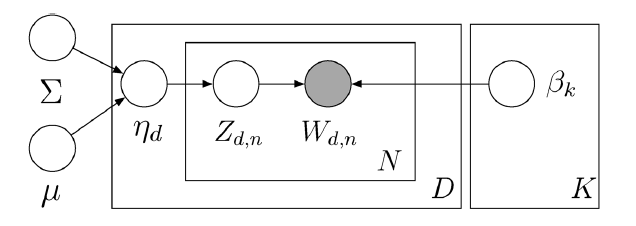

In our dataset, we don't have all the topics independent from one another (e.g., chemistry and biology, or physics and mathematics),  a breach of the presumption held by the Dirichlet distribution.  

LDA models documents as a distribution of topics and topics as a distribution of words. The generative process consists in selecting a topic from the document's distribution of topics, θ, and picking a term from that topic's distribution of words, β. These distribution are generated from the Dirichlet distribution. Having this in mind means the LDA model is unable to model correlated topics.

The CTM (Correlated Topic Model) model arise as a solution for the limitations of the LDA model. The main difference is the use of the multivariate generalization of the normal distribution.

#### Generative process

**M** represents the number of documnets in our collection of Wikipedia articles, **N** is the number of words and **N**$_m$ is the number of words in the **m**$^{th}$ document, **V** is the size of the vocabulary, and **K** number of predefined topics.

 Notations:
*   mu (μ) - K-dimensional vector
*   sigma (Σ) - KxK randomly initialized covariance matrix
*   eta (η) - multivariate normal distribution; $ η_d \sim N(\mu, Σ) $
*   theta (θ) - topic distributions per-document (M-dimensional vector)
*   beta (β) - word distribution per topic (K-dimensional vector) - in code will appear as phi, same as in the LDA model  
*   $ 𝐙_{m,n} $ - topic for the *n*$^{th}$ word in the *m*$^{th}$ document
*   $ W_{m,n} $ - specific word

Reference: [Correlated Topic Models. David. M. Blei, John D. Lafferty
](https://proceedings.neurips.cc/paper/2005/file/9e82757e9a1c12cb710ad680db11f6f1-Paper.pdf)








In [ ]:
K = len(topics)  # number of topics
M = num_documents # number of documents in our collection
V = len(vocabulary)  # number of words in the corpus
Nd = [len(document) for document in textual_representations] # document i has Nd[i] words

mu = np.ones(K)
# rand = np.random.rand(K, 1)
# sigma = np.dot(rand, rand.transpose()) # semi positive definite
sigma = make_spd_matrix(K) # symmetrical positive definite matrix

eta = pm.Container([pm.MvNormal('eta_%s' % m, mu = mu, tau = sigma)
                    for m in range(M)])
# distribution over topic indices
theta = pm.Container([np.exp(eta[m].value) / np.sum(np.exp(eta[m].value))
                      for m in range(M)])

# topic distribution for each word n from document m
z = pm.Container([pm.Categorical("z_%i" % m,
                                 p = theta[m],
                                 value = np.random.randint(K, size = Nd[m]))
                  for m in range(M)])

# actual word for each token (word index) n from document m
w = pm.Container([pm.Categorical("w_%s_%s" % (m, n),
                                 p = pm.Lambda("phi_Z_%s_%s" % (m, n), lambda z = z[m][n], phi = phi: phi[z]),
                                 value = textual_representations[m][n],
                                 observed = True)
                  for m in range(M) for n in range(Nd[m])])

model = pm.Model([eta, phi, theta, z, w])

mcmc = pm.MCMC(model)
mcmc.sample(10000, 1000)

/usr/local/lib/python3.7/dist-packages/pymc/MCMC.py:81: UserWarning: Instantiating a Model object directly is deprecated. We recommend passing variables directly to the Model subclass.
  warnings.warn(message)


 [-----------------100%-----------------] 10001 of 10000 complete in 6379.6 sec

In [ ]:
for m in range(M):
  print(mcmc.trace("z_%i" % m)[8999])

[ 2  9  6  2  2 10  2 11  9  2  6  6  6  6  0  2 11  6 10  6 10  9  2  2
  2  9  9  3  9  2  4  6  6 11  9  6  6  6  6  6  6  9  0  2  7  9  2  2
 10 10  6  6  6  6  6 10  6 10  2 11  6 10  6  2  2  6  6 11 11 11  6  9
  3  9  2  1  1  6  6  2  2  6 11  2  6  9  6  6  6  2]
[ 4  2  2  7  9  2  2  2  2  8  4  2  7  1  2  2  7 11  2  7  4  9  9  2
  7  2 11  2  7  7  9  4  2  2  7  7  9  8 11 11  6  2  9  9  9  2  2  9
  4  7  9  2 11  9  7 11  2  7  4  7  2  7 11  7  2  9  2  2  9  2  2  4
  7  2  2  9  2  7  2  7  7  2  7  9  9  2  4  9  9  4  2  7  2  2 11  9
  2]
[11  0  4  0 11 11  4 10 11  4  4 11  4  0 11  0  0  0  0  1  0  4 10  9
 11 11  4  4 11  1  9 11  0 11 10  2  4  4  9  4 11 10  4  8  4 11  2 11
  1  0  0  0 11 10  7  4 10  9  9  9 11  0  0  9  2  0  4 11  4  4  4  0
  9 10  9  8  9 11  0 11 11  9  0  4  4  0  4  4  0 11  9  0  4 11 11]
[ 9  6  2  2  2  2  3  9  9  9  9  2  9  2  2 11  6  9  6  9 11  6  9  6
  9  2  9  2  2  2  9  9  2  9  9  2  2  2  2  2  9 11  2  9  9  

In [ ]:
for i in range(K):
  p = (mcmc.trace('phi_%i' % i)[8999])
  zipped = list(zip(list(vocabulary.keys()), p[0]))
  zipped.sort(key = lambda t: t[1], reverse = True)
  print('Topic %s:\n' % i, zipped[0:25])
  print()

Topic 0:
 [('perish', 0.00253317181006595), ('parenthes', 0.002392447460295852), ('oxid', 0.0019935343011572397), ('web', 0.0018372963418516702), ('etho', 0.0017216481634356213), ('forecast', 0.0017140336194235819), ('block', 0.001712754401834433), ('explain', 0.0016082496640566393), ('spawn', 0.0015889803504485613), ('boyl', 0.00158690665258404), ('glorifi', 0.00158598752062508), ('typic', 0.0015818010320373416), ('speed', 0.0015370549442677395), ('follow', 0.0015199849844112381), ('kind', 0.0014927925916448344), ('rural', 0.001478777231742748), ('direct', 0.0014612041530179167), ('busi', 0.0014451966070552133), ('vent', 0.0014449021713596705), ('tyranni', 0.0014368280120352478), ('crop', 0.0014326837524120484), ('ethnic', 0.0014085634926272396), ('arriv', 0.0013979814333403443), ('problemsolv', 0.0013829543592211513), ('courtesi', 0.001377181375046388)]

Topic 1:
 [('sportaccord', 0.0034421505076368594), ('particularli', 0.0024062290889410583), ('iondipol', 0.0022050025378129185), ('

# Conclusions


1.   LDA suffers from having a relatively small collection of documents over a large corpus. Also, it is unable to model correlated topics.
2.   We quickly retrieved the most similar documents in the trained corpus when compared to the new unseen documents. We obtained good results since these most similar documents were closely related to the query document from the point of view of the predominant themes, but we also have bad results with some similar topics emphasizing that the LDA model is unable to model correlated topics.
3. We obtain better results by increasing the number of iterations.

